# Control 2

#### Guido Rios Ciaffaroni
#### Eduardo Opazo Diaz

## 1. Estructura general del código

Este archivo es, en esencia, el mismo pipeline NLP + estadística descriptiva que el anterior:

1. Descarga y carga del texto bíblico (formato BCVS).
2. Limpieza inicial (text_clean, eliminación de <I>, ¶).
3. Limpieza profunda / eliminación de ruido (text_no_noise).
4. Normalización:
* minúsculas
* word_tokenize
* eliminación de stopwords (tokens_no_stop)
* text_normalized
5. Métricas básicas:
* nº de versículos
* nº total de palabras
* nº de palabras únicas / vocabulario
* nº de libros y capítulos
6. Análisis de longitudes:
* palabras por versículo (media, mediana, moda, varianza, desviación estándar)
* longitud máxima y mínima de versículos
* distribución de longitudes (histogramas, KDE, boxplots)
7. Análisis de palabras:
* top N palabras globales
* top N por libro y por capítulo
* palabras clave (dios, hombre, tierra) global y por libro
* comparación con y sin stopwords
8. Métricas por libro y capítulo:
* palabras totales por libro y capítulo
* versículo más largo / más corto por libro
* libro más extenso y más breve
9. Métricas de densidad y riqueza léxica:
* TTR global
* TTR por libro
* hapax legomena / dislegomena
* palabras raras (freq ≤ 3)
* palabras comunes (percentil 95)
* diversidad léxica (tokens vs tipos)
10. NLP avanzado:
* N-grams (bi, tri, 4-grams)
* spaCy: lematización + POS tagging
* conteo de verbos, sustantivos, adjetivos
* vocabulario con ID, frecuencia, exportado a CSV
* TF-IDF por libro (palabras características)
* TF-IDF por personaje (dios, adan, noe, abraham, jacob)

https://www.biblesupersearch.com/unbound-downloads/

In [1]:
!wget -O spanish_sagradas_escrituras_1569.txt \
https://raw.githubusercontent.com/GuidoRiosCiaffaroni/AnalisisBiblico/refs/heads/main/Libros/spanish_sagradas_escrituras_1569_utf8_mapped_to_NRSVA.txt


--2025-11-22 00:10:50--  https://raw.githubusercontent.com/GuidoRiosCiaffaroni/AnalisisBiblico/refs/heads/main/Libros/spanish_sagradas_escrituras_1569_utf8_mapped_to_NRSVA.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4912213 (4.7M) [text/plain]
Saving to: ‘spanish_sagradas_escrituras_1569.txt’

spanish_sagradas_es 100%[===================>]   4.68M  --.-KB/s    in 0.02s   

2025-11-22 00:10:50 (234 MB/s) - ‘spanish_sagradas_escrituras_1569.txt’ saved [4912213/4912213]



In [2]:
# =================================================================
# 1. SETUP E IMPORTACIÓN DE DATOS
# =================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Descargar recursos de NLTK (solo necesario la primera vez)
try:
    nltk.download('stopwords')
    nltk.download('punkt')
except:
    pass  # Ya descargado

# Ruta del archivo subido al entorno (proveído por ChatGPT)
FILE_PATH = '/content/spanish_sagradas_escrituras_1569.txt'

# Columnas del formato BCVS (The Unbound Bible)
COLUMNS = [
    'nrsva_book_index', 'nrsva_chapter', 'nrsva_verse',
    'orig_book_index', 'orig_chapter', 'orig_verse',
    'orig_subverse', 'order_by', 'text'
]

# =================================================================
# 2. CARGA DEL ARCHIVO
# =================================================================
df = pd.read_csv(
    FILE_PATH,
    sep='\t',
    names=COLUMNS,
    comment='#',
    encoding='utf-8',
    skipinitialspace=True
)

# =================================================================
# 3. LIMPIEZA INICIAL DEL TEXTO
# =================================================================

# Eliminar etiquetas <I> ... </I> y el símbolo ¶
df['text_clean'] = df['text'].astype(str)
df['text_clean'] = df['text_clean'].apply(lambda x: re.sub(r'<I>.*?</I>', '', x))
df['text_clean'] = df['text_clean'].apply(lambda x: x.replace('¶', ' ').strip())

# Reemplazar cadenas vacías por NaN y eliminar filas vacías
df['text_clean'] = df['text_clean'].replace('', np.nan)
df = df.dropna(subset=['text_clean']).reset_index(drop=True)

# =================================================================
# 4. LIMPIEZA PROFUNDA DEL TEXTO (para NLP)
# =================================================================

def limpiar_texto(t):
    t = t.lower()  # Minúsculas
    t = re.sub(r'[^a-záéíóúñü ]', ' ', t)  # Solo letras
    t = re.sub(r'\s+', ' ', t)  # Un solo espacio
    return t.strip()

df['text_clean_deep'] = df['text_clean'].apply(limpiar_texto)

print(" DataFrame cargado y limpiado correctamente")

print("\nPrimeras 5 filas del DataFrame limpio:")
print(df[['nrsva_book_index', 'nrsva_chapter', 'nrsva_verse', 'text_clean_deep']].head())

print("\nInformación del DataFrame:")
print(df.info())





[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


 DataFrame cargado y limpiado correctamente

Primeras 5 filas del DataFrame limpio:
  nrsva_book_index  nrsva_chapter  nrsva_verse  \
0              01O              1            1   
1              01O              1            2   
2              01O              1            3   
3              01O              1            4   
4              01O              1            5   

                                     text_clean_deep  
0   en el principio creó dios los cielos y la tierra  
1  y la tierra estaba desordenada y vacía y las t...  
2                y dijo dios sea la luz y fue la luz  
3  y vio dios que la luz buena y apartó dios a la...  
4  y llamó dios a la luz día y a las tinieblas ll...  

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31104 entries, 0 to 31103
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   nrsva_book_index  31104 non-null  object 
 1   nr

In [3]:
# (BLOQUE PREVIO – YA EJECUTADO)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

FILE_PATH = '/content/spanish_sagradas_escrituras_1569.txt'

COLUMNS = [
    'nrsva_book_index', 'nrsva_chapter', 'nrsva_verse',
    'orig_book_index', 'orig_chapter', 'orig_verse',
    'orig_subverse', 'order_by', 'text'
]

df = pd.read_csv(
    FILE_PATH,
    sep='\t',
    names=COLUMNS,
    comment='#',
    encoding='utf-8',
    skipinitialspace=True
)

print("DataFrame original cargado:", df.shape)


DataFrame original cargado: (31104, 9)


# Manejo de faltantes y duplicados

In [4]:
# =================================================================
# 1. MANEJO DE FALTANTES Y DUPLICADOS
# =================================================================

# Copia de trabajo para no modificar el original
df_clean = df.copy()

# 1.1 Revisión de valores faltantes
print("Valores faltantes por columna antes de limpiar:")
print(df_clean.isna().sum())

# 1.2 Eliminar filas donde 'text' esté vacío o sea NaN
df_clean['text'] = df_clean['text'].astype(str)
df_clean['text'] = df_clean['text'].replace(['', ' ', 'nan'], np.nan)
df_clean = df_clean.dropna(subset=['text'])

# 1.3 Eliminación de filas duplicadas exactas en todas las columnas
df_clean = df_clean.drop_duplicates()

# (Opcional) Eliminación de duplicados solo a nivel de texto
# df_clean = df_clean.drop_duplicates(subset=['text'])

df_clean = df_clean.reset_index(drop=True)

print("\n Después de limpiar faltantes y duplicados:")
print("Shape:", df_clean.shape)
print("Valores faltantes por columna:")
print(df_clean.isna().sum())


Valores faltantes por columna antes de limpiar:
nrsva_book_index        0
nrsva_chapter           0
nrsva_verse             0
orig_book_index         0
orig_chapter            0
orig_verse              0
orig_subverse       31104
order_by                0
text                    0
dtype: int64

 Después de limpiar faltantes y duplicados:
Shape: (31104, 9)
Valores faltantes por columna:
nrsva_book_index        0
nrsva_chapter           0
nrsva_verse             0
orig_book_index         0
orig_chapter            0
orig_verse              0
orig_subverse       31104
order_by                0
text                    0
dtype: int64


# BLOQUE 2 – Eliminación de ruido (etiquetas, símbolos, puntuación, números…)

In [5]:
# =================================================================
# 2. ELIMINACIÓN DE RUIDO
# =================================================================

import re

# Partimos de df_clean generado en el bloque anterior
df_noise = df_clean.copy()

def eliminar_ruido(texto):
    # Aseguramos que sea string
    t = str(texto)

    # 2.1 Eliminar etiquetas HTML tipo <I>...</I> y similares
    t = re.sub(r'<.*?>', ' ', t)

    # 2.2 Eliminar símbolo ¶
    t = t.replace('¶', ' ')

    # 2.3 Eliminar números
    t = re.sub(r'\d+', ' ', t)

    # 2.4 Eliminar signos de puntuación y caracteres no alfabéticos
    t = re.sub(r"[^a-zA-ZáéíóúÁÉÍÓÚñÑüÜ\s]", " ", t)

    # 2.5 Reemplazar múltiples espacios por uno solo
    t = re.sub(r'\s+', ' ', t)

    # 2.6 Quitar espacios al inicio y al final
    t = t.strip()

    return t

# Nueva columna con texto sin ruido
df_noise['text_no_noise'] = df_noise['text'].apply(eliminar_ruido)

print(" Ruido eliminado. Ejemplo de antes / después:\n")
print("ANTES :", df_noise['text'].iloc[0])
print("DESPUÉS:", df_noise['text_no_noise'].iloc[0])


 Ruido eliminado. Ejemplo de antes / después:

ANTES : ¶ En el principio creó Dios los cielos y la tierra. 
DESPUÉS: En el principio creó Dios los cielos y la tierra


# Normalización (minusculización, stopwords, tokenización, etc.)

In [6]:
# =================================================================
# 3. NORMALIZACIÓN DEL TEXTO (CORREGIDO y VALIDADO)
# =================================================================

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Descargar recursos necesarios
try:
    nltk.download('stopwords')
    nltk.download('punkt')
    nltk.download('punkt_tab')  # NECESARIO EN GOOGLE COLAB
except:
    pass

df_norm = df_noise.copy()

# 3.1 Convertir a minúsculas
df_norm['text_lower'] = df_norm['text_no_noise'].str.lower()

# 3.2 Tokenización
df_norm['tokens'] = df_norm['text_lower'].apply(word_tokenize)

# 3.3 Stopwords en español
stopwords_es = set(stopwords.words('spanish'))

def quitar_stopwords(tokens):
    return [tok for tok in tokens if tok not in stopwords_es and len(tok) > 1]

df_norm['tokens_no_stop'] = df_norm['tokens'].apply(quitar_stopwords)

# 3.4 Reconstruir texto normalizado
df_norm['text_normalized'] = df_norm['tokens_no_stop'].apply(lambda toks: ' '.join(toks))

print(" Normalización completada correctamente.")

# Mostrar ejemplo
print("\nEjemplo:\n")
print("Original :", df_norm['text_no_noise'].iloc[0])
print("Tokens   :", df_norm['tokens'].iloc[0][:20])
print("Sin stop :", df_norm['tokens_no_stop'].iloc[0][:20])
print("Texto normalizado :", df_norm['text_normalized'].iloc[0][:200])



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


 Normalización completada correctamente.

Ejemplo:

Original : En el principio creó Dios los cielos y la tierra
Tokens   : ['en', 'el', 'principio', 'creó', 'dios', 'los', 'cielos', 'y', 'la', 'tierra']
Sin stop : ['principio', 'creó', 'dios', 'cielos', 'tierra']
Texto normalizado : principio creó dios cielos tierra


# Estadistica Basica

## Número total de versículos

In [7]:
# =================================================================
# Cálculo del número total de versículos
# =================================================================

total_versiculos = len(df_norm)

print(" Número total de versículos en la base de datos:", total_versiculos)


 Número total de versículos en la base de datos: 31104


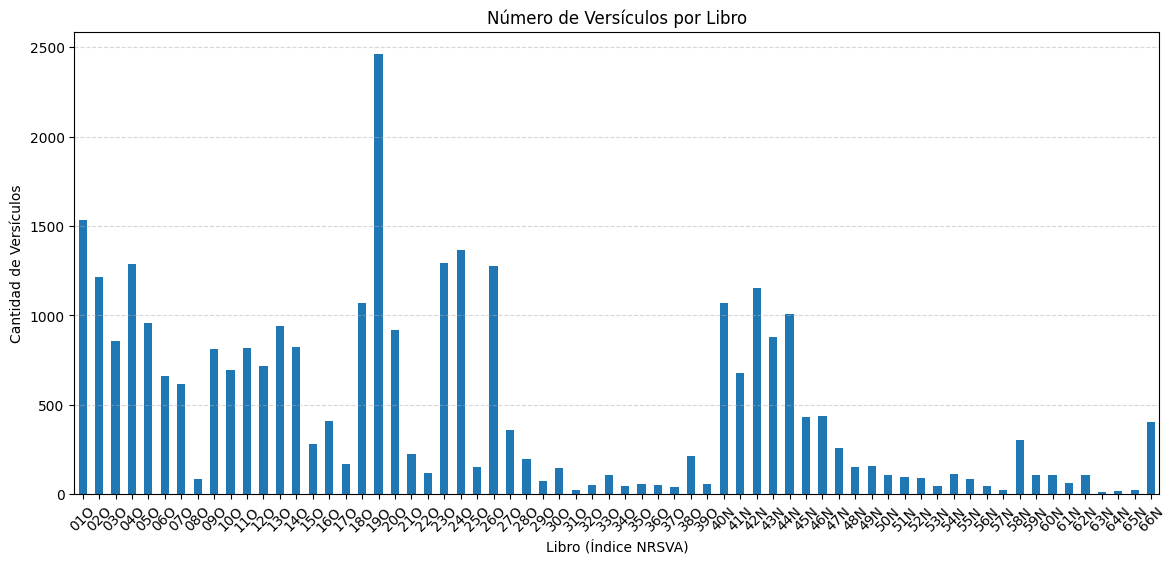

In [8]:
# =================================================================
# Gráfico de número de versículos por libro
# =================================================================

import matplotlib.pyplot as plt

# Contar versículos por libro usando el índice de libro original
versiculos_por_libro = df_norm.groupby('nrsva_book_index').size()

# Crear el gráfico
plt.figure(figsize=(14, 6))
versiculos_por_libro.plot(kind='bar')

plt.title('Número de Versículos por Libro')
plt.xlabel('Libro (Índice NRSVA)')
plt.ylabel('Cantidad de Versículos')

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()


### Número total de palabras

In [9]:
# =================================================================
# Cálculo del número total de palabras
# =================================================================

# Asegurarse de que la columna existe
if 'tokens_no_stop' not in df_norm.columns:
    raise ValueError("⚠ La columna 'tokens_no_stop' no existe. Asegúrate de haber ejecutado la normalización.")

# Contar palabras
total_palabras = df_norm['tokens_no_stop'].apply(len).sum()

print(" Número total de palabras (limpias y sin stopwords):", total_palabras)


 Número total de palabras (limpias y sin stopwords): 325768


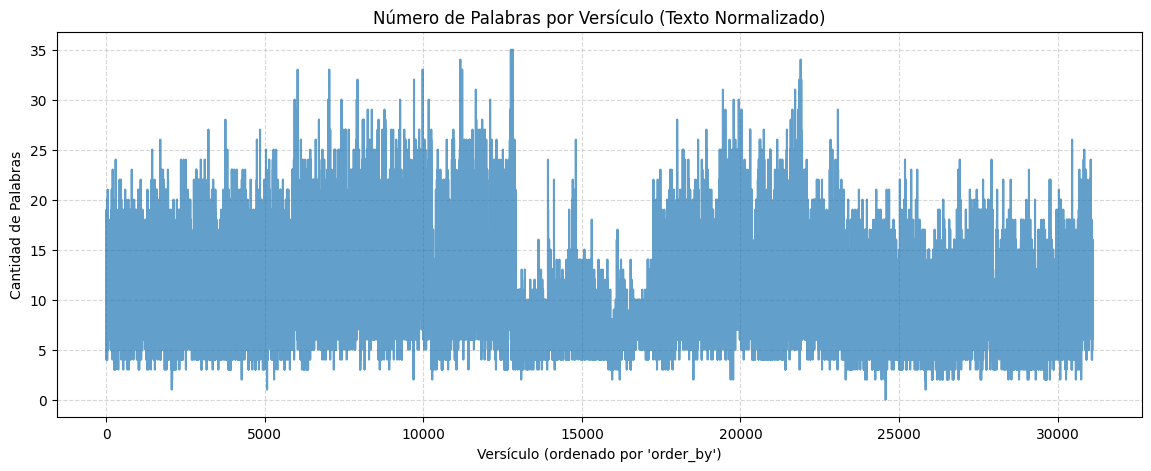

In [10]:
# =================================================================
# Gráfico de número de palabras por versículo
# =================================================================

import matplotlib.pyplot as plt

# Crear una columna con el conteo de palabras por versículo
df_norm['word_count'] = df_norm['tokens_no_stop'].apply(len)

plt.figure(figsize=(14, 5))
plt.plot(df_norm['word_count'], alpha=0.7)

plt.title("Número de Palabras por Versículo (Texto Normalizado)")
plt.xlabel("Versículo (ordenado por 'order_by')")
plt.ylabel("Cantidad de Palabras")

plt.grid(True, linestyle='--', alpha=0.5)

plt.show()


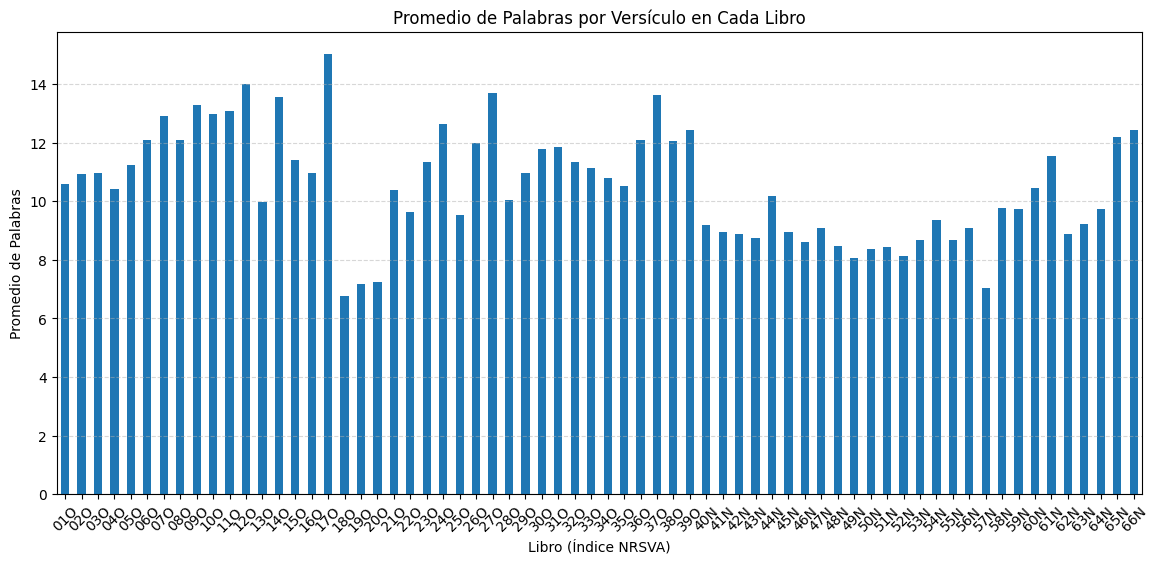

In [11]:
# =================================================================
# Promedio de palabras por libro
# =================================================================

promedio_palabras_libro = df_norm.groupby('nrsva_book_index')['word_count'].mean()

plt.figure(figsize=(14, 6))
promedio_palabras_libro.plot(kind='bar')

plt.title("Promedio de Palabras por Versículo en Cada Libro")
plt.xlabel("Libro (Índice NRSVA)")
plt.ylabel("Promedio de Palabras")

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()


### Número total de palabras únicas ("vocabulario")

In [12]:
# =================================================================
# Cálculo del número de palabras únicas (vocabulario)
# =================================================================

# Aplanar lista de listas
todas_las_palabras = [pal for lista in df_norm['tokens_no_stop'] for pal in lista]

# Convertir a conjunto (elimina duplicados)
vocabulario = set(todas_las_palabras)

num_palabras_unicas = len(vocabulario)

print(" Número total de palabras únicas en el texto:", num_palabras_unicas)


 Número total de palabras únicas en el texto: 24875


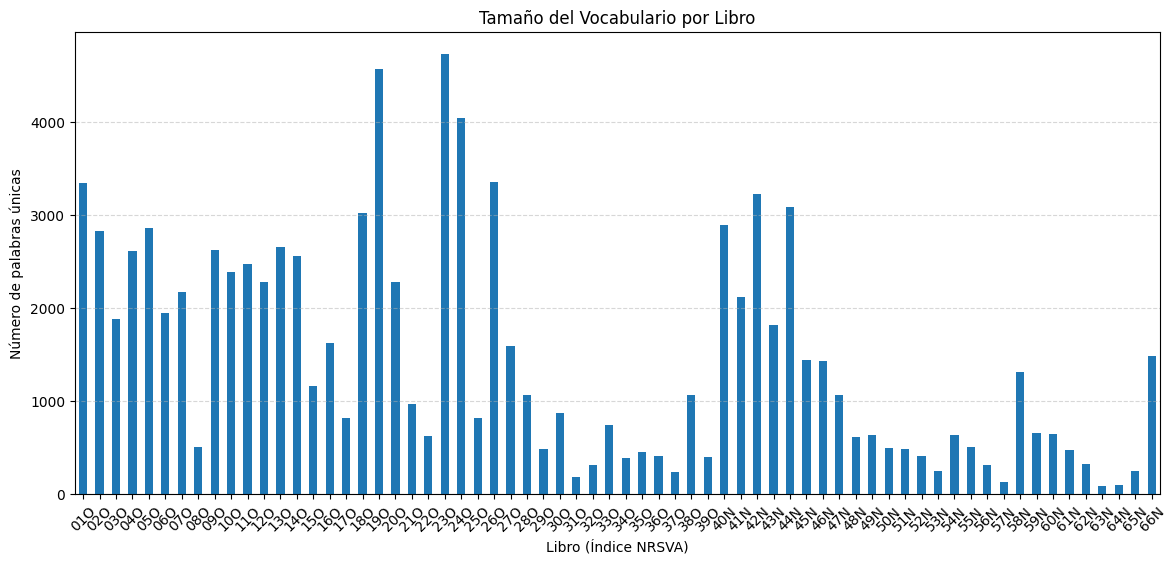

In [13]:
# =================================================================
# Tamaño del vocabulario por libro
# =================================================================

import matplotlib.pyplot as plt

# Función para obtener vocabulario de un libro
def vocabulario_por_libro(df):
    resultados = {}
    for libro, grupo in df.groupby('nrsva_book_index'):
        palabras = [pal for lista in grupo['tokens_no_stop'] for pal in lista]
        resultados[libro] = len(set(palabras))
    return resultados

vocab_libros = vocabulario_por_libro(df_norm)

# Convertir a Series para facilitar el gráfico
import pandas as pd
vocab_series = pd.Series(vocab_libros).sort_index()

# Gráfico
plt.figure(figsize=(14, 6))
vocab_series.plot(kind='bar')

plt.title("Tamaño del Vocabulario por Libro")
plt.xlabel("Libro (Índice NRSVA)")
plt.ylabel("Número de palabras únicas")

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()


### Longitud promedio del texto por versículo

In [14]:
# =================================================================
# Longitud promedio del texto por versículo
# =================================================================

# Crear columna de longitud por versículo
df_norm['word_count'] = df_norm['tokens_no_stop'].apply(len)

# Longitud promedio
longitud_promedio = df_norm['word_count'].mean()

print(" Longitud promedio del texto por versículo:", longitud_promedio)


 Longitud promedio del texto por versículo: 10.473508230452675


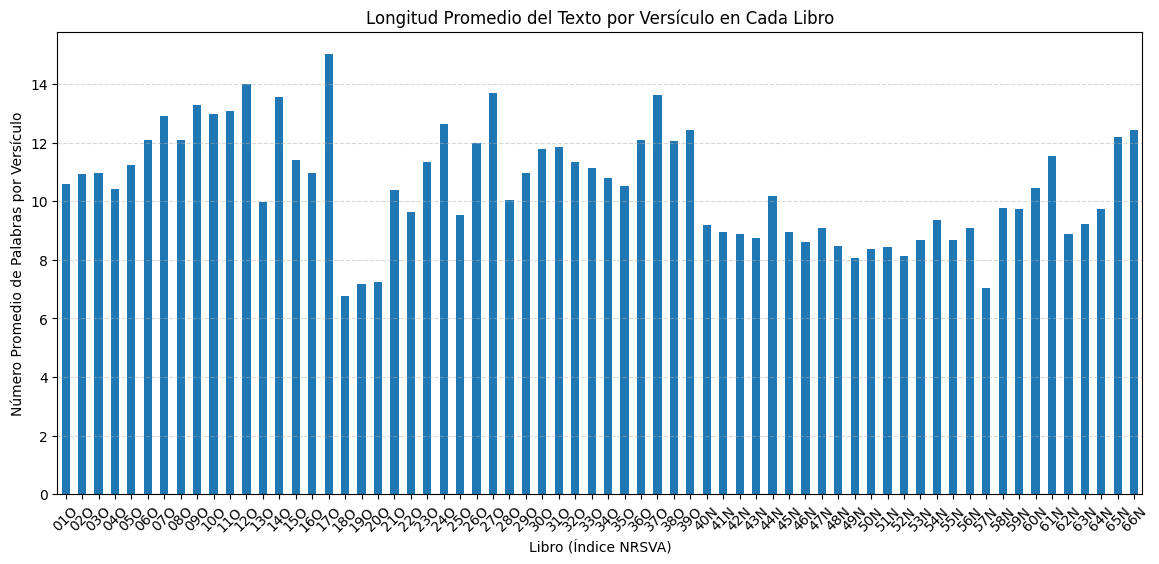

In [15]:
# =================================================================
# Gráfico: Longitud promedio por libro
# =================================================================

import matplotlib.pyplot as plt

# Calcular promedio por libro
promedio_por_libro = df_norm.groupby('nrsva_book_index')['word_count'].mean()

plt.figure(figsize=(14, 6))
promedio_por_libro.plot(kind='bar')

plt.title("Longitud Promedio del Texto por Versículo en Cada Libro")
plt.xlabel("Libro (Índice NRSVA)")
plt.ylabel("Número Promedio de Palabras por Versículo")

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()


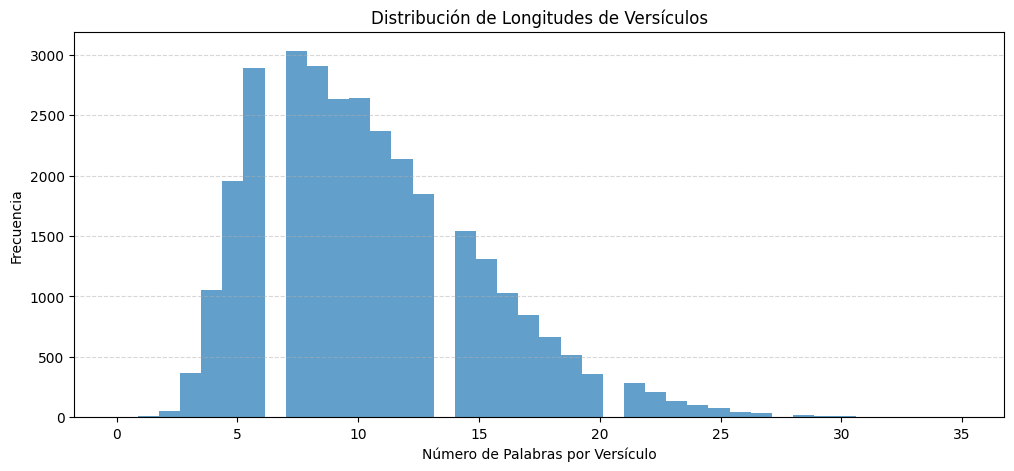

In [16]:
# =================================================================
# Distribución general de longitudes de versículos
# =================================================================

plt.figure(figsize=(12, 5))
plt.hist(df_norm['word_count'], bins=40, alpha=0.7)

plt.title("Distribución de Longitudes de Versículos")
plt.xlabel("Número de Palabras por Versículo")
plt.ylabel("Frecuencia")

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


### Calcular longitud máxima y mínima del versículo

In [17]:
# =================================================================
# Longitud máxima y mínima del versículo
# =================================================================

# Asegurar columna de conteo de palabras
df_norm['word_count'] = df_norm['tokens_no_stop'].apply(len)

longitud_maxima = df_norm['word_count'].max()
longitud_minima = df_norm['word_count'].min()

# Versículos específicos (opcional)
versiculo_max = df_norm[df_norm['word_count'] == longitud_maxima].iloc[0]
versiculo_min = df_norm[df_norm['word_count'] == longitud_minima].iloc[0]

print(" Longitud máxima de un versículo:", longitud_maxima, "palabras")
print(" Versículo más largo:", versiculo_max['text_no_noise'])
print()
print(" Longitud mínima de un versículo:", longitud_minima, "palabras")
print(" Versículo más corto:", versiculo_min['text_no_noise'])


 Longitud máxima de un versículo: 35 palabras
 Versículo más largo: Entonces fueron llamados los escribanos del rey en el mes primero a trece del mismo y fue escrito conforme a todo lo que mandó Amán a los príncipes del rey y a los capitanes que estaban sobre cada provincia y a los príncipes de cada pueblo a cada provincia según su escritura y a cada pueblo según su lengua en nombre del rey Asuero fue escrito y signado con el anillo del rey

 Longitud mínima de un versículo: 0 palabras
 Versículo más corto: Porque el que no es contra nosotros por nosotros es


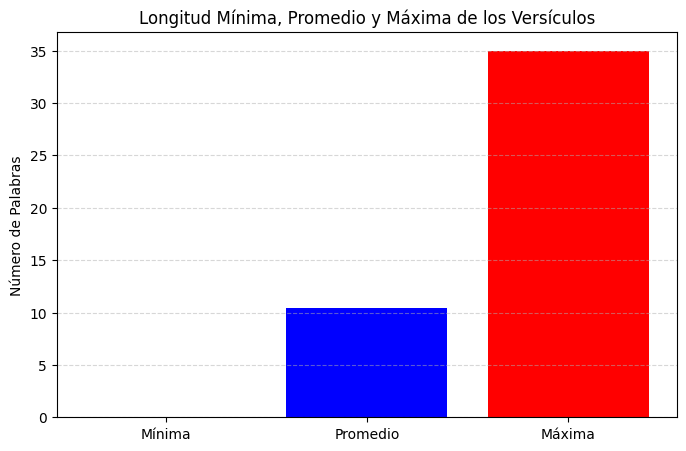

In [18]:
# =================================================================
# Gráfico: Longitud máxima, mínima y promedio
# =================================================================

import matplotlib.pyplot as plt

longitud_promedio = df_norm['word_count'].mean()

metricas = {
    "Mínima": longitud_minima,
    "Promedio": longitud_promedio,
    "Máxima": longitud_maxima
}

plt.figure(figsize=(8, 5))
plt.bar(metricas.keys(), metricas.values(), color=['green', 'blue', 'red'])

plt.title("Longitud Mínima, Promedio y Máxima de los Versículos")
plt.ylabel("Número de Palabras")

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


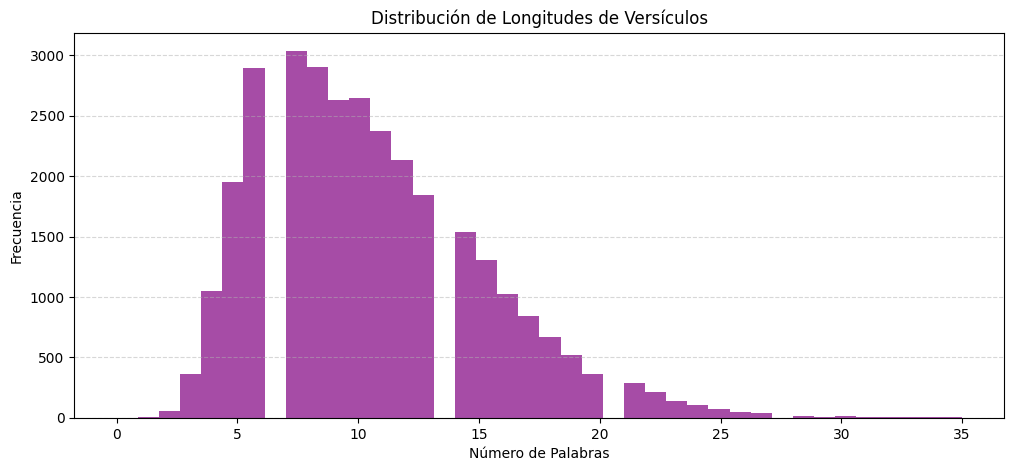

In [19]:
# =================================================================
# Distribución de longitudes de versículos
# =================================================================

plt.figure(figsize=(12, 5))
plt.hist(df_norm['word_count'], bins=40, alpha=0.7, color='purple')

plt.title("Distribución de Longitudes de Versículos")
plt.xlabel("Número de Palabras")
plt.ylabel("Frecuencia")

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


### Cálculo de la distribución de longitudes

In [20]:
# =================================================================
# Distribución descriptiva de longitudes de versículos
# =================================================================

# Asegurar que existe la columna de conteo
df_norm['word_count'] = df_norm['tokens_no_stop'].apply(len)

descripcion = df_norm['word_count'].describe()

print(" Distribución descriptiva de longitudes:")
print(descripcion)


 Distribución descriptiva de longitudes:
count    31104.000000
mean        10.473508
std          4.543708
min          0.000000
25%          7.000000
50%         10.000000
75%         13.000000
max         35.000000
Name: word_count, dtype: float64


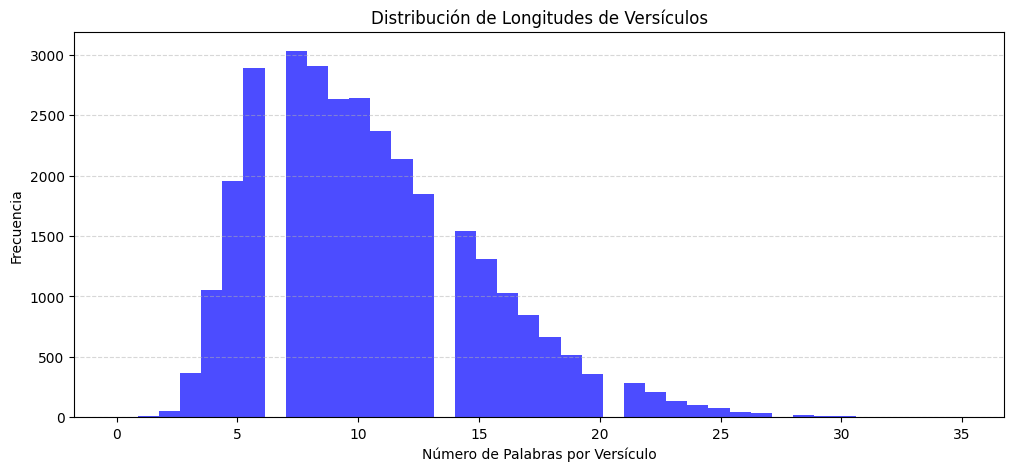

In [21]:
# =================================================================
# Histograma de la distribución de longitudes
# =================================================================

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.hist(df_norm['word_count'], bins=40, alpha=0.7, color='blue')

plt.title("Distribución de Longitudes de Versículos")
plt.xlabel("Número de Palabras por Versículo")
plt.ylabel("Frecuencia")

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


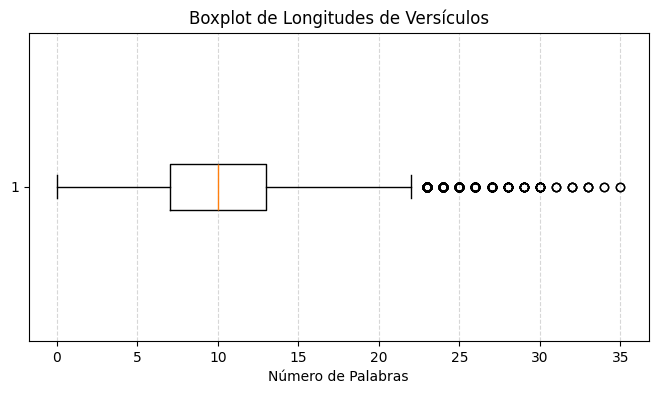

In [22]:
# =================================================================
# Boxplot de longitudes de versículos
# =================================================================

plt.figure(figsize=(8, 4))
plt.boxplot(df_norm['word_count'], vert=False)

plt.title("Boxplot de Longitudes de Versículos")
plt.xlabel("Número de Palabras")

plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()


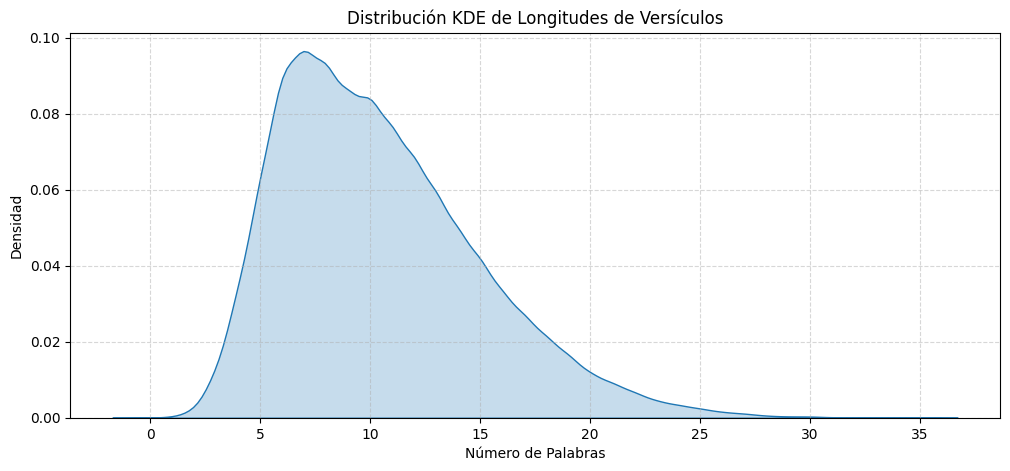

In [23]:
# =================================================================
# KDE (curva suavizada de la distribución)
# =================================================================

import seaborn as sns

plt.figure(figsize=(12, 5))
sns.kdeplot(df_norm['word_count'], fill=True)

plt.title("Distribución KDE de Longitudes de Versículos")
plt.xlabel("Número de Palabras")
plt.ylabel("Densidad")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


### Calcular métricas estadísticas de longitud

In [24]:
# =================================================================
# Métricas estadísticas: media, mediana, moda, varianza,
# desviación estándar de la longitud de versículos
# =================================================================

import numpy as np
from scipy import stats

# Asegurar columna de conteo
df_norm['word_count'] = df_norm['tokens_no_stop'].apply(len)

# Media
media = df_norm['word_count'].mean()

# Mediana
mediana = df_norm['word_count'].median()

# Moda (puede devolver varias; tomamos la primera)
moda = stats.mode(df_norm['word_count'], keepdims=True)[0][0]

# Varianza
varianza = df_norm['word_count'].var()

# Desviación estándar
desviacion = df_norm['word_count'].std()

print(" MÉTRICAS ESTADÍSTICAS DE LONGITUD DE VERSÍCULOS")
print("-----------------------------------------------")
print(f"Media: {media:.2f} palabras")
print(f"Mediana: {mediana:.2f} palabras")
print(f"Moda: {moda} palabras")
print(f"Varianza: {varianza:.2f}")
print(f"Desviación Estándar: {desviacion:.2f}")


 MÉTRICAS ESTADÍSTICAS DE LONGITUD DE VERSÍCULOS
-----------------------------------------------
Media: 10.47 palabras
Mediana: 10.00 palabras
Moda: 7 palabras
Varianza: 20.65
Desviación Estándar: 4.54


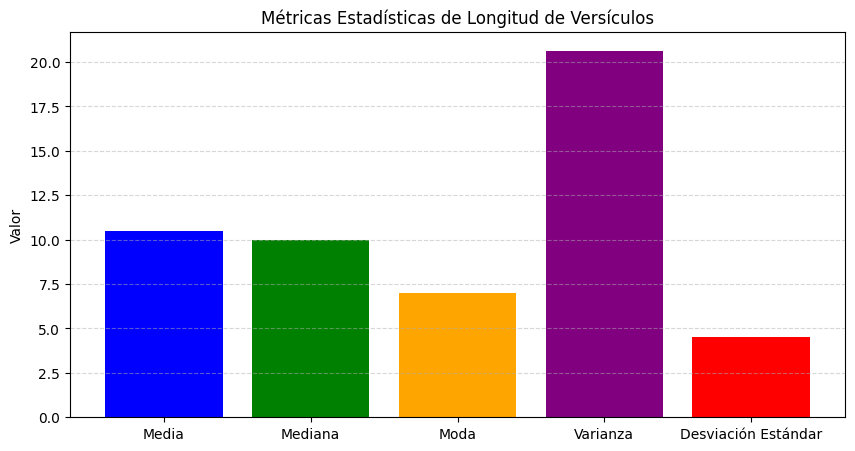

In [25]:
# =================================================================
# Gráfico comparativo de métricas estadísticas
# =================================================================

import matplotlib.pyplot as plt

metricas = {
    "Media": media,
    "Mediana": mediana,
    "Moda": moda,
    "Varianza": varianza,
    "Desviación Estándar": desviacion
}

plt.figure(figsize=(10, 5))
plt.bar(metricas.keys(), metricas.values(), color=['blue', 'green', 'orange', 'purple', 'red'])

plt.title("Métricas Estadísticas de Longitud de Versículos")
plt.ylabel("Valor")
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()


In [26]:
# =================================================================
# Tabla resumen de métricas estadísticas
# =================================================================

import pandas as pd

tabla = pd.DataFrame({
    "Métrica": ["Media", "Mediana", "Moda", "Varianza", "Desviación Estándar"],
    "Valor": [media, mediana, moda, varianza, desviacion]
})

display(tabla)


Métrica      Valor
0                Media  10.473508
1              Mediana  10.000000
2                 Moda   7.000000
3             Varianza  20.645281
4  Desviación Estándar   4.543708

### Cálculo de la cantidad de letras promedio por palabra

In [27]:
# =================================================================
# Cantidad de letras promedio por palabra
# =================================================================

# Aplanar lista de palabras
todas_las_palabras = [palabra for lista in df_norm['tokens_no_stop'] for palabra in lista]

# Calcular longitud de cada palabra
longitudes = [len(palabra) for palabra in todas_las_palabras]

# Promedio de letras
promedio_letras = sum(longitudes) / len(longitudes)

print(" Cantidad de letras promedio por palabra:", round(promedio_letras, 2))


 Cantidad de letras promedio por palabra: 6.12


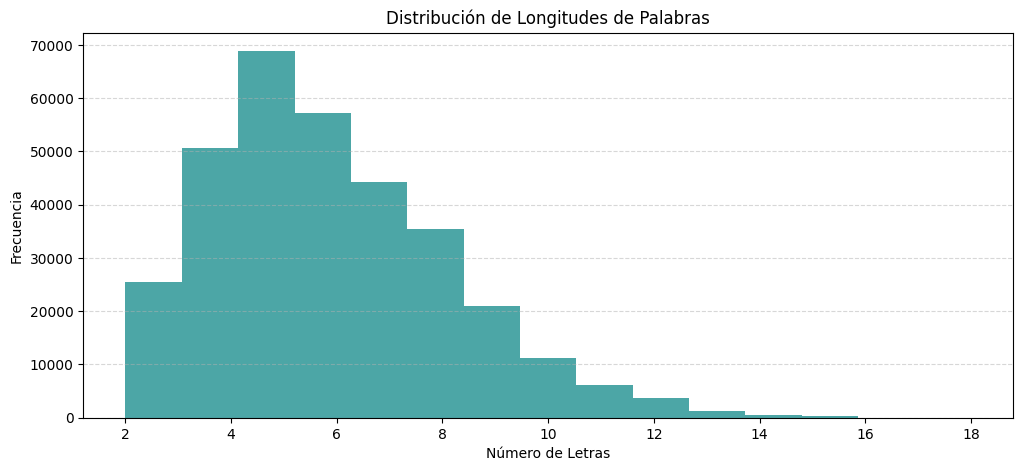

In [28]:
# =================================================================
# Histograma de longitudes de palabras
# =================================================================

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.hist(longitudes, bins=15, alpha=0.7, color='teal')

plt.title("Distribución de Longitudes de Palabras")
plt.xlabel("Número de Letras")
plt.ylabel("Frecuencia")

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


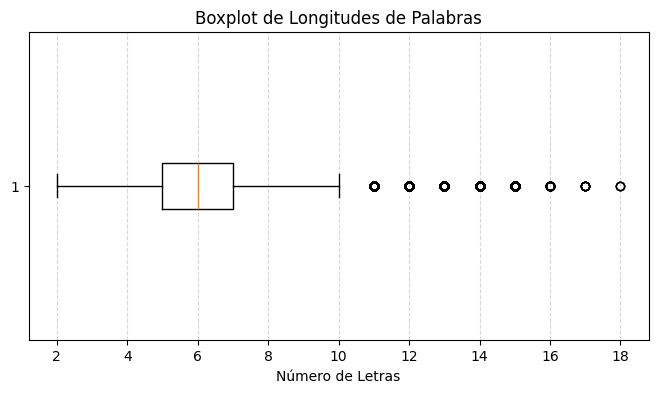

In [29]:
# =================================================================
# Boxplot de longitudes de palabras
# =================================================================

plt.figure(figsize=(8, 4))
plt.boxplot(longitudes, vert=False)

plt.title("Boxplot de Longitudes de Palabras")
plt.xlabel("Número de Letras")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()


### Calcular porcentaje de stopwords vs. palabras útiles

In [30]:
# =================================================================
# Porcentaje de stopwords vs. palabras útiles
# =================================================================

from nltk.corpus import stopwords
stopwords_es = set(stopwords.words('spanish'))

# Aplanar listas
todas_las_palabras = [pal for lista in df_norm['tokens'] for pal in lista]

# Identificar stopwords
stopwords_en_texto = [pal for pal in todas_las_palabras if pal.lower() in stopwords_es]

# Palabras útiles (no stopwords)
palabras_utiles = [pal for pal in todas_las_palabras if pal.lower() not in stopwords_es]

# Totales
total = len(todas_las_palabras)
total_stop = len(stopwords_en_texto)
total_utiles = len(palabras_utiles)

# Porcentajes
porcentaje_stop = (total_stop / total) * 100
porcentaje_utiles = (total_utiles / total) * 100

print(" PORCENTAJE DE STOPWORDS VS. PALABRAS ÚTILES")
print("------------------------------------------------")
print(f"Total de palabras: {total}")
print(f"Stopwords: {total_stop} ({porcentaje_stop:.2f}%)")
print(f"Palabras útiles: {total_utiles} ({porcentaje_utiles:.2f}%)")


 PORCENTAJE DE STOPWORDS VS. PALABRAS ÚTILES
------------------------------------------------
Total de palabras: 715570
Stopwords: 389784 (54.47%)
Palabras útiles: 325786 (45.53%)


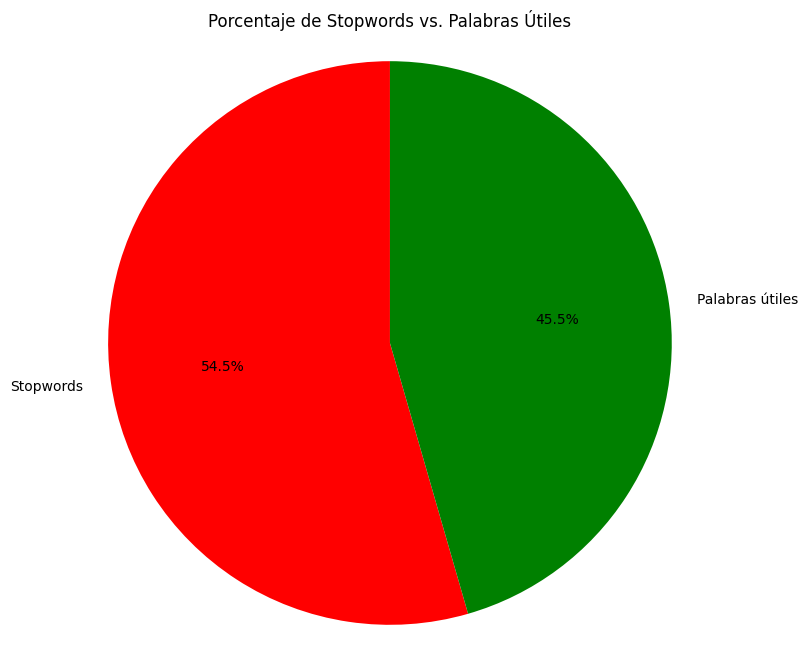

In [31]:
# =================================================================
# Gráfico: Stopwords vs palabras útiles (Pie Chart)
# =================================================================

import matplotlib.pyplot as plt

labels = ['Stopwords', 'Palabras útiles']
sizes = [porcentaje_stop, porcentaje_utiles]
colors = ['red', 'green']

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title("Porcentaje de Stopwords vs. Palabras Útiles")
plt.axis('equal')  # Mantener forma circular
plt.show()


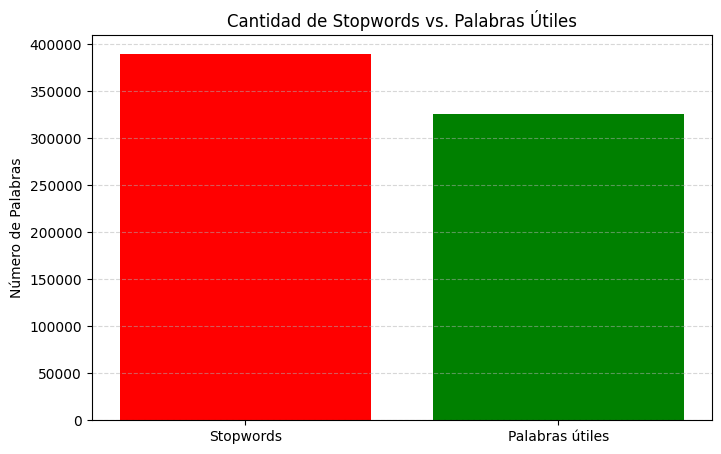

In [32]:
# =================================================================
# Gráfico de barras: Stopwords vs palabras útiles
# =================================================================

plt.figure(figsize=(8, 5))
plt.bar(['Stopwords', 'Palabras útiles'], [total_stop, total_utiles], color=['red', 'green'])

plt.title("Cantidad de Stopwords vs. Palabras Útiles")
plt.ylabel("Número de Palabras")
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()


### Número de libros distintos

In [33]:
# =================================================================
# Número de libros distintos
# =================================================================

# Contar cuántos libros diferentes hay en el índice NRSVA
num_libros_distintos = df_norm['nrsva_book_index'].nunique()

print(" Número de libros distintos en el corpus:", num_libros_distintos)


 Número de libros distintos en el corpus: 66


In [34]:
# =================================================================
# Listado de libros distintos
# =================================================================

libros_unicos = df_norm['nrsva_book_index'].unique()
libros_unicos.sort()

print(" Libros presentes (índices NRSVA):")
print(libros_unicos)


 Libros presentes (índices NRSVA):
['01O' '02O' '03O' '04O' '05O' '06O' '07O' '08O' '09O' '10O' '11O' '12O'
 '13O' '14O' '15O' '16O' '17O' '18O' '19O' '20O' '21O' '22O' '23O' '24O'
 '25O' '26O' '27O' '28O' '29O' '30O' '31O' '32O' '33O' '34O' '35O' '36O'
 '37O' '38O' '39O' '40N' '41N' '42N' '43N' '44N' '45N' '46N' '47N' '48N'
 '49N' '50N' '51N' '52N' '53N' '54N' '55N' '56N' '57N' '58N' '59N' '60N'
 '61N' '62N' '63N' '64N' '65N' '66N']


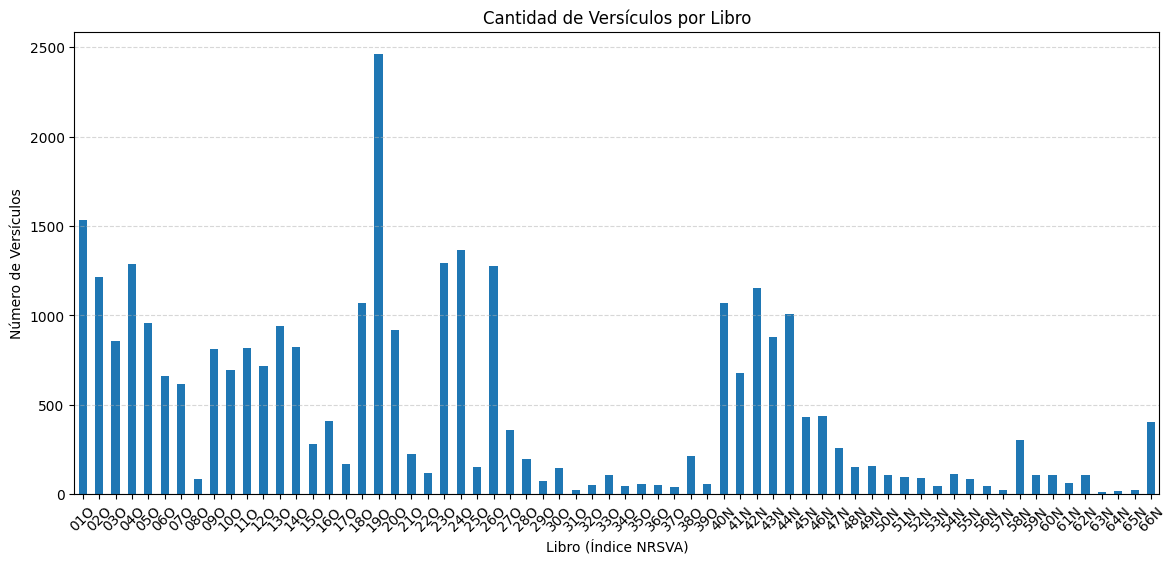

In [35]:
# =================================================================
# Gráfico: Número de versículos por libro
# =================================================================

import matplotlib.pyplot as plt

versiculos_por_libro = df_norm.groupby('nrsva_book_index').size()

plt.figure(figsize=(14, 6))
versiculos_por_libro.plot(kind='bar')

plt.title("Cantidad de Versículos por Libro")
plt.xlabel("Libro (Índice NRSVA)")
plt.ylabel("Número de Versículos")

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()


### Número de capítulos por libro

In [36]:
# =================================================================
# Número de capítulos por libro
# =================================================================

# Contar capítulos únicos dentro de cada libro
capitulos_por_libro = df_norm.groupby('nrsva_book_index')['nrsva_chapter'].nunique()

print("📘 Número de capítulos por libro:")
print(capitulos_por_libro)


📘 Número de capítulos por libro:
nrsva_book_index
01O    50
02O    40
03O    27
04O    36
05O    34
       ..
62N     5
63N     1
64N     1
65N     1
66N    22
Name: nrsva_chapter, Length: 66, dtype: int64


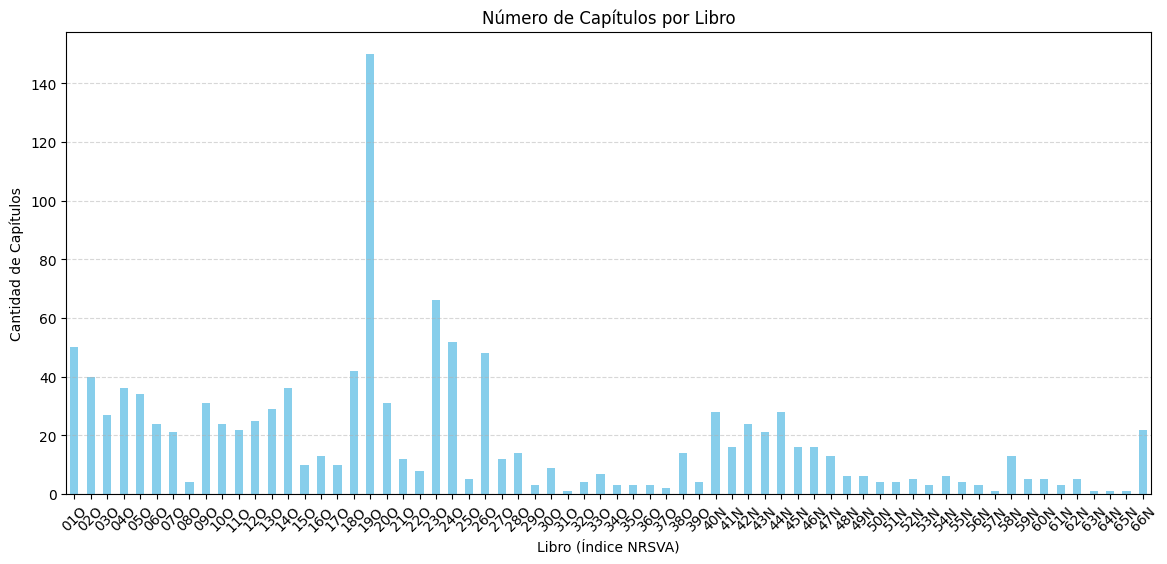

In [37]:
# =================================================================
# Gráfico: Número de capítulos por libro
# =================================================================

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
capitulos_por_libro.plot(kind='bar', color='skyblue')

plt.title("Número de Capítulos por Libro")
plt.xlabel("Libro (Índice NRSVA)")
plt.ylabel("Cantidad de Capítulos")

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()


In [38]:
# =================================================================
# Tabla ordenada de capítulos por libro
# =================================================================

import pandas as pd

tabla_capitulos = capitulos_por_libro.sort_index().reset_index()
tabla_capitulos.columns = ['Libro (NRSVA)', 'Capítulos']

display(tabla_capitulos)


Libro (NRSVA)  Capítulos
0            01O         50
1            02O         40
2            03O         27
3            04O         36
4            05O         34
..           ...        ...
61           62N          5
62           63N          1
63           64N          1
64           65N          1
65           66N         22

[66 rows x 2 columns]

### Calcular las Top N palabras más frecuentes

In [39]:
# =================================================================
# Top N palabras más frecuentes
# =================================================================

from collections import Counter

N = 50  # Cambia este valor para obtener más o menos palabras

# Aplanar lista de palabras útiles
todas_las_palabras_utiles = [pal for lista in df_norm['tokens_no_stop'] for pal in lista]

# Calcular frecuencias
frecuencias = Counter(todas_las_palabras_utiles)

top_n = frecuencias.most_common(N)

print(f"🔝 Top {N} palabras más frecuentes:")
for palabra, freq in top_n:
    print(f"{palabra}: {freq}")


🔝 Top 50 palabras más frecuentes:
señor: 8029
dios: 4473
dijo: 3388
tierra: 3021
hijos: 2844
israel: 2562
rey: 2506
mas: 2353
hijo: 2349
casa: 1987
pueblo: 1823
delante: 1763
si: 1735
entonces: 1724
así: 1691
aquí: 1455
día: 1352
diciendo: 1303
mano: 1288
pues: 1273
toda: 1202
hombre: 1148
david: 1127
todas: 1114
padre: 1101
jesús: 966
hizo: 909
días: 901
corazón: 885
ahora: 879
nombre: 877
cosas: 852
moisés: 842
vino: 831
ciudad: 830
judá: 825
jerusalén: 814
hombres: 789
dos: 788
palabra: 786
mujer: 732
ojos: 732
aquel: 727
oh: 726
hecho: 721
allí: 721
cada: 719
lugar: 718
después: 663
sino: 641


In [40]:
# =================================================================
# Tabla con las Top N palabras más frecuentes
# =================================================================

import pandas as pd

df_top_n = pd.DataFrame(top_n, columns=['Palabra', 'Frecuencia'])
display(df_top_n)


Palabra  Frecuencia
0       señor        8029
1        dios        4473
2        dijo        3388
3      tierra        3021
4       hijos        2844
5      israel        2562
6         rey        2506
7         mas        2353
8        hijo        2349
9        casa        1987
10     pueblo        1823
11    delante        1763
12         si        1735
13   entonces        1724
14        así        1691
15       aquí        1455
16        día        1352
17   diciendo        1303
18       mano        1288
19       pues        1273
20       toda        1202
21     hombre        1148
22      david        1127
23      todas        1114
24      padre        1101
25      jesús         966
26       hizo         909
27       días         901
28    corazón         885
29      ahora         879
30     nombre         877
31      cosas         852
32     moisés         842
33       vino         831
34     ciudad         830
35       judá         825
36  jerusalén         814
37    hombres         789
38        dos         788
39    palabra         786
40      mujer         732
41       ojos         732
42      aquel         727
43         oh         726
44      hecho         721
45       allí         721
46       cada         719
47      lugar         718
48    después         663
49       sino         641

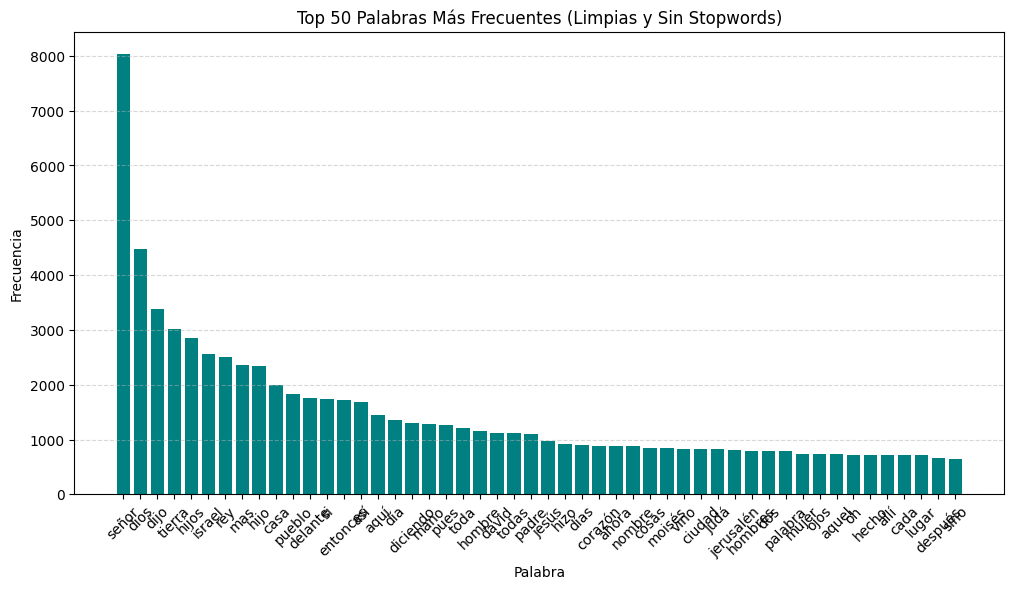

In [41]:
# =================================================================
# Gráfico de barras: Top N palabras más frecuentes
# =================================================================

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(df_top_n['Palabra'], df_top_n['Frecuencia'], color='teal')

plt.title(f"Top {N} Palabras Más Frecuentes (Limpias y Sin Stopwords)")
plt.xlabel("Palabra")
plt.ylabel("Frecuencia")

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()


### Frecuencia de palabras por libro (tabla completa)

In [42]:
# =================================================================
# Ver los índices de libros disponibles en df_norm
# =================================================================

libros_disponibles = sorted(df_norm['nrsva_book_index'].unique())

print(" Libros disponibles (índices NRSVA):")
print(libros_disponibles)


 Libros disponibles (índices NRSVA):
['01O', '02O', '03O', '04O', '05O', '06O', '07O', '08O', '09O', '10O', '11O', '12O', '13O', '14O', '15O', '16O', '17O', '18O', '19O', '20O', '21O', '22O', '23O', '24O', '25O', '26O', '27O', '28O', '29O', '30O', '31O', '32O', '33O', '34O', '35O', '36O', '37O', '38O', '39O', '40N', '41N', '42N', '43N', '44N', '45N', '46N', '47N', '48N', '49N', '50N', '51N', '52N', '53N', '54N', '55N', '56N', '57N', '58N', '59N', '60N', '61N', '62N', '63N', '64N', '65N', '66N']


In [43]:
# =================================================================
# Frecuencia de palabras por libro
# =================================================================

from collections import Counter

# Diccionario: libro → frecuencia de palabras
frecuencias_por_libro = {}

for libro, grupo in df_norm.groupby('nrsva_book_index'):
    palabras = [pal for lista in grupo['tokens_no_stop'] for pal in lista]
    frecuencias_por_libro[libro] = Counter(palabras)

print(" Frecuencias de palabras por libro generadas correctamente.")


 Frecuencias de palabras por libro generadas correctamente.


In [44]:
# =================================================================
# Frecuencia de palabras por libro (seguro)
# =================================================================

from collections import Counter

frecuencias_por_libro = {}

for libro, grupo in df_norm.groupby('nrsva_book_index'):
    palabras = [pal for lista in grupo['tokens_no_stop'] for pal in lista]
    frecuencias_por_libro[libro] = Counter(palabras)

print(" Frecuencias por libro generadas correctamente.")
print(" Libros que tienen datos:", list(frecuencias_por_libro.keys()))


 Frecuencias por libro generadas correctamente.
 Libros que tienen datos: ['01O', '02O', '03O', '04O', '05O', '06O', '07O', '08O', '09O', '10O', '11O', '12O', '13O', '14O', '15O', '16O', '17O', '18O', '19O', '20O', '21O', '22O', '23O', '24O', '25O', '26O', '27O', '28O', '29O', '30O', '31O', '32O', '33O', '34O', '35O', '36O', '37O', '38O', '39O', '40N', '41N', '42N', '43N', '44N', '45N', '46N', '47N', '48N', '49N', '50N', '51N', '52N', '53N', '54N', '55N', '56N', '57N', '58N', '59N', '60N', '61N', '62N', '63N', '64N', '65N', '66N']


In [45]:
# =================================================================
# Selección segura de un libro para mostrar Top N palabras
# =================================================================

N = 20
libro_id = libros_disponibles[0]   # Por ejemplo, elegir el primero automáticamente

print(f" Usando el libro con índice NRSVA: {libro_id}")

top_n_libro = frecuencias_por_libro[libro_id].most_common(N)

print(f"\n Top {N} palabras del libro {libro_id}:")
for palabra, freq in top_n_libro:
    print(f"{palabra}: {freq}")


 Usando el libro con índice NRSVA: 01O

 Top 20 palabras del libro 01O:
tierra: 348
dijo: 338
señor: 240
dios: 232
hijos: 197
padre: 195
jacob: 174
josé: 158
hijo: 157
entonces: 146
aquí: 137
abraham: 133
mujer: 122
años: 112
toda: 106
casa: 101
dio: 99
nombre: 96
faraón: 94
hermano: 92


In [46]:
# =================================================================
# Tabla con las Top N palabras del libro elegido
# =================================================================

import pandas as pd

df_top_n_libro = pd.DataFrame(top_n_libro, columns=["Palabra", "Frecuencia"])
display(df_top_n_libro)


Palabra  Frecuencia
0     tierra         348
1       dijo         338
2      señor         240
3       dios         232
4      hijos         197
5      padre         195
6      jacob         174
7       josé         158
8       hijo         157
9   entonces         146
10      aquí         137
11   abraham         133
12     mujer         122
13      años         112
14      toda         106
15      casa         101
16       dio          99
17    nombre          96
18    faraón          94
19   hermano          92

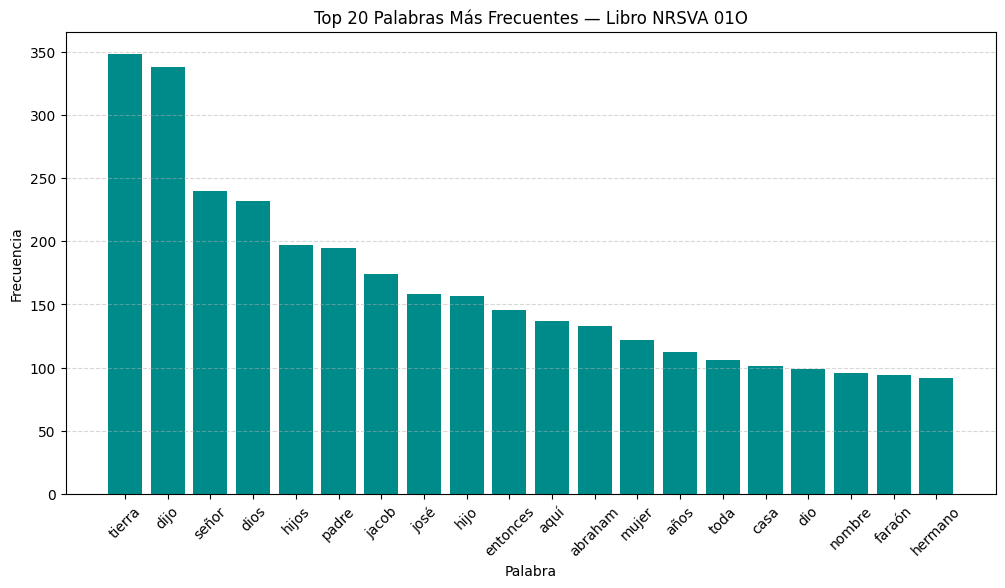

In [47]:
# =================================================================
# Gráfico Top N palabras del libro elegido
# =================================================================

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(df_top_n_libro['Palabra'], df_top_n_libro['Frecuencia'], color='darkcyan')

plt.title(f"Top {N} Palabras Más Frecuentes — Libro NRSVA {libro_id}")
plt.xlabel("Palabra")
plt.ylabel("Frecuencia")

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()


### Frecuencia de palabras por capítulo

In [48]:
# =================================================================
# Frecuencia de palabras por capítulo
# =================================================================

from collections import Counter

frecuencias_por_capitulo = {}

for (libro, cap), grupo in df_norm.groupby(['nrsva_book_index', 'nrsva_chapter']):
    palabras = [pal for lista in grupo['tokens_no_stop'] for pal in lista]
    frecuencias_por_capitulo[(libro, cap)] = Counter(palabras)

print(" Frecuencias generadas correctamente para cada capítulo.")
print("Ejemplo de claves disponibles (libro, capítulo):")
print(list(frecuencias_por_capitulo.keys())[:10])  # Mostrar solo primeros 10


 Frecuencias generadas correctamente para cada capítulo.
Ejemplo de claves disponibles (libro, capítulo):
[('01O', np.int64(1)), ('01O', np.int64(2)), ('01O', np.int64(3)), ('01O', np.int64(4)), ('01O', np.int64(5)), ('01O', np.int64(6)), ('01O', np.int64(7)), ('01O', np.int64(8)), ('01O', np.int64(9)), ('01O', np.int64(10))]


In [49]:
# =================================================================
# Ver capítulos disponibles
# =================================================================

capitulos_disponibles = list(frecuencias_por_capitulo.keys())
capitulos_disponibles[:10]


[('01O', np.int64(1)),
 ('01O', np.int64(2)),
 ('01O', np.int64(3)),
 ('01O', np.int64(4)),
 ('01O', np.int64(5)),
 ('01O', np.int64(6)),
 ('01O', np.int64(7)),
 ('01O', np.int64(8)),
 ('01O', np.int64(9)),
 ('01O', np.int64(10))]

In [50]:
# =================================================================
# Top N palabras de un capítulo
# =================================================================

N = 20

# Seleccionar un capítulo usando un índice válido
libro_id = capitulos_disponibles[0][0]      # Ej: primer libro disponible
capitulo_id = capitulos_disponibles[0][1]   # Ej: primer capítulo disponible

print(f" Analizando Libro {libro_id}, Capítulo {capitulo_id}")

top_n_capitulo = frecuencias_por_capitulo[(libro_id, capitulo_id)].most_common(N)

print(f" Top {N} palabras del libro {libro_id}, capítulo {capitulo_id}:")
for palabra, freq in top_n_capitulo:
    print(f"{palabra}: {freq}")


 Analizando Libro 01O, Capítulo 1
 Top 20 palabras del libro 01O, capítulo 1:
dios: 32
tierra: 21
aguas: 11
cielos: 10
dijo: 10
día: 10
según: 10
extendimiento: 9
naturaleza: 9
vio: 7
toda: 7
luz: 6
tarde: 6
mañana: 6
así: 6
bueno: 6
hierba: 6
simiente: 6
creó: 5
llamó: 5


In [51]:
# =================================================================
# DataFrame de las Top N palabras del capítulo
# =================================================================

import pandas as pd

df_top_n_cap = pd.DataFrame(top_n_capitulo, columns=["Palabra", "Frecuencia"])
display(df_top_n_cap)


Palabra  Frecuencia
0            dios          32
1          tierra          21
2           aguas          11
3          cielos          10
4            dijo          10
5             día          10
6           según          10
7   extendimiento           9
8      naturaleza           9
9             vio           7
10           toda           7
11            luz           6
12          tarde           6
13         mañana           6
14            así           6
15          bueno           6
16         hierba           6
17       simiente           6
18           creó           5
19          llamó           5

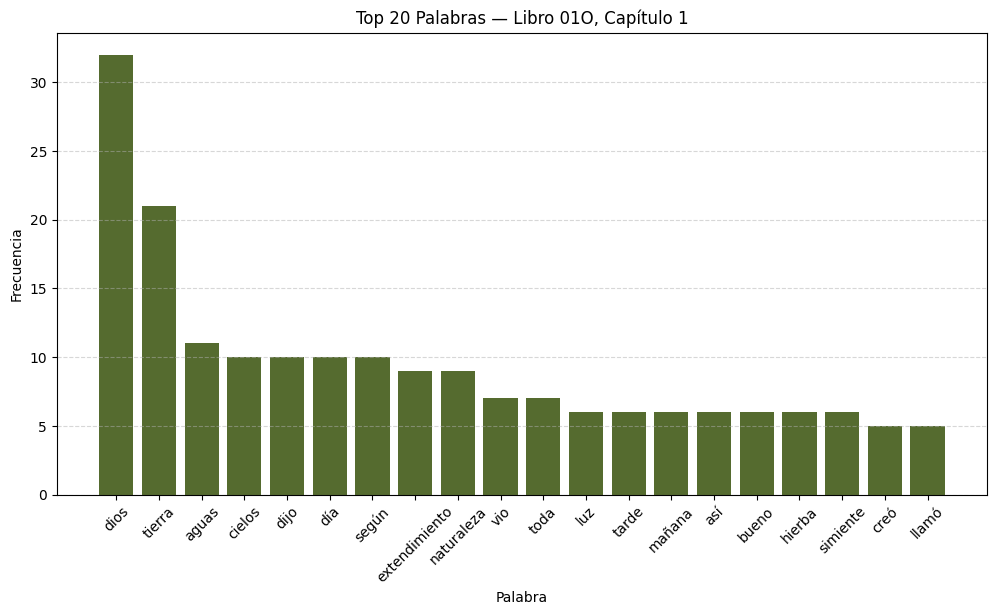

In [52]:
# =================================================================
# Gráfico Top N palabras del capítulo
# =================================================================

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(df_top_n_cap['Palabra'], df_top_n_cap['Frecuencia'], color='darkolivegreen')

plt.title(f"Top {N} Palabras — Libro {libro_id}, Capítulo {capitulo_id}")
plt.xlabel("Palabra")
plt.ylabel("Frecuencia")

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()


### Histograma de frecuencia de palabras (Top N)

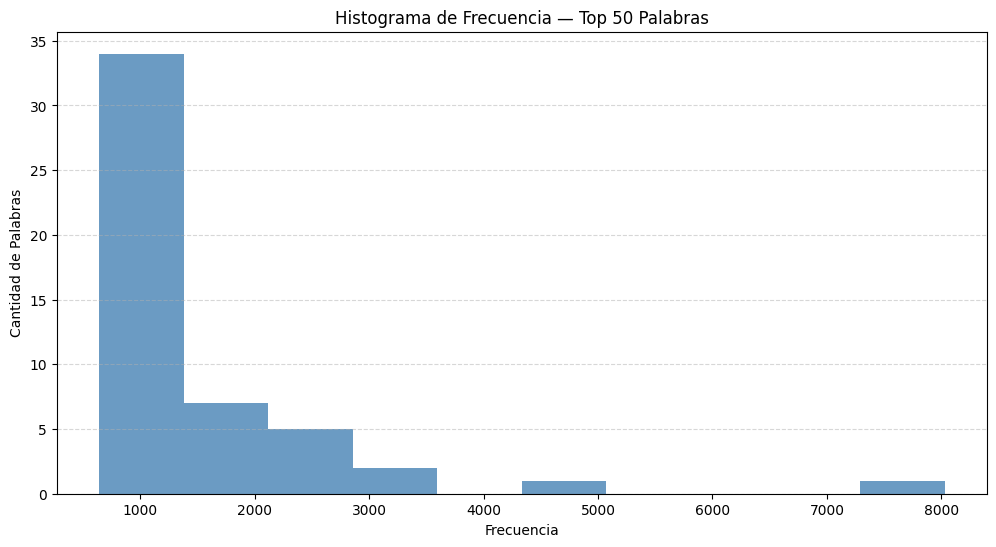

In [53]:
# =================================================================
# Histograma de frecuencia de palabras (Top N)
# =================================================================

from collections import Counter
import matplotlib.pyplot as plt

N = 50  # Cambia para mostrar más o menos palabras

# Aplanar palabras
palabras = [p for lista in df_norm['tokens_no_stop'] for p in lista]

# Frecuencias
frecuencias = Counter(palabras)
top_n = frecuencias.most_common(N)

# Solo los valores de frecuencia
valores = [freq for palabra, freq in top_n]

plt.figure(figsize=(12, 6))
plt.hist(valores, bins=10, color='steelblue', alpha=0.8)

plt.title(f"Histograma de Frecuencia — Top {N} Palabras")
plt.xlabel("Frecuencia")
plt.ylabel("Cantidad de Palabras")

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


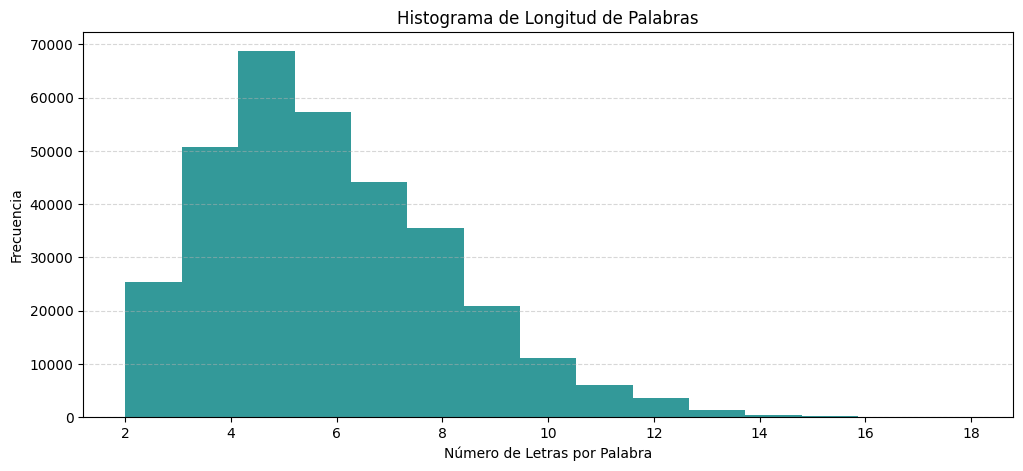

In [54]:
# =================================================================
# Histograma de longitud de palabras
# =================================================================

# Longitud de cada palabra
longitudes_palabras = [len(p) for p in palabras]

plt.figure(figsize=(12, 5))
plt.hist(longitudes_palabras, bins=15, color='teal', alpha=0.8)

plt.title("Histograma de Longitud de Palabras")
plt.xlabel("Número de Letras por Palabra")
plt.ylabel("Frecuencia")

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


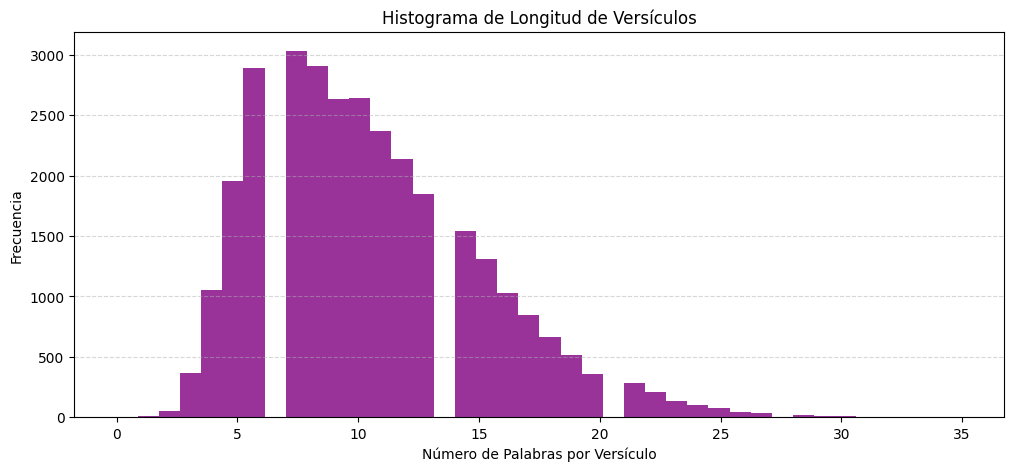

In [55]:
# =================================================================
# Histograma de longitud de versículos
# =================================================================

# Asegurar columna de conteo
df_norm['word_count'] = df_norm['tokens_no_stop'].apply(len)

plt.figure(figsize=(12, 5))
plt.hist(df_norm['word_count'], bins=40, color='purple', alpha=0.8)

plt.title("Histograma de Longitud de Versículos")
plt.xlabel("Número de Palabras por Versículo")
plt.ylabel("Frecuencia")

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


# Definir palabras clave y contar sus frecuencias en todo el corpus

In [56]:
# =================================================================
# Frecuencia total de palabras clave en todo el corpus
# =================================================================

palabras_clave = ["dios", "hombre", "tierra"]  # Puedes agregar más

# Todas las palabras del corpus
todas = [p.lower() for lista in df_norm['tokens_no_stop'] for p in lista]

frecuencia_global = {p: todas.count(p) for p in palabras_clave}

print(" Frecuencia global de palabras clave:")
for palabra, freq in frecuencia_global.items():
    print(f"{palabra}: {freq}")


 Frecuencia global de palabras clave:
dios: 4473
hombre: 1148
tierra: 3021


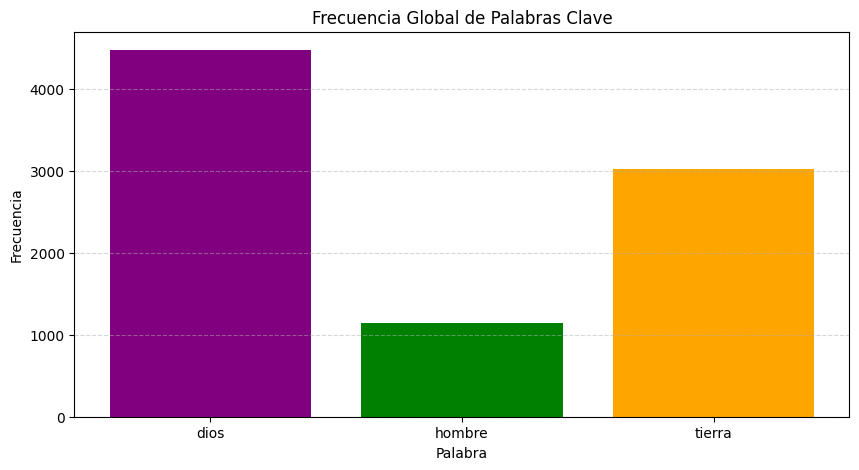

In [57]:
# =================================================================
# Gráfico de frecuencia global de palabras clave
# =================================================================

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(frecuencia_global.keys(), frecuencia_global.values(), color=['purple', 'green', 'orange'])

plt.title("Frecuencia Global de Palabras Clave")
plt.xlabel("Palabra")
plt.ylabel("Frecuencia")

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


In [58]:
# =================================================================
# Frecuencia de palabras clave por libro
# =================================================================

frecuencia_por_libro = {}

for libro, grupo in df_norm.groupby('nrsva_book_index'):
    palabras = [p.lower() for lista in grupo['tokens_no_stop'] for p in lista]
    frecuencia_por_libro[libro] = {clave: palabras.count(clave) for clave in palabras_clave}

print(" Frecuencias por libro generadas.")
frecuencia_por_libro


 Frecuencias por libro generadas.


{'01O': {'dios': 232, 'hombre': 49, 'tierra': 348},
 '02O': {'dios': 119, 'hombre': 16, 'tierra': 147},
 '03O': {'dios': 52, 'hombre': 19, 'tierra': 104},
 '04O': {'dios': 34, 'hombre': 11, 'tierra': 127},
 '05O': {'dios': 348, 'hombre': 32, 'tierra': 247},
 '06O': {'dios': 70, 'hombre': 7, 'tierra': 110},
 '07O': {'dios': 59, 'hombre': 23, 'tierra': 58},
 '08O': {'dios': 3, 'hombre': 1, 'tierra': 4},
 '09O': {'dios': 97, 'hombre': 28, 'tierra': 63},
 '10O': {'dios': 68, 'hombre': 24, 'tierra': 46},
 '11O': {'dios': 95, 'hombre': 9, 'tierra': 60},
 '12O': {'dios': 88, 'hombre': 11, 'tierra': 69},
 '13O': {'dios': 109, 'hombre': 6, 'tierra': 37},
 '14O': {'dios': 184, 'hombre': 12, 'tierra': 69},
 '15O': {'dios': 98, 'hombre': 0, 'tierra': 8},
 '16O': {'dios': 72, 'hombre': 3, 'tierra': 24},
 '17O': {'dios': 0, 'hombre': 1, 'tierra': 2},
 '18O': {'dios': 122, 'hombre': 62, 'tierra': 65},
 '19O': {'dios': 449, 'hombre': 48, 'tierra': 197},
 '20O': {'dios': 11, 'hombre': 116, 'tierra': 23

In [59]:
# =================================================================
# Crear DataFrame: filas = libros, columnas = palabras clave
# =================================================================

import pandas as pd

df_frec_libro = pd.DataFrame.from_dict(frecuencia_por_libro, orient='index')
df_frec_libro.index.name = "Libro (NRSVA)"

display(df_frec_libro)


dios  hombre  tierra
Libro (NRSVA)                      
01O             232      49     348
02O             119      16     147
03O              52      19     104
04O              34      11     127
05O             348      32     247
...             ...     ...     ...
62N              68       0       1
63N               2       0       0
64N               3       0       0
65N               6       0       0
66N              99       6      86

[66 rows x 3 columns]

<Figure size 1400x700 with 0 Axes>

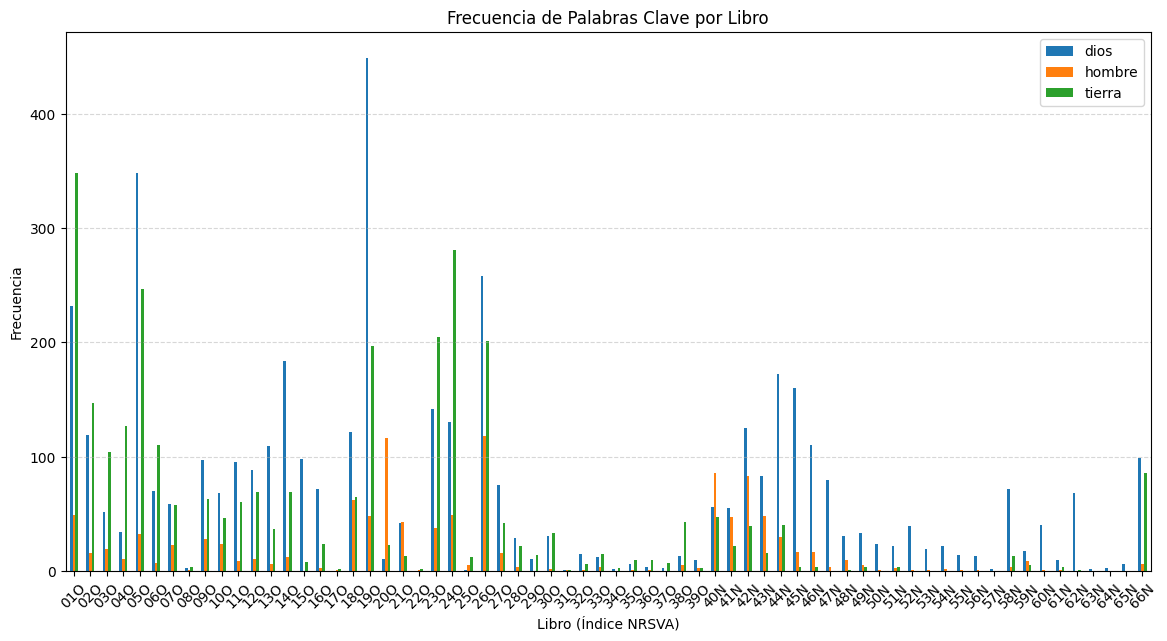

In [60]:
# =================================================================
# Gráfico comparativo por libro
# =================================================================

plt.figure(figsize=(14, 7))
df_frec_libro.plot(kind='bar', figsize=(14, 7))

plt.title("Frecuencia de Palabras Clave por Libro")
plt.xlabel("Libro (Índice NRSVA)")
plt.ylabel("Frecuencia")

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()


### Top N palabras con stopwords

In [61]:
# =================================================================
# Top N palabras CON stopwords
# =================================================================

from collections import Counter

N = 20  # Ajusta la cantidad de palabras a listar

# Aplanar todas las palabras (incluye stopwords)
palabras_con_stop = [p.lower() for lista in df_norm['tokens'] for p in lista]

frecuencias_con_stop = Counter(palabras_con_stop)
top_n_con_stop = frecuencias_con_stop.most_common(N)

print(f" Top {N} palabras CON stopwords:")
for palabra, freq in top_n_con_stop:
    print(f"{palabra}: {freq}")


 Top 20 palabras CON stopwords:
y: 48507
de: 42371
el: 21344
que: 20192
la: 18896
a: 18836
los: 17484
en: 15797
del: 8668
no: 8195
señor: 8029
su: 7967
por: 7221
se: 6143
las: 5541
con: 5518
sus: 5302
para: 5268
al: 5217
dios: 4473


In [62]:
# =================================================================
# Top N palabras SIN stopwords
# =================================================================

# Aplanar palabras útiles (sin stopwords)
palabras_sin_stop = [p.lower() for lista in df_norm['tokens_no_stop'] for p in lista]

frecuencias_sin_stop = Counter(palabras_sin_stop)
top_n_sin_stop = frecuencias_sin_stop.most_common(N)

print(f"\n Top {N} palabras SIN stopwords:")
for palabra, freq in top_n_sin_stop:
    print(f"{palabra}: {freq}")



 Top 20 palabras SIN stopwords:
señor: 8029
dios: 4473
dijo: 3388
tierra: 3021
hijos: 2844
israel: 2562
rey: 2506
mas: 2353
hijo: 2349
casa: 1987
pueblo: 1823
delante: 1763
si: 1735
entonces: 1724
así: 1691
aquí: 1455
día: 1352
diciendo: 1303
mano: 1288
pues: 1273


In [63]:
# =================================================================
# Comparación en DataFrame
# =================================================================

import pandas as pd

df_con = pd.DataFrame(top_n_con_stop, columns=["Palabra_con", "Frecuencia_con"])
df_sin = pd.DataFrame(top_n_sin_stop, columns=["Palabra_sin", "Frecuencia_sin"])

display(df_con)
display(df_sin)


Palabra_con  Frecuencia_con
0            y           48507
1           de           42371
2           el           21344
3          que           20192
4           la           18896
5            a           18836
6          los           17484
7           en           15797
8          del            8668
9           no            8195
10       señor            8029
11          su            7967
12         por            7221
13          se            6143
14         las            5541
15         con            5518
16         sus            5302
17        para            5268
18          al            5217
19        dios            4473

Palabra_sin  Frecuencia_sin
0        señor            8029
1         dios            4473
2         dijo            3388
3       tierra            3021
4        hijos            2844
5       israel            2562
6          rey            2506
7          mas            2353
8         hijo            2349
9         casa            1987
10      pueblo            1823
11     delante            1763
12          si            1735
13    entonces            1724
14         así            1691
15        aquí            1455
16         día            1352
17    diciendo            1303
18        mano            1288
19        pues            1273

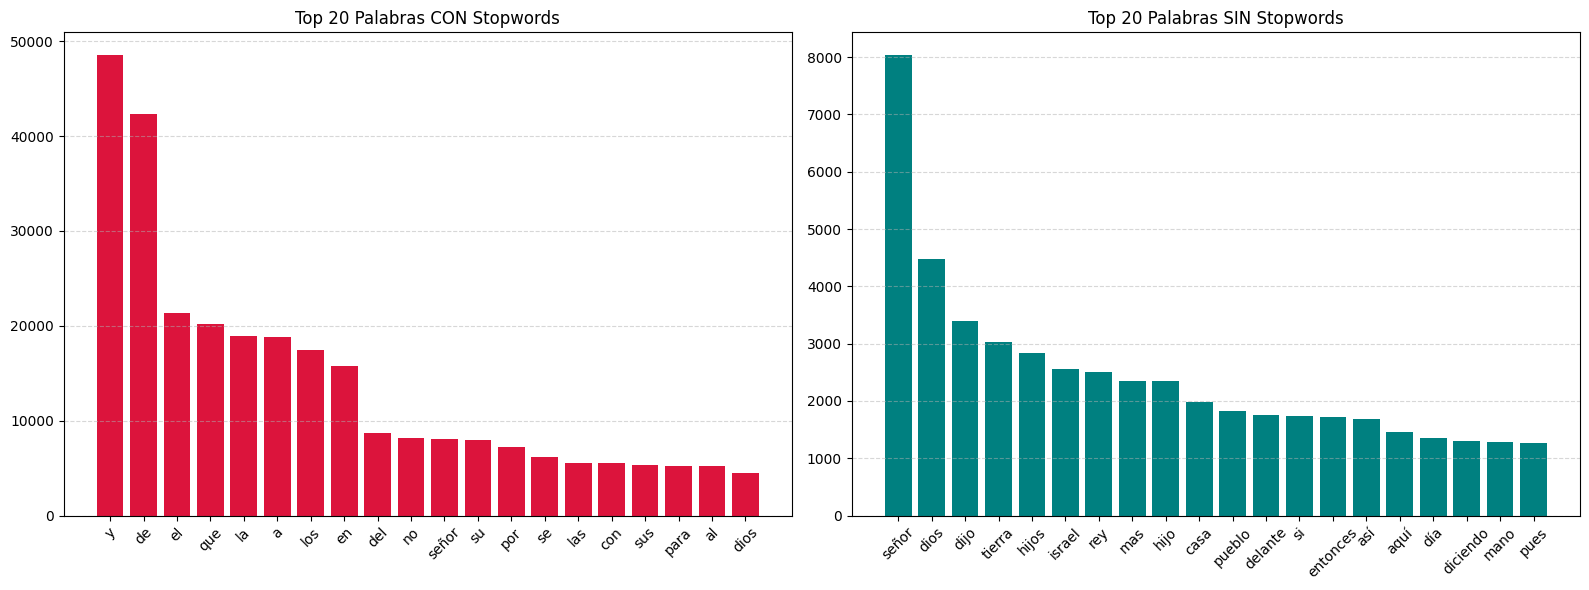

In [64]:
# =================================================================
# Gráficos comparativos lado a lado
# =================================================================

import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))

# --- Gráfico 1: CON stopwords
plt.subplot(1, 2, 1)
plt.bar(df_con['Palabra_con'], df_con['Frecuencia_con'], color='crimson')
plt.title(f"Top {N} Palabras CON Stopwords")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# --- Gráfico 2: SIN stopwords
plt.subplot(1, 2, 2)
plt.bar(df_sin['Palabra_sin'], df_sin['Frecuencia_sin'], color='teal')
plt.title(f"Top {N} Palabras SIN Stopwords")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


### Calcular palabras totales por libro

In [65]:
# =================================================================
# Palabras totales por libro
# =================================================================

from collections import Counter

# Diccionario: libro → total de palabras
palabras_por_libro = {}

for libro, grupo in df_norm.groupby('nrsva_book_index'):
    palabras = [p for lista in grupo['tokens_no_stop'] for p in lista]
    palabras_por_libro[libro] = len(palabras)

print(" Palabras totales por libro calculadas correctamente.\n")
print(palabras_por_libro)


 Palabras totales por libro calculadas correctamente.

{'01O': 16224, '02O': 13276, '03O': 9418, '04O': 13421, '05O': 10762, '06O': 7951, '07O': 7983, '08O': 1027, '09O': 10768, '10O': 9025, '11O': 10681, '12O': 10077, '13O': 9382, '14O': 11146, '15O': 3192, '16O': 4457, '17O': 2509, '18O': 7252, '19O': 17667, '20O': 6626, '21O': 2304, '22O': 1126, '23O': 14664, '24O': 17230, '25O': 1465, '26O': 15259, '27O': 4890, '28O': 1980, '29O': 800, '30O': 1718, '31O': 249, '32O': 545, '33O': 1169, '34O': 508, '35O': 590, '36O': 640, '37O': 518, '38O': 2546, '39O': 684, '40N': 9824, '41N': 6061, '42N': 10204, '43N': 7696, '44N': 10262, '45N': 3879, '46N': 3755, '47N': 2331, '48N': 1264, '49N': 1251, '50N': 869, '51N': 803, '52N': 723, '53N': 407, '54N': 1056, '55N': 719, '56N': 418, '57N': 176, '58N': 2956, '59N': 1051, '60N': 1097, '61N': 705, '62N': 932, '63N': 120, '64N': 146, '65N': 305, '66N': 5029}


In [66]:
# =================================================================
# Tabla: palabras totales por libro
# =================================================================

import pandas as pd

df_palabras_por_libro = pd.DataFrame(
    list(palabras_por_libro.items()),
    columns=["Libro (NRSVA)", "Palabras Totales"]
).sort_values("Libro (NRSVA)").reset_index(drop=True)

display(df_palabras_por_libro)


Libro (NRSVA)  Palabras Totales
0            01O             16224
1            02O             13276
2            03O              9418
3            04O             13421
4            05O             10762
..           ...               ...
61           62N               932
62           63N               120
63           64N               146
64           65N               305
65           66N              5029

[66 rows x 2 columns]

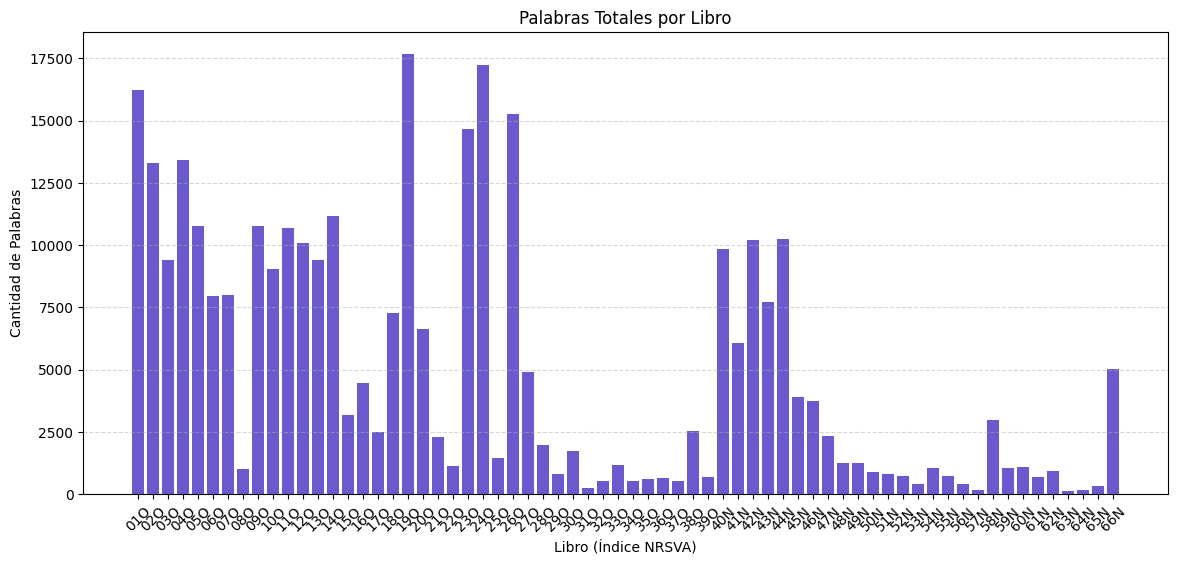

In [67]:
# =================================================================
# Gráfico: Palabras totales por libro
# =================================================================

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.bar(df_palabras_por_libro["Libro (NRSVA)"],
        df_palabras_por_libro["Palabras Totales"],
        color='slateblue')

plt.title("Palabras Totales por Libro")
plt.xlabel("Libro (Índice NRSVA)")
plt.ylabel("Cantidad de Palabras")

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


### Calcular palabras totales por capítulo

In [68]:
# =================================================================
# Palabras totales por capítulo
# =================================================================

palabras_por_capitulo = {}

for (libro, cap), grupo in df_norm.groupby(['nrsva_book_index', 'nrsva_chapter']):
    palabras = [p for lista in grupo['tokens_no_stop'] for p in lista]
    palabras_por_capitulo[(libro, cap)] = len(palabras)

print(" Palabras totales por capítulo calculadas correctamente.")
print("Ejemplo de los primeros elementos:")
list(palabras_por_capitulo.items())[:10]


 Palabras totales por capítulo calculadas correctamente.
Ejemplo de los primeros elementos:


[(('01O', np.int64(1)), 350),
 (('01O', np.int64(2)), 267),
 (('01O', np.int64(3)), 263),
 (('01O', np.int64(4)), 280),
 (('01O', np.int64(5)), 273),
 (('01O', np.int64(6)), 239),
 (('01O', np.int64(7)), 258),
 (('01O', np.int64(8)), 247),
 (('01O', np.int64(9)), 250),
 (('01O', np.int64(10)), 225)]

In [69]:
# =================================================================
# DataFrame: Palabras totales por capítulo
# =================================================================

import pandas as pd

df_palabras_capitulo = pd.DataFrame(
    [(libro, cap, total) for (libro, cap), total in palabras_por_capitulo.items()],
    columns=["Libro (NRSVA)", "Capítulo", "Palabras Totales"]
).sort_values(["Libro (NRSVA)", "Capítulo"]).reset_index(drop=True)

display(df_palabras_capitulo)


Libro (NRSVA)  Capítulo  Palabras Totales
0              01O         1               350
1              01O         2               267
2              01O         3               263
3              01O         4               280
4              01O         5               273
...            ...       ...               ...
1184           66N        18               317
1185           66N        19               272
1186           66N        20               185
1187           66N        21               314
1188           66N        22               236

[1189 rows x 3 columns]

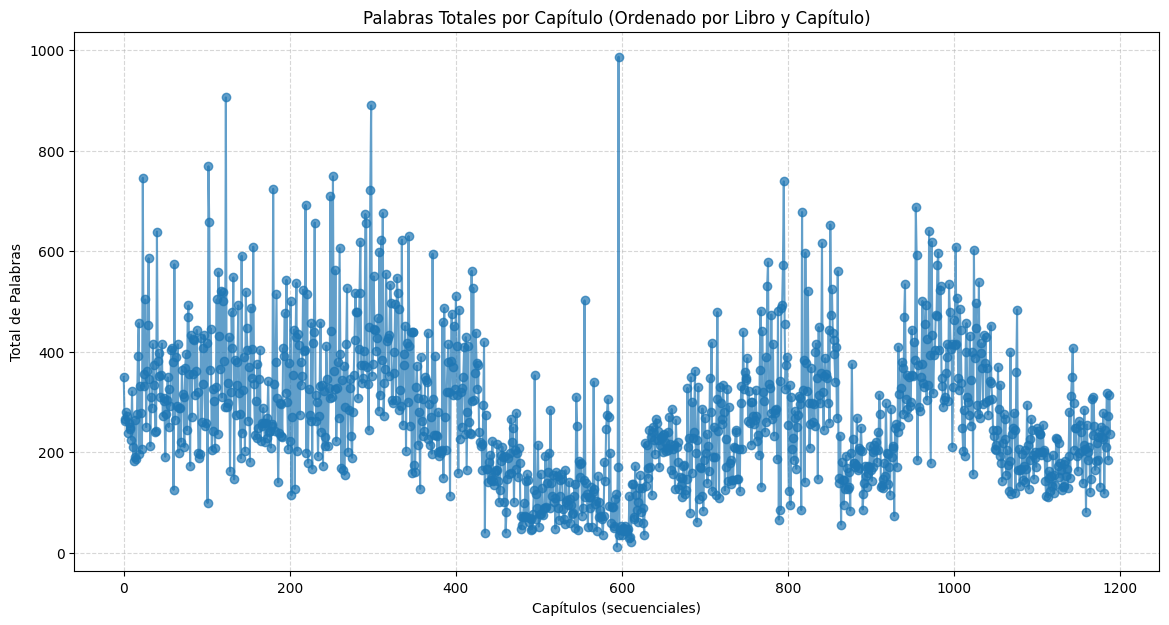

In [70]:
# =================================================================
# Gráfico: Palabras totales por capítulo
# =================================================================

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(df_palabras_capitulo["Palabras Totales"], marker='o', linestyle='-', alpha=0.7)

plt.title("Palabras Totales por Capítulo (Ordenado por Libro y Capítulo)")
plt.xlabel("Capítulos (secuenciales)")
plt.ylabel("Total de Palabras")

plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


### Calcular promedio de palabras por versículo

In [71]:
# =================================================================
# Promedio de palabras por versículo
# =================================================================

# Crear la columna word_count (si no existe)
df_norm['word_count'] = df_norm['tokens_no_stop'].apply(len)

# Calcular el promedio
promedio_palabras_versiculo = df_norm['word_count'].mean()

print(" Promedio de palabras por versículo:", round(promedio_palabras_versiculo, 2))


 Promedio de palabras por versículo: 10.47


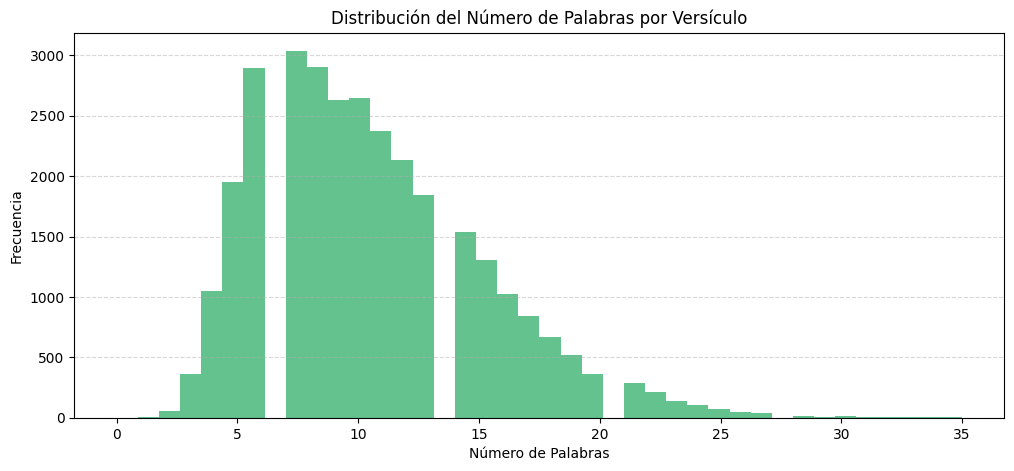

In [72]:
# =================================================================
# Histograma del número de palabras por versículo
# =================================================================

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.hist(df_norm['word_count'], bins=40, color='mediumseagreen', alpha=0.8)

plt.title("Distribución del Número de Palabras por Versículo")
plt.xlabel("Número de Palabras")
plt.ylabel("Frecuencia")

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


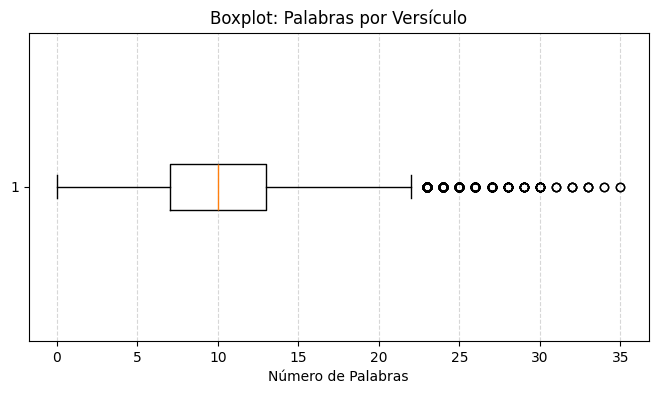

In [73]:
# =================================================================
# Boxplot del número de palabras por versículo
# =================================================================

plt.figure(figsize=(8, 4))
plt.boxplot(df_norm['word_count'], vert=False)

plt.title("Boxplot: Palabras por Versículo")
plt.xlabel("Número de Palabras")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()


### Asegurar columna word_count

In [74]:
# =================================================================
# Asegurar columna de conteo de palabras
# =================================================================

df_norm['word_count'] = df_norm['tokens_no_stop'].apply(len)


### Obtener el versículo más largo por libro

In [75]:
# =================================================================
# Versículo más largo por libro
# =================================================================

versiculo_mas_largo_por_libro = (
    df_norm.loc[df_norm.groupby('nrsva_book_index')['word_count'].idxmax()]
    .sort_values('nrsva_book_index')
    .reset_index(drop=True)
)

display(versiculo_mas_largo_por_libro)


nrsva_book_index  nrsva_chapter  nrsva_verse orig_book_index  orig_chapter  \
0               01O             47           29             01O            47   
1               02O              7           19             02O             7   
2               03O             16           21             03O            16   
3               04O              4           15             04O             4   
4               05O              4           34             05O             4   
..              ...            ...          ...             ...           ...   
61              62N              5           16             62N             5   
62              63N              1           12             63N             1   
63              64N              1           10             64N             1   
64              65N              1           12             65N             1   
65              66N              8           12             66N             8   

    orig_verse  orig_subverse  order_by  \
0           29            NaN     14500   
1           19            NaN     17050   
2           21            NaN     32230   
3           15            NaN     37590   
4           34            NaN     50390   
..         ...            ...       ...   
61          16            NaN    306410   
62          12            NaN    306580   
63          10            NaN    306690   
64          12            NaN    306850   
65          12            NaN    308400   

                                                 text  \
0   Y llegaron los días de Israel para morir, y ll...   
1   Y el SEÑOR dijo a Moisés: Di a Aarón: Toma tu ...   
2   y pondrá Aarón ambas manos suyas sobre la cabe...   
3   Y tan pronto acaben Aarón y sus hijos de cubri...   
4   ¿O ha Dios probado a venir a tomar para sí nac...   
..                                                ...   
61  Si alguno viere pecar a su hermano pecado que ...   
62  ¶ Aunque tengo muchas cosas que escribiros, no...   
63  Por esta causa, si yo fuere, daré a entender l...   
64  Estos son manchas en vuestros convites, que ba...   
65  Y el cuarto ángel tocó la trompeta, y fue heri...   

                                        text_no_noise  \
0   Y llegaron los días de Israel para morir y lla...   
1   Y el SEÑOR dijo a Moisés Di a Aarón Toma tu va...   
2   y pondrá Aarón ambas manos suyas sobre la cabe...   
3   Y tan pronto acaben Aarón y sus hijos de cubri...   
4   O ha Dios probado a venir a tomar para sí naci...   
..                                                ...   
61  Si alguno viere pecar a su hermano pecado que ...   
62  Aunque tengo muchas cosas que escribiros no la...   
63  Por esta causa si yo fuere daré a entender las...   
64  Estos son manchas en vuestros convites que ban...   
65  Y el cuarto ángel tocó la trompeta y fue herid...   

                                           text_lower  \
0   y llegaron los días de israel para morir y lla...   
1   y el señor dijo a moisés di a aarón toma tu va...   
2   y pondrá aarón ambas manos suyas sobre la cabe...   
3   y tan pronto acaben aarón y sus hijos de cubri...   
4   o ha dios probado a venir a tomar para sí naci...   
..                                                ...   
61  si alguno viere pecar a su hermano pecado que ...   
62  aunque tengo muchas cosas que escribiros no la...   
63  por esta causa si yo fuere daré a entender las...   
64  estos son manchas en vuestros convites que ban...   
65  y el cuarto ángel tocó la trompeta y fue herid...   

                                               tokens  \
0   [y, llegaron, los, días, de, israel, para, mor...   
1   [y, el, señor, dijo, a, moisés, di, a, aarón, ...   
2   [y, pondrá, aarón, ambas, manos, suyas, sobre,...   
3   [y, tan, pronto, acaben, aarón, y, sus, hijos,...   
4   [o, ha, dios, probado, a, venir, a, tomar, par...   
..                                                ...   
61  [si, alguno, viere, pecar, a, su, hermano, pec...   
62

In [76]:
# =================================================================
# Versión resumida del versículo más largo por libro
# =================================================================

resumen = versiculo_mas_largo_por_libro[
    ['nrsva_book_index', 'nrsva_chapter', 'nrsva_verse', 'word_count']
]

display(resumen)


nrsva_book_index  nrsva_chapter  nrsva_verse  word_count
0               01O             47           29          25
1               02O              7           19          26
2               03O             16           21          27
3               04O              4           15          28
4               05O              4           34          25
..              ...            ...          ...         ...
61              62N              5           16          18
62              63N              1           12          16
63              64N              1           10          19
64              65N              1           12          23
65              66N              8           12          25

[66 rows x 4 columns]

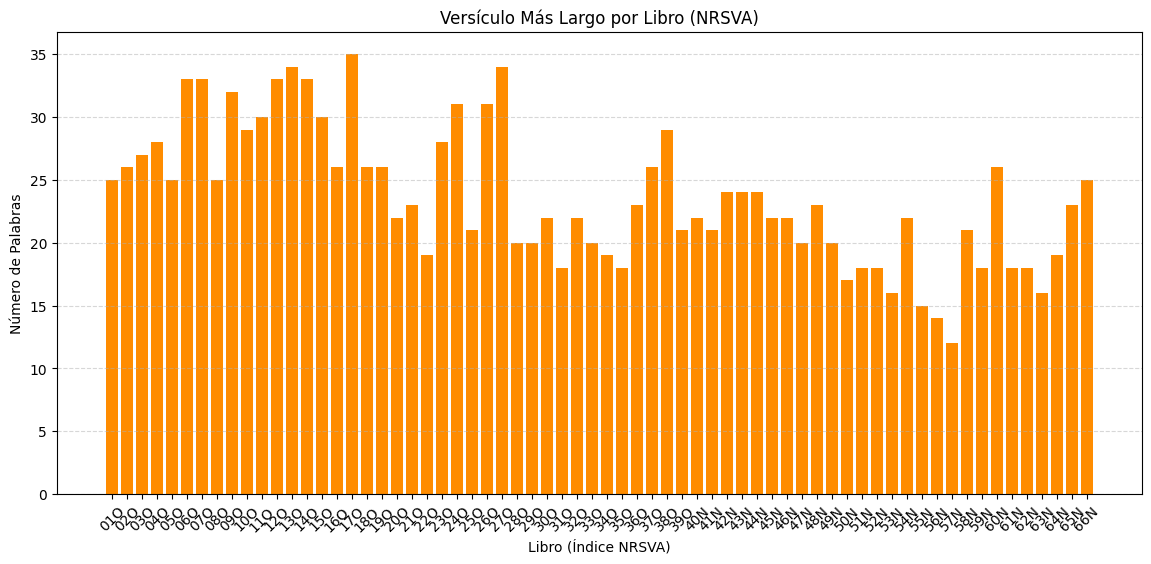

In [77]:
# =================================================================
# Gráfico: longitud del versículo más largo por libro
# =================================================================

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.bar(resumen['nrsva_book_index'], resumen['word_count'], color='darkorange')

plt.title("Versículo Más Largo por Libro (NRSVA)")
plt.xlabel("Libro (Índice NRSVA)")
plt.ylabel("Número de Palabras")

plt.xticks(resumen['nrsva_book_index'], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()


### Asegurar columna word_count

In [78]:
# =================================================================
# Asegurar columna de conteo de palabras
# =================================================================

df_norm['word_count'] = df_norm['tokens_no_stop'].apply(len)


### Obtener el versículo más corto por libro

In [79]:
# =================================================================
# Versículo más corto por libro
# =================================================================

versiculo_mas_corto_por_libro = (
    df_norm.loc[df_norm.groupby('nrsva_book_index')['word_count'].idxmin()]
    .sort_values('nrsva_book_index')
    .reset_index(drop=True)
)

display(versiculo_mas_corto_por_libro)


nrsva_book_index  nrsva_chapter  nrsva_verse orig_book_index  orig_chapter  \
0               01O             10           16             01O            10   
1               02O             20           13             02O            20   
2               03O             10           20             03O            10   
3               04O             18           14             04O            18   
4               05O              5           17             05O             5   
..              ...            ...          ...             ...           ...   
61              62N              2           26             62N             2   
62              63N              1            2             63N             1   
63              64N              1            1             64N             1   
64              65N              1           22             65N             1   
65              66N              2           25             66N             2   

    orig_verse  orig_subverse  order_by  \
0           16            NaN      2510   
1           13            NaN     20650   
2           20            NaN     29980   
3           14            NaN     42720   
4           17            NaN     50710   
..         ...            ...       ...   
61          26            NaN    305770   
62           2            NaN    306480   
63           1            NaN    306600   
64          22            NaN    306950   
65          25            NaN    307430   

                                                 text  \
0               y a Jebusi, y a Amorri, y a Gergesi,    
1                                        No matarás.    
2                    Y Moisés oyó esto, y lo aceptó.    
3                  Todo anatema en Israel será tuyo.    
4                                        No matarás.    
..                                                ...   
61         Os he escrito esto de los que os engañan.    
62  por la verdad que permanece en nosotros, y ser...   
63  ¶ El anciano al amado Gayo, al cual yo amo en ...   
64     Y recibid a los unos en piedad, discerniendo.    
65   Pero la que tenéis, tenedla hasta que yo venga.    

                                        text_no_noise  \
0                   y a Jebusi y a Amorri y a Gergesi   
1                                          No matarás   
2                       Y Moisés oyó esto y lo aceptó   
3                    Todo anatema en Israel será tuyo   
4                                          No matarás   
..                                                ...   
61           Os he escrito esto de los que os engañan   
62  por la verdad que permanece en nosotros y será...   
63  El anciano al amado Gayo al cual yo amo en la ...   
64        Y recibid a los unos en piedad discerniendo   
65      Pero la que tenéis tenedla hasta que yo venga   

                                           text_lower  \
0                   y a jebusi y a amorri y a gergesi   
1                                          no matarás   
2                       y moisés oyó esto y lo aceptó   
3                    todo anatema en israel será tuyo   
4                                          no matarás   
..                                                ...   
61           os he escrito esto de los que os engañan   
62  por la verdad que permanece en nosotros y será...   
63  el anciano al amado gayo al cual yo amo en la ...   
64        y recibid a los unos en piedad discerniendo   
65      pero la que tenéis tenedla hasta que yo venga   

                                               tokens  \
0         [y, a, jebusi, y, a, amorri, y, a, gergesi]   
1                                       [no, matarás]   
2               [y, moisés, oyó, esto, y, lo, aceptó]   
3             [todo, anatema, en, israel, será, tuyo]   
4                                       [no, matarás]   
..                                                ...   
61  [os, he, escrito, esto, de, los, que, os, enga...   
62

In [80]:
# =================================================================
# Resumen del versículo más corto por libro
# =================================================================

resumen_corto = versiculo_mas_corto_por_libro[
    ['nrsva_book_index', 'nrsva_chapter', 'nrsva_verse', 'word_count']
]

display(resumen_corto)


nrsva_book_index  nrsva_chapter  nrsva_verse  word_count
0               01O             10           16           3
1               02O             20           13           1
2               03O             10           20           3
3               04O             18           14           2
4               05O              5           17           1
..              ...            ...          ...         ...
61              62N              2           26           2
62              63N              1            2           3
63              64N              1            1           5
64              65N              1           22           3
65              66N              2           25           2

[66 rows x 4 columns]

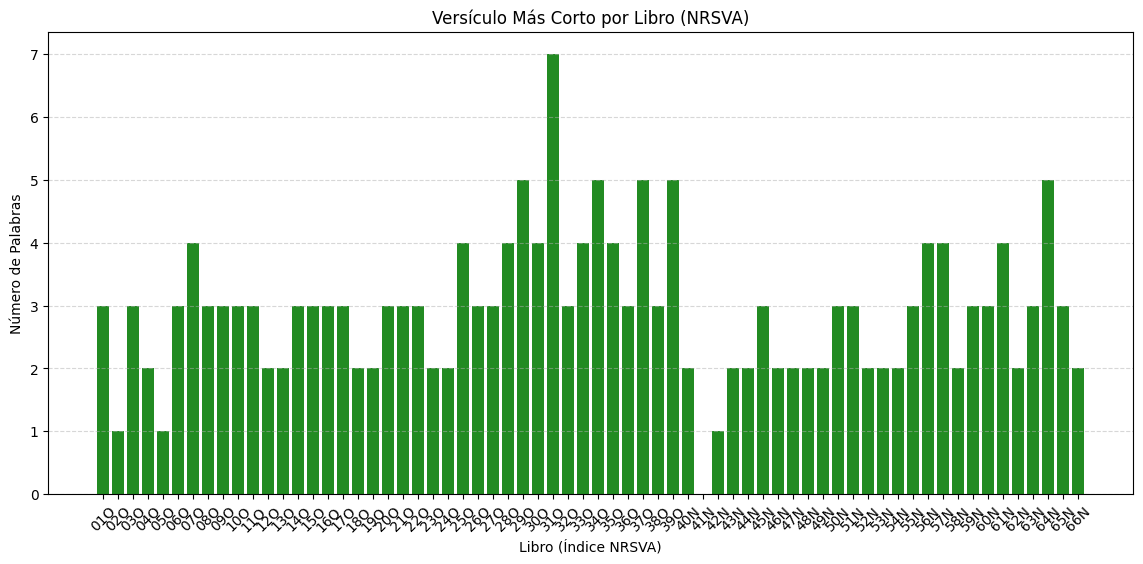

In [81]:
# =================================================================
# Gráfico: Versículo más corto por libro
# =================================================================

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.bar(resumen_corto['nrsva_book_index'], resumen_corto['word_count'], color='forestgreen')

plt.title("Versículo Más Corto por Libro (NRSVA)")
plt.xlabel("Libro (Índice NRSVA)")
plt.ylabel("Número de Palabras")

plt.xticks(resumen_corto['nrsva_book_index'], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()


### Calcular palabras totales por libro

In [82]:
# =================================================================
# Palabras totales por libro
# =================================================================

palabras_por_libro = {}

for libro, grupo in df_norm.groupby('nrsva_book_index'):
    palabras = [p for lista in grupo['tokens_no_stop'] for p in lista]
    palabras_por_libro[libro] = len(palabras)

print(" Palabras totales calculadas correctamente.")


 Palabras totales calculadas correctamente.


In [83]:
# =================================================================
# Libro más extenso y más breve
# =================================================================

# Convertir a DataFrame
import pandas as pd

df_palabras_por_libro = pd.DataFrame(
    list(palabras_por_libro.items()),
    columns=["Libro (NRSVA)", "Palabras Totales"]
)

# Ordenar de mayor a menor
df_ordenado = df_palabras_por_libro.sort_values("Palabras Totales", ascending=False)

libro_mas_extenso = df_ordenado.iloc[0]
libro_mas_breve = df_ordenado.iloc[-1]

print(" Libro más extenso:")
print(libro_mas_extenso)

print("\n Libro más breve:")
print(libro_mas_breve)


 Libro más extenso:
Libro (NRSVA)         19O
Palabras Totales    17667
Name: 18, dtype: object

 Libro más breve:
Libro (NRSVA)       63N
Palabras Totales    120
Name: 62, dtype: object


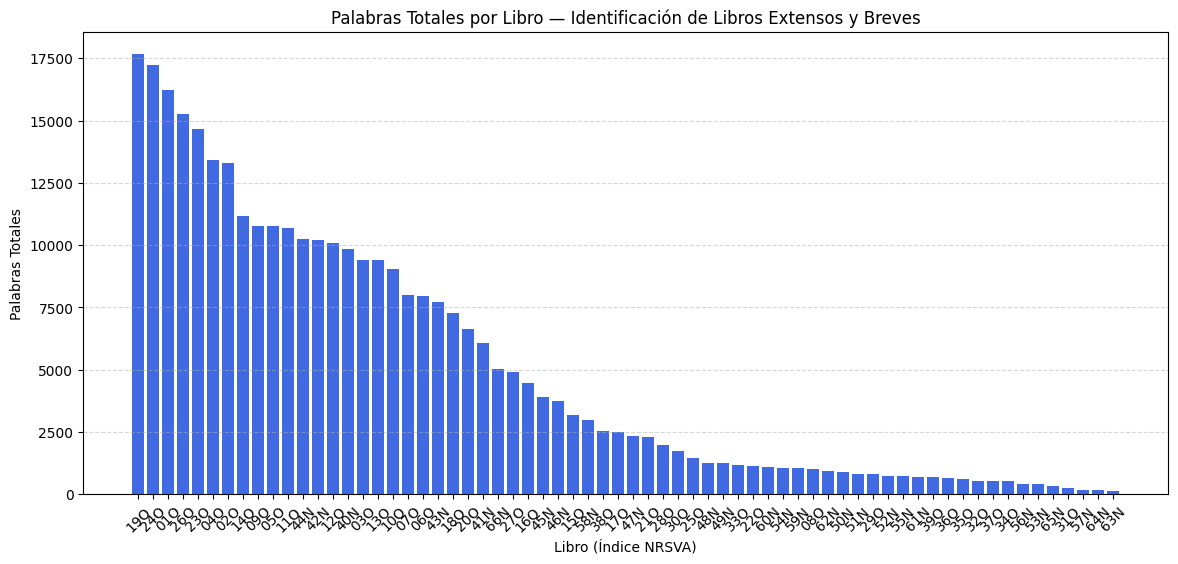

In [84]:
# =================================================================
# Gráfico: Palabras totales por libro
# =================================================================

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.bar(df_ordenado["Libro (NRSVA)"], df_ordenado["Palabras Totales"], color='royalblue')

plt.title("Palabras Totales por Libro — Identificación de Libros Extensos y Breves")
plt.xlabel("Libro (Índice NRSVA)")
plt.ylabel("Palabras Totales")

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


### Asegurar columna word_count

In [85]:
# =================================================================
# Asegurar columna de conteo de palabras por versículo
# =================================================================

df_norm['word_count'] = df_norm['tokens_no_stop'].apply(len)

print("✔ Columna word_count creada correctamente.")


✔ Columna word_count creada correctamente.


In [86]:
# =================================================================
# Densidad promedio de palabras por versículo
# =================================================================

densidad_promedio = df_norm['word_count'].mean()

print(" Densidad promedio de palabras por versículo:", round(densidad_promedio, 2))


 Densidad promedio de palabras por versículo: 10.47


In [87]:
# =================================================================
# Estadísticas descriptivas de la densidad
# =================================================================

print(df_norm['word_count'].describe())


count    31104.000000
mean        10.473508
std          4.543708
min          0.000000
25%          7.000000
50%         10.000000
75%         13.000000
max         35.000000
Name: word_count, dtype: float64


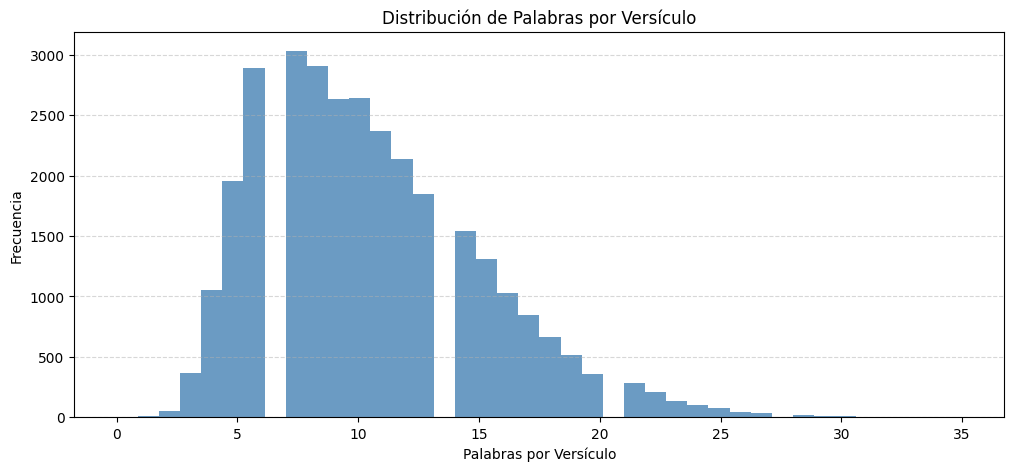

In [88]:
# =================================================================
# Histograma de palabras por versículo
# =================================================================

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.hist(df_norm['word_count'], bins=40, color='steelblue', alpha=0.8)

plt.title("Distribución de Palabras por Versículo")
plt.xlabel("Palabras por Versículo")
plt.ylabel("Frecuencia")

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


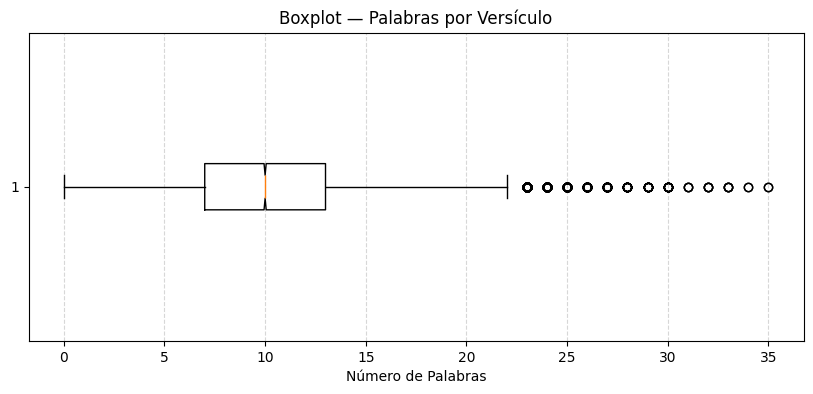

In [89]:
# =================================================================
# Boxplot de palabras por versículo
# =================================================================

plt.figure(figsize=(10, 4))
plt.boxplot(df_norm['word_count'], vert=False, notch=True)

plt.title("Boxplot — Palabras por Versículo")
plt.xlabel("Número de Palabras")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()


### Asegurar columna de longitud de versículo

In [90]:
# =================================================================
# Asegurar columna de longitud de versículos
# =================================================================

df_norm['word_count'] = df_norm['tokens_no_stop'].apply(len)
print("✔ Columna word_count asegurada.")


✔ Columna word_count asegurada.


### Cálculo de longitud promedio por libro

In [91]:
# =================================================================
# Longitud promedio de versículos por libro
# =================================================================

import pandas as pd

longitud_promedio_libro = (
    df_norm.groupby('nrsva_book_index')['word_count']
    .mean()
    .reset_index(name='Promedio_Palabras')
    .sort_values('nrsva_book_index')
)

display(longitud_promedio_libro)


nrsva_book_index  Promedio_Palabras
0               01O          10.583170
1               02O          10.944765
2               03O          10.963912
3               04O          10.420031
4               05O          11.222106
..              ...                ...
61              62N           8.876190
62              63N           9.230769
63              64N           9.733333
64              65N          12.200000
65              66N          12.417284

[66 rows x 2 columns]

/tmp/ipython-input-198186564.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


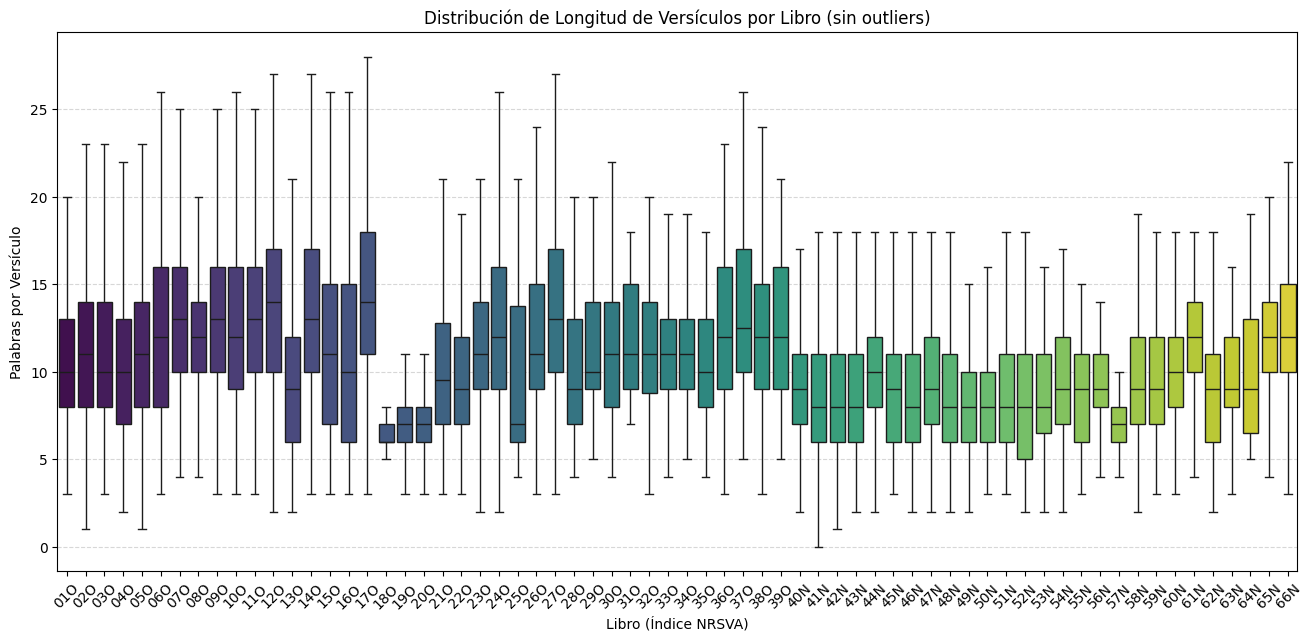

In [92]:
# =================================================================
# Boxplot — Distribución de longitud de versículos por libro
# =================================================================

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 7))
sns.boxplot(
    data=df_norm,
    x='nrsva_book_index',
    y='word_count',
    showfliers=False,     # para evitar ruido visual por outliers
    palette='viridis'
)

plt.title("Distribución de Longitud de Versículos por Libro (sin outliers)")
plt.xlabel("Libro (Índice NRSVA)")
plt.ylabel("Palabras por Versículo")

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()


/tmp/ipython-input-750608725.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


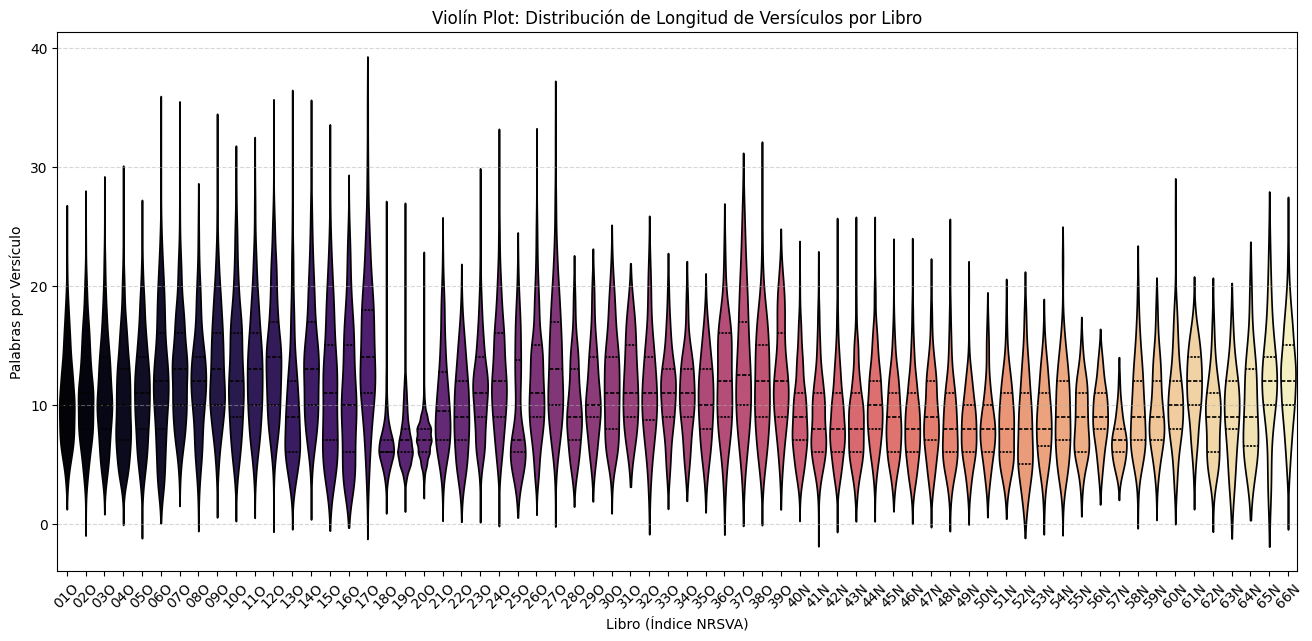

In [93]:
# =================================================================
# Gráfico de violín — Longitud por libro
# =================================================================

plt.figure(figsize=(16, 7))
sns.violinplot(
    data=df_norm,
    x='nrsva_book_index',
    y='word_count',
    inner='quartile',
    palette='magma'
)

plt.title("Violín Plot: Distribución de Longitud de Versículos por Libro")
plt.xlabel("Libro (Índice NRSVA)")
plt.ylabel("Palabras por Versículo")

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()


In [94]:
# =================================================================
# Estadísticas descriptivas de longitud por libro
# =================================================================

estadisticas_libro = (
    df_norm.groupby('nrsva_book_index')['word_count']
    .describe()
    .round(2)
)

display(estadisticas_libro)


count   mean   std  min   25%   50%   75%   max
nrsva_book_index                                                  
01O               1533.0  10.58  3.87  3.0   8.0  10.0  13.0  25.0
02O               1213.0  10.94  4.14  1.0   8.0  11.0  14.0  26.0
03O                859.0  10.96  4.25  3.0   8.0  10.0  14.0  27.0
04O               1288.0  10.42  4.40  2.0   7.0  10.0  13.0  28.0
05O                959.0  11.22  4.39  1.0   8.0  11.0  14.0  25.0
...                  ...    ...   ...  ...   ...   ...   ...   ...
62N                105.0   8.88  3.40  2.0   6.0   9.0  11.0  18.0
63N                 13.0   9.23  3.54  3.0   8.0   9.0  12.0  16.0
64N                 15.0   9.73  4.04  5.0   6.5   9.0  13.0  19.0
65N                 25.0  12.20  4.69  3.0  10.0  12.0  14.0  23.0
66N                405.0  12.42  4.12  2.0  10.0  12.0  15.0  25.0

[66 rows x 8 columns]

### Preparar tokens para N-grams

In [95]:
# =================================================================
# Preparar tokens para N-grams
# =================================================================

# Obtener todas las palabras útiles
tokens = [palabra for lista in df_norm['tokens_no_stop'] for palabra in lista]

print(f"✔ Total de palabras procesadas: {len(tokens)}")


✔ Total de palabras procesadas: 325768


### Función genérica para generar N-grams

In [96]:
# =================================================================
# Función para generar N-grams
# =================================================================

from collections import Counter

def generar_ngrams(tokens, n):
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return Counter([" ".join(ngram) for ngram in ngrams])


### Bigramas (2-grams)

In [97]:
# =================================================================
# Bigramas
# =================================================================

bigrams = generar_ngrams(tokens, 2)
top_bigrams = bigrams.most_common(20)

print(" Top 20 BIGRAMAS:")
for bg, freq in top_bigrams:
    print(f"{bg}: {freq}")


 Top 20 BIGRAMAS:
señor dios: 1268
dijo señor: 799
hijos israel: 660
así dijo: 363
todas cosas: 329
delante señor: 295
palabra señor: 276
oh señor: 271
casa señor: 265
señor ejércitos: 245
señor dijo: 225
tierra egipto: 225
dios israel: 220
toda tierra: 210
hijo hombre: 199
aquel día: 196
jesús cristo: 196
dice señor: 183
rey israel: 175
tabernáculo testimonio: 157


### BLOQUE 4 — Trigramas (3-grams)

In [98]:
# =================================================================
# Trigramas
# =================================================================

trigrams = generar_ngrams(tokens, 3)
top_trigrams = trigrams.most_common(20)

print(" Top 20 TRIGRAMAS:")
for tg, freq in top_trigrams:
    print(f"{tg}: {freq}")


 Top 20 TRIGRAMAS:
así dijo señor: 350
dijo señor dios: 261
señor dios israel: 120
dijo señor ejércitos: 102
vino palabra señor: 99
señor jesús cristo: 89
palabra señor diciendo: 62
habló señor moisés: 60
señor dijo moisés: 56
señor moisés diciendo: 48
nabucodonosor rey babilonia: 47
diciendo hijo hombre: 47
malo ojos señor: 46
puerta tabernáculo testimonio: 44
señor diciendo hijo: 44
señor ejércitos dios: 43
ejércitos dios israel: 42
señor dios padres: 41
delante señor dios: 39
tierra señor dios: 39


###BLOQUE 5 — 4-grams

In [99]:
# =================================================================
# 4-grams
# =================================================================

fourgrams = generar_ngrams(tokens, 4)
top_fourgrams = fourgrams.most_common(20)

print(" Top 20 4-GRAMS:")
for fg, freq in top_fourgrams:
    print(f"{fg}: {freq}")


 Top 20 4-GRAMS:
así dijo señor dios: 152
así dijo señor ejércitos: 64
vino palabra señor diciendo: 57
habló señor moisés diciendo: 44
palabra señor diciendo hijo: 44
señor diciendo hijo hombre: 44
señor ejércitos dios israel: 39
diciendo así dijo señor: 32
señor así dijo señor: 30
escrito libro crónicas reyes: 30
dijo señor ejércitos dios: 30
dijo señor dios aquí: 28
hizo malo ojos señor: 28
señor habló moisés diciendo: 26
tierra señor dios da: 26
así dijo señor aquí: 25
diciendo habla hijos israel: 23
toda congregación hijos israel: 23
dijo señor dios israel: 23
flor harina amasada aceite: 23


###Convertir resultados a DataFrames

In [100]:
# =================================================================
# Convertir N-grams a DataFrames
# =================================================================

import pandas as pd

df_bigrams = pd.DataFrame(top_bigrams, columns=["Bigram", "Frecuencia"])
df_trigrams = pd.DataFrame(top_trigrams, columns=["Trigram", "Frecuencia"])
df_fourgrams = pd.DataFrame(top_fourgrams, columns=["4-gram", "Frecuencia"])

display(df_bigrams)
display(df_trigrams)
display(df_fourgrams)


Bigram  Frecuencia
0               señor dios        1268
1               dijo señor         799
2             hijos israel         660
3                 así dijo         363
4              todas cosas         329
5            delante señor         295
6            palabra señor         276
7                 oh señor         271
8               casa señor         265
9          señor ejércitos         245
10              señor dijo         225
11           tierra egipto         225
12             dios israel         220
13             toda tierra         210
14             hijo hombre         199
15               aquel día         196
16            jesús cristo         196
17              dice señor         183
18              rey israel         175
19  tabernáculo testimonio         157

Trigram  Frecuencia
0                  así dijo señor         350
1                 dijo señor dios         261
2               señor dios israel         120
3            dijo señor ejércitos         102
4              vino palabra señor          99
5              señor jesús cristo          89
6          palabra señor diciendo          62
7              habló señor moisés          60
8               señor dijo moisés          56
9           señor moisés diciendo          48
10    nabucodonosor rey babilonia          47
11           diciendo hijo hombre          47
12                malo ojos señor          46
13  puerta tabernáculo testimonio          44
14            señor diciendo hijo          44
15           señor ejércitos dios          43
16          ejércitos dios israel          42
17              señor dios padres          41
18             delante señor dios          39
19              tierra señor dios          39

4-gram  Frecuencia
0              así dijo señor dios         152
1         así dijo señor ejércitos          64
2      vino palabra señor diciendo          57
3      habló señor moisés diciendo          44
4      palabra señor diciendo hijo          44
5       señor diciendo hijo hombre          44
6      señor ejércitos dios israel          39
7          diciendo así dijo señor          32
8             señor así dijo señor          30
9     escrito libro crónicas reyes          30
10       dijo señor ejércitos dios          30
11            dijo señor dios aquí          28
12            hizo malo ojos señor          28
13     señor habló moisés diciendo          26
14            tierra señor dios da          26
15             así dijo señor aquí          25
16     diciendo habla hijos israel          23
17  toda congregación hijos israel          23
18          dijo señor dios israel          23
19      flor harina amasada aceite          23

###Instalar spaCy y el modelo en español

In [101]:
# =================================================================
# Instalación de spaCy y modelo de español
# =================================================================

!pip install -U spacy

# Descargar modelo pequeño de español
!python -m spacy download es_core_news_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 74.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


### Cargar spaCy y el modelo de español

In [102]:
# =================================================================
# Carga de spaCy y modelo de español
# =================================================================

import spacy

# Cargar el modelo de español
nlp = spacy.load("es_core_news_sm")

print(" Modelo de spaCy en español cargado correctamente.")


 Modelo de spaCy en español cargado correctamente.


### Función de lematización para una lista de tokens

In [103]:
# =================================================================
# Función para lematizar una lista de tokens
# =================================================================

def lematizar_lista(tokens):
    """
    Recibe una lista de tokens (palabras) y devuelve una lista de lemas.
    """
    # Unir tokens en un solo texto
    texto = " ".join(tokens)

    # Procesar con spaCy
    doc = nlp(texto)

    # Extraer lemas (evitando espacios y signos)
    lemas = [token.lemma_ for token in doc if token.is_alpha]

    return lemas


### Aplicar lematización al DataFrame

In [104]:
# =================================================================
# Aplicar lematización a cada versículo
# =================================================================

# Verificación básica
if 'tokens_no_stop' not in df_norm.columns:
    raise ValueError(" La columna 'tokens_no_stop' no existe. Asegúrate de haber ejecutado la normalización antes.")

# Aplicar a todo el DataFrame (puede tardar un poco)
df_norm['lemmas'] = df_norm['tokens_no_stop'].apply(lematizar_lista)

# Reconstruir el texto lematizado
df_norm['text_lemmatized'] = df_norm['lemmas'].apply(lambda lst: " ".join(lst))

print(" Lematización completada.")
print("\nEjemplo de la primera fila:\n")
print("Tokens sin stopwords :", df_norm['tokens_no_stop'].iloc[0][:20])
print("Lemas                 :", df_norm['lemmas'].iloc[0][:20])
print("Texto lematizado      :", df_norm['text_lemmatized'].iloc[0][:200])


 Lematización completada.

Ejemplo de la primera fila:

Tokens sin stopwords : ['principio', 'creó', 'dios', 'cielos', 'tierra']
Lemas                 : ['principio', 'crear', 'dio', 'cielo', 'tierra']
Texto lematizado      : principio crear dio cielo tierra


### Top N lemas más frecuentes

In [105]:
# =================================================================
# Top N lemas más frecuentes
# =================================================================

from collections import Counter

N = 30

todos_los_lemas = [lemma for lista in df_norm['lemmas'] for lemma in lista]
frecuencias_lemas = Counter(todos_los_lemas)
top_lemas = frecuencias_lemas.most_common(N)

print(f" Top {N} lemas más frecuentes:")
for lem, freq in top_lemas:
    print(f"{lem}: {freq}")


 Top 30 lemas más frecuentes:
señor: 8074
decir: 6866
hijo: 5090
hacer: 3295
tierra: 3071
dios: 2736
rey: 2618
israel: 2562
mas: 2350
todo: 2315
día: 2222
casa: 2082
pueblo: 2075
venir: 1977
dio: 1945
dar: 1891
hombre: 1858
mano: 1823
delante: 1763
si: 1735
entonces: 1724
así: 1691
aquí: 1455
padre: 1355
palabra: 1281
pues: 1273
ciudad: 1271
ver: 1259
aquel: 1252
cosa: 1177


#### Asegurar instalación y carga del modelo spaCy en español

In [106]:
# =================================================================
# Instalación de spaCy y modelo de español
# =================================================================

!pip install -U spacy
!python -m spacy download es_core_news_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 36.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


### Cargar spaCy con POS-tagging

In [107]:
# =================================================================
# Cargar spaCy con modelo de español
# =================================================================

import spacy
nlp = spacy.load("es_core_news_sm")

print(" Modelo spaCy cargado con POS-tagging.")


 Modelo spaCy cargado con POS-tagging.


### Función para etiquetar POS en una lista de tokens

In [108]:
# =================================================================
# Función que aplica POS-tagging a una lista de tokens
# =================================================================

def pos_tags(tokens):
    texto = " ".join(tokens)
    doc = nlp(texto)
    return [(token.text, token.lemma_, token.pos_) for token in doc if token.is_alpha]


###Aplicar POS-tagging a cada versículo

In [109]:
# =================================================================
# Aplicar POS-tagging a cada versículo
# =================================================================

df_norm['pos_tags'] = df_norm['tokens_no_stop'].apply(pos_tags)

print("✔ POS-tagging aplicado correctamente.")
print(df_norm['pos_tags'].iloc[0][:20])  # Mostrar ejemplo


✔ POS-tagging aplicado correctamente.
[('principio', 'principio', 'NOUN'), ('creó', 'crear', 'VERB'), ('dios', 'dio', 'NOUN'), ('cielos', 'cielo', 'ADJ'), ('tierra', 'tierra', 'NOUN')]


### Conteo de verbos, sustantivos y adjetivos

In [110]:
# =================================================================
# Conteo global de verbos, sustantivos y adjetivos
# =================================================================

from collections import Counter

contador_pos = Counter()

for lista in df_norm['pos_tags']:
    for _, _, pos in lista:
        contador_pos[pos] += 1

verbos = contador_pos['VERB']
sustantivos = contador_pos['NOUN'] + contador_pos['PROPN']   # Sustantivo común + propio
adjetivos = contador_pos['ADJ']

print(" CONTEO GRAMATICAL GLOBAL")
print("-----------------------------")
print(f"Verbos (VERB):        {verbos}")
print(f"Sustantivos (NOUN+PROPN): {sustantivos}")
print(f"Adjetivos (ADJ):      {adjetivos}")


 CONTEO GRAMATICAL GLOBAL
-----------------------------
Verbos (VERB):        76501
Sustantivos (NOUN+PROPN): 141385
Adjetivos (ADJ):      60150


 #### Tabla comparativa

In [111]:
# =================================================================
# Tabla con los conteos gramaticales
# =================================================================

import pandas as pd

df_pos_global = pd.DataFrame({
    "Categoría gramatical": ["Verbos", "Sustantivos", "Adjetivos"],
    "Cantidad": [verbos, sustantivos, adjetivos]
})

display(df_pos_global)


Categoría gramatical  Cantidad
0               Verbos     76501
1          Sustantivos    141385
2            Adjetivos     60150

###Gráfico comparativo

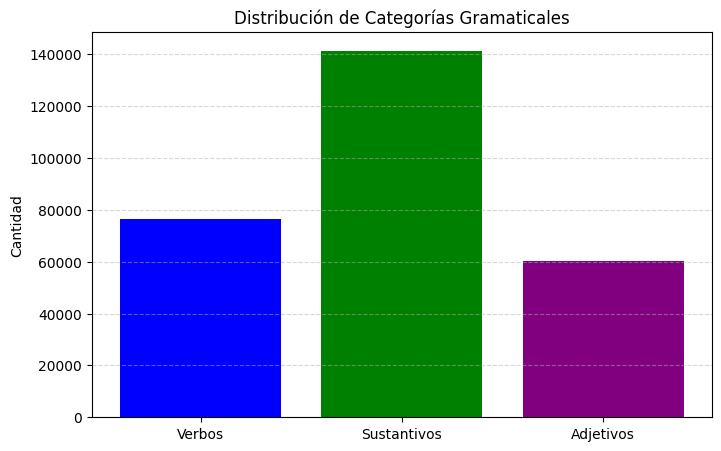

In [112]:
# =================================================================
# Gráfico de barras comparativo POS
# =================================================================

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(["Verbos", "Sustantivos", "Adjetivos"],
        [verbos, sustantivos, adjetivos],
        color=['blue', 'green', 'purple'])

plt.title("Distribución de Categorías Gramaticales")
plt.ylabel("Cantidad")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


### Vocabulario Unico

In [113]:
# =================================================================
# Vocabulario único a partir de tokens_no_stop
# =================================================================

# Aplanar todas las palabras útiles
todas_las_palabras = [pal for lista in df_norm['tokens_no_stop'] for pal in lista]

# Construir el vocabulario único
vocabulario_unico = sorted(set(todas_las_palabras))

print(" Tamaño del vocabulario único:", len(vocabulario_unico))
print("\nEjemplo de las primeras 50 palabras del vocabulario:")
print(vocabulario_unico[:50])


 Tamaño del vocabulario único: 24875

Ejemplo de las primeras 50 palabras del vocabulario:
['aaronitas', 'aarón', 'abaca', 'abadón', 'abagta', 'abaja', 'abajada', 'abajadas', 'abajado', 'abajare', 'abaje', 'abajo', 'abana', 'abanderado', 'abandona', 'abandonado', 'abandonan', 'abandonaremos', 'abandonarán', 'abandonaste', 'abarim', 'abastecer', 'abastecerás', 'abastecidas', 'abastecían', 'abasto', 'abate', 'abates', 'abatida', 'abatidas', 'abatido', 'abatidos', 'abatimiento', 'abatir', 'abatirlos', 'abatirá', 'abatirán', 'abatiré', 'abatiste', 'abatió', 'abatí', 'abatían', 'abba', 'abda', 'abdeel', 'abdi', 'abdiel', 'abdías', 'abdón', 'abed']


In [114]:
# =================================================================
# Diccionarios word2id e id2word
# =================================================================

word2id = {palabra: idx for idx, palabra in enumerate(vocabulario_unico)}
id2word = {idx: palabra for palabra, idx in word2id.items()}

print("✔ Diccionarios de vocabulario construidos.")
print("Ejemplo:")
for i in range(10):
    print(i, "->", id2word[i])


✔ Diccionarios de vocabulario construidos.
Ejemplo:
0 -> aaronitas
1 -> aarón
2 -> abaca
3 -> abadón
4 -> abagta
5 -> abaja
6 -> abajada
7 -> abajadas
8 -> abajado
9 -> abajare


In [115]:
# =================================================================
# Vocabulario con frecuencia
# =================================================================

from collections import Counter
import pandas as pd

frecuencias_vocab = Counter(todas_las_palabras)

df_vocabulario = (
    pd.DataFrame(
        [(pal, freq, word2id[pal]) for pal, freq in frecuencias_vocab.items()],
        columns=["Palabra", "Frecuencia", "ID"]
    )
    .sort_values("Frecuencia", ascending=False)
    .reset_index(drop=True)
)

display(df_vocabulario.head(30))
print("\n✔ Vocabulario con frecuencia construido. Filas totales:", len(df_vocabulario))


Palabra  Frecuencia     ID
0      señor        8029  21947
1       dios        4473   8140
2       dijo        3388   8105
3     tierra        3021  23128
4      hijos        2844  12469
5     israel        2562  13472
6        rey        2506  20731
7        mas        2353  15224
8       hijo        2349  12468
9       casa        1987   4335
10    pueblo        1823  19169
11   delante        1763   7009
12        si        1735  21970
13  entonces        1724   9681
14       así        1691   2791
15      aquí        1455   2293
16       día        1352   8521
17  diciendo        1303   8023
18      mano        1288  15113
19      pues        1273  19186
20      toda        1202  23225
21    hombre        1148  12577
22     david        1127   6730
23     todas        1114  23226
24     padre        1101  17137
25     jesús         966  13677
26      hizo         909  12525
27      días         901   8522
28   corazón         885   6054
29     ahora         879   1079


✔ Vocabulario con frecuencia construido. Filas totales: 24875


In [116]:
# =================================================================
# Guardar vocabulario a CSV
# =================================================================

df_vocabulario.to_csv("vocabulario_unico_con_frecuencia.csv", index=False, encoding="utf-8")
print(" Archivo 'vocabulario_unico_con_frecuencia.csv' guardado en el entorno de trabajo.")


 Archivo 'vocabulario_unico_con_frecuencia.csv' guardado en el entorno de trabajo.


In [117]:
# =================================================================
# Vocabulario único basado en lemas (opcional)
# =================================================================

todas_los_lemas = [lem for lista in df_norm['lemmas'] for lem in lista]
vocabulario_lemas = sorted(set(todas_los_lemas))

print(" Tamaño del vocabulario único (lemas):", len(vocabulario_lemas))
print(vocabulario_lemas[:50])


 Tamaño del vocabulario único (lemas): 19979
['aaronitas', 'aarón', 'abacar', 'abadón', 'abagta', 'abajada', 'abajado', 'abajar', 'abajare', 'abaje', 'abajo', 'abanderar', 'abandonado', 'abandonar', 'abandonaremo', 'abandonaste', 'abarim', 'abastecer', 'abastecerás', 'abastecida', 'abasto', 'abat', 'abatar', 'abate', 'abateír', 'abatido', 'abatier', 'abatimiento', 'abatir', 'abatirlo', 'abatiré', 'abatiste', 'abatí', 'abbar', 'abda', 'abdeel', 'abdi', 'abdiel', 'abdía', 'abdías', 'abdón', 'abed', 'abeja', 'abejo', 'abel', 'aber', 'abertura', 'aberturar', 'abez', 'abi']


###Construir texto limpio por libro

In [118]:
# =================================================================
# Construir corpus por libro
# =================================================================

import pandas as pd

# Convertir tokens sin stopwords a texto
df_norm['text_no_stop'] = df_norm['tokens_no_stop'].apply(lambda x: " ".join(x))

# Agrupar textos por libro
corpus_por_libro = (
    df_norm.groupby('nrsva_book_index')['text_no_stop']
    .apply(lambda textos: " ".join(textos))
)

print(" Total de libros procesados:", len(corpus_por_libro))
corpus_por_libro.head()


 Total de libros procesados: 66


nrsva_book_index
01O    principio creó dios cielos tierra tierra desor...
02O    nombres hijos israel entraron egipto jacob cad...
03O    llamó señor moisés habló tabernáculo testimoni...
04O    habló señor moisés desierto sinaí tabernáculo ...
05O    palabras habló moisés israel lado jordán desie...
Name: text_no_stop, dtype: object

###Vectorizar usando TF-IDF

In [119]:
# =================================================================
# Vectorización TF-IDF por libro
# =================================================================

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    lowercase=True,
    analyzer='word',
    token_pattern=r'\b[a-záéíóúñ]+\b',
    min_df=5,      # ignora palabras que aparecen menos de 5 veces
)

tfidf_matrix = vectorizer.fit_transform(corpus_por_libro)

print(" Matriz TF-IDF creada")
print("Dimensiones:", tfidf_matrix.shape)


 Matriz TF-IDF creada
Dimensiones: (66, 5180)


###Función para obtener Top N palabras características por libro

In [120]:
# =================================================================
# Función: Top N palabras características (keyness)
# =================================================================

import numpy as np

feature_names = vectorizer.get_feature_names_out()

def palabras_caracteristicas(libro_id, N=20):
    """
    Obtiene las N palabras con mayor puntuación TF-IDF para un libro.
    """
    idx = list(corpus_por_libro.index).index(libro_id)
    fila = tfidf_matrix[idx].toarray().flatten()
    top_indices = fila.argsort()[-N:][::-1]

    return [(feature_names[i], fila[i]) for i in top_indices]


In [121]:
# =================================================================
# Ejemplo: palabras características del primer libro del corpus
# =================================================================

primer_libro = corpus_por_libro.index[0]

print(f" Palabras más características para el libro {primer_libro}:\n")

for palabra, score in palabras_caracteristicas(primer_libro, N=20):
    print(f"{palabra}: {score:.4f}")


 Palabras más características para el libro 01O:

dijo: 0.3088
tierra: 0.3037
josé: 0.2334
jacob: 0.2287
señor: 0.1830
abraham: 0.1815
dios: 0.1742
padre: 0.1702
hijos: 0.1643
faraón: 0.1586
esaú: 0.1565
entonces: 0.1355
hijo: 0.1271
mujer: 0.1263
isaac: 0.1248
años: 0.1198
aquí: 0.1196
engendró: 0.1175
raquel: 0.1045
egipto: 0.0971


In [122]:
# =================================================================
# Tabla de palabras características para un libro
# =================================================================

libro_id = primer_libro  # cámbialo por cualquier índice NRSVA

data = palabras_caracteristicas(libro_id, N=30)
df_keyness = pd.DataFrame(data, columns=["Palabra", "TF-IDF"])

display(df_keyness)


Palabra    TF-IDF
0        dijo  0.308816
1      tierra  0.303725
2        josé  0.233405
3       jacob  0.228739
4       señor  0.182953
5     abraham  0.181530
6        dios  0.174233
7       padre  0.170191
8       hijos  0.164310
9      faraón  0.158573
10       esaú  0.156539
11   entonces  0.135460
12       hijo  0.127068
13      mujer  0.126322
14      isaac  0.124794
15       años  0.119765
16       aquí  0.119570
17   engendró  0.117545
18     raquel  0.104485
19     egipto  0.097119
20  respondió  0.095717
21        dio  0.094740
22       sara  0.092046
23      llamó  0.090167
24       casa  0.086824
25        noé  0.086731
26     canaán  0.086026
27       toda  0.084514
28    hermano  0.084056
29     nombre  0.082525

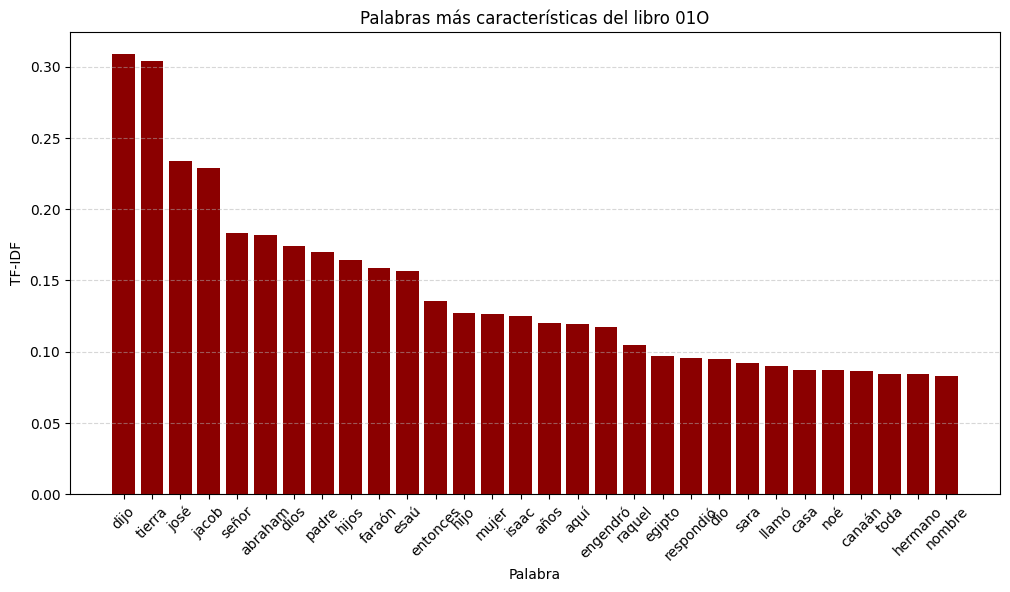

In [123]:
# =================================================================
# Gráfico TF-IDF para palabras más distintivas
# =================================================================

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(df_keyness["Palabra"], df_keyness["TF-IDF"], color='darkred')

plt.title(f"Palabras más características del libro {libro_id}")
plt.xlabel("Palabra")
plt.ylabel("TF-IDF")

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


###Preprocesamiento: asegurar columnas

In [124]:
# =================================================================
# Asegurar columnas necesarias
# =================================================================

df_norm['text_no_stop'] = df_norm['tokens_no_stop'].apply(lambda x: " ".join(x))

print(" Columnas aseguradas: tokens_no_stop, text_no_stop")


 Columnas aseguradas: tokens_no_stop, text_no_stop


In [125]:
# =================================================================
# Filtrar versículos donde aparece un personaje
# =================================================================

def versiculos_personaje(df, nombre):
    """
    Devuelve todos los versículos donde aparece el 'nombre' como palabra exacta.
    """
    nombre = nombre.lower()
    mask = df['tokens_no_stop'].apply(lambda lista: nombre in [p.lower() for p in lista])
    return df[mask]


In [126]:
# =================================================================
# Construir corpus por personaje
# =================================================================

def corpus_de_personaje(df, nombre):
    df_p = versiculos_personaje(df, nombre)
    texto = " ".join(df_p['text_no_stop'])
    return texto


In [127]:
# =================================================================
# Lista de personajes (puedes agregar los que quieras)
# =================================================================

personajes = ["dios", "adan", "noe", "abraham", "jacob"]


In [128]:
# =================================================================
# Corpus por personaje
# =================================================================

corpus_personajes = {p: corpus_de_personaje(df_norm, p) for p in personajes}

print(" Corpus por personaje creado.")


 Corpus por personaje creado.


In [129]:
# =================================================================
# Matriz TF-IDF para personajes
# =================================================================

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_pers = TfidfVectorizer(
    lowercase=True,
    analyzer="word",
    token_pattern=r'\b[a-záéíóúñ]+\b',
    min_df=2
)

tfidf_pers = vectorizer_pers.fit_transform(corpus_personajes.values())
feature_names_pers = vectorizer_pers.get_feature_names_out()

print(" Matriz TF-IDF de personajes creada.")
print(tfidf_pers.shape)


 Matriz TF-IDF de personajes creada.
(5, 1393)


In [130]:
# =================================================================
# Palabras clave por personaje
# =================================================================

import numpy as np
import pandas as pd

def palabras_caracteristicas_personaje(nombre, N=20):
    """
    Devuelve las N palabras más características del personaje 'nombre'
    según TF-IDF.
    """
    idx = list(corpus_personajes.keys()).index(nombre)
    fila = tfidf_pers[idx].toarray().flatten()
    indices = fila.argsort()[-N:][::-1]
    return [(feature_names_pers[i], fila[i]) for i in indices]


In [131]:
# =================================================================
# Ejemplo: palabras características de 'noe'
# =================================================================

carac_noe = palabras_caracteristicas_personaje("noe", N=20)

print(" Palabras más características de NOÉ:\n")
for palabra, score in carac_noe:
    print(f"{palabra}: {score:.4f}")


 Palabras más características de NOÉ:

aarón: 0.0000
acerca: 0.0000
acercaba: 0.0000
acercó: 0.0000
acontecer: 0.0000
acontecerá: 0.0000
aconteció: 0.0000
acontezca: 0.0000
acordaré: 0.0000
acordó: 0.0000
acostado: 0.0000
acuérdate: 0.0000
acábalos: 0.0000
acércate: 0.0000
además: 0.0000
aderezarlo: 0.0000
adivinación: 0.0000
viste: 0.0000
vistió: 0.0000
visto: 0.0000


###Calcular el TTR global del corpus

In [132]:
# =================================================================
# TTR (Type/Token Ratio) global del corpus
# =================================================================

# Aplanar todas las palabras útiles
tokens = [p for lista in df_norm['tokens_no_stop'] for p in lista]

# Tipos (palabras únicas)
tipos = set(tokens)

ttr = len(tipos) / len(tokens)

print(" Número total de tokens:", len(tokens))
print(" Número total de tipos (vocabulario único):", len(tipos))
print(f" TTR (Type/Token Ratio) global: {ttr:.4f}")


 Número total de tokens: 325768
 Número total de tipos (vocabulario único): 24875
 TTR (Type/Token Ratio) global: 0.0764


In [133]:
# =================================================================
# TTR por libro
# =================================================================

import pandas as pd

ttr_por_libro = []

for libro, grupo in df_norm.groupby('nrsva_book_index'):
    tokens_libro = [p for lista in grupo['tokens_no_stop'] for p in lista]
    tipos_libro = set(tokens_libro)
    ttr_val = len(tipos_libro) / len(tokens_libro)
    ttr_por_libro.append((libro, ttr_val))

df_ttr_libro = pd.DataFrame(ttr_por_libro, columns=["Libro (NRSVA)", "TTR"])
display(df_ttr_libro)


Libro (NRSVA)       TTR
0            01O  0.206053
1            02O  0.213016
2            03O  0.199830
3            04O  0.194918
4            05O  0.265378
..           ...       ...
61           62N  0.347639
62           63N  0.716667
63           64N  0.678082
64           65N  0.796721
65           66N  0.294293

[66 rows x 2 columns]

In [134]:
# =================================================================
# Gráfico: TTR por libro
# =================================================================

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(df_ttr_libro["Libro (NRSVA)"], df_ttr_libro["TTR"], marker='o', linestyle='-', color='darkblue')

plt.title("Índice de Riqueza Léxica (TTR) por Libro")
plt.xlabel("Libro (Índice NRSVA)")
plt.ylabel("TTR")

plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [135]:
# =================================================================
# TTR usando lemas
# =================================================================

if 'lemmas' in df_norm.columns:
    lemas = [l for lista in df_norm['lemmas'] for l in lista]
    tipos_lemmas = set(lemas)
    ttr_lemmas = len(tipos_lemmas) / len(lemas)

    print(" TTR basado en lemas:", round(ttr_lemmas, 4))
else:
    print(" No existe la columna 'lemmas'. Ejecuta la lematización primero.")


 TTR basado en lemas: 0.0613


### Aplanar tokens

In [136]:
# =================================================================
# Aplanar todas las palabras del corpus
# =================================================================

tokens = [p for lista in df_norm['tokens_no_stop'] for p in lista]

print("✔ Tokens cargados:", len(tokens))


✔ Tokens cargados: 325768


###Calcular frecuencias globales

In [137]:
# =================================================================
# Frecuencias globales de cada palabra
# =================================================================

from collections import Counter

frecuencias = Counter(tokens)

print(" Total de tipos únicos:", len(frecuencias))


 Total de tipos únicos: 24875


In [138]:
# =================================================================
# Hapax Legomena
# =================================================================

hapax_legomena = [pal for pal, freq in frecuencias.items() if freq == 1]

print(" Total de Hapax Legomena:", len(hapax_legomena))
print("Ejemplos:", hapax_legomena[:20])


 Total de Hapax Legomena: 10503
Ejemplos: ['desordenada', 'descúbrase', 'produzcan', 'vuelen', 'naturalezas', 'sojuzgadla', 'señoread', 'ánima', 'orígenes', 'regaba', 'repartía', 'cornerina', 'adormeció', 'varona', 'conque', 'comemos', 'cosieron', 'ceñir', 'preñeces', 'ensañó']


In [139]:
# =================================================================
# Hapax Dislegomena
# =================================================================

hapax_dislegomena = [pal for pal, freq in frecuencias.items() if freq == 2]

print(" Total de Hapax Dislegomena:", len(hapax_dislegomena))
print("Ejemplos:", hapax_dislegomena[:20])


 Total de Hapax Dislegomena: 3776
Ejemplos: ['movía', 'júntense', 'produzca', 'produjo', 'señorease', 'señorear', 'cantidad', 'produjeron', 'naciese', 'pisón', 'bedelio', 'hidekel', 'comieres', 'avergonzaban', 'comieses', 'sudor', 'vagabundo', 'irad', 'mehujael', 'metusael']


In [140]:
# =================================================================
# Tabla resumen Hapax Legomena / Dislegomena
# =================================================================

import pandas as pd

df_hapax = pd.DataFrame({
    "Métrica": ["Total Tokens", "Tipos únicos", "Hapax Legomena", "Hapax Dislegomena"],
    "Valor": [len(tokens), len(frecuencias), len(hapax_legomena), len(hapax_dislegomena)]
})

display(df_hapax)


Métrica   Valor
0       Total Tokens  325768
1       Tipos únicos   24875
2     Hapax Legomena   10503
3  Hapax Dislegomena    3776

In [141]:
# =================================================================
# Porcentaje de hapax
# =================================================================

pct_hapax = len(hapax_legomena) / len(frecuencias) * 100
pct_dis = len(hapax_dislegomena) / len(frecuencias) * 100

print(f" Porcentaje Hapax Legomena: {pct_hapax:.2f}%")
print(f" Porcentaje Hapax Dislegomena: {pct_dis:.2f}%")


 Porcentaje Hapax Legomena: 42.22%
 Porcentaje Hapax Dislegomena: 15.18%


### Preparar tokens por libro

In [142]:
# =================================================================
# Preparar tokens por libro
# =================================================================

tokens_por_libro = {}

for libro, grupo in df_norm.groupby("nrsva_book_index"):
    tokens = [p for lista in grupo["tokens_no_stop"] for p in lista]
    tokens_por_libro[libro] = tokens

print(f" Libros procesados: {len(tokens_por_libro)}")


 Libros procesados: 66


In [143]:
# =================================================================
# Diversidad léxica (TTR) por libro
# =================================================================

import pandas as pd

diversidad = []  # lista de filas

for libro, tokens in tokens_por_libro.items():
    tipos = set(tokens)
    ttr = len(tipos) / len(tokens)
    diversidad.append([libro, len(tokens), len(tipos), ttr])

df_lexico_libro = pd.DataFrame(diversidad, columns=[
    "Libro (NRSVA)", "Tokens Totales", "Tipos Únicos", "TTR"
]).sort_values("Libro (NRSVA)").reset_index(drop=True)

display(df_lexico_libro)


Libro (NRSVA)  Tokens Totales  Tipos Únicos       TTR
0            01O           16224          3343  0.206053
1            02O           13276          2828  0.213016
2            03O            9418          1882  0.199830
3            04O           13421          2616  0.194918
4            05O           10762          2856  0.265378
..           ...             ...           ...       ...
61           62N             932           324  0.347639
62           63N             120            86  0.716667
63           64N             146            99  0.678082
64           65N             305           243  0.796721
65           66N            5029          1480  0.294293

[66 rows x 4 columns]

In [144]:
# =================================================================
# Gráfico: Diversidad léxica (TTR) por libro
# =================================================================

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(df_lexico_libro["Libro (NRSVA)"], df_lexico_libro["TTR"],
         marker="o", linestyle="-", color="darkgreen")

plt.title("Índice de Diversidad Léxica (TTR) por Libro")
plt.xlabel("Libro (Índice NRSVA)")
plt.ylabel("TTR (Type/Token Ratio)")

plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.show()


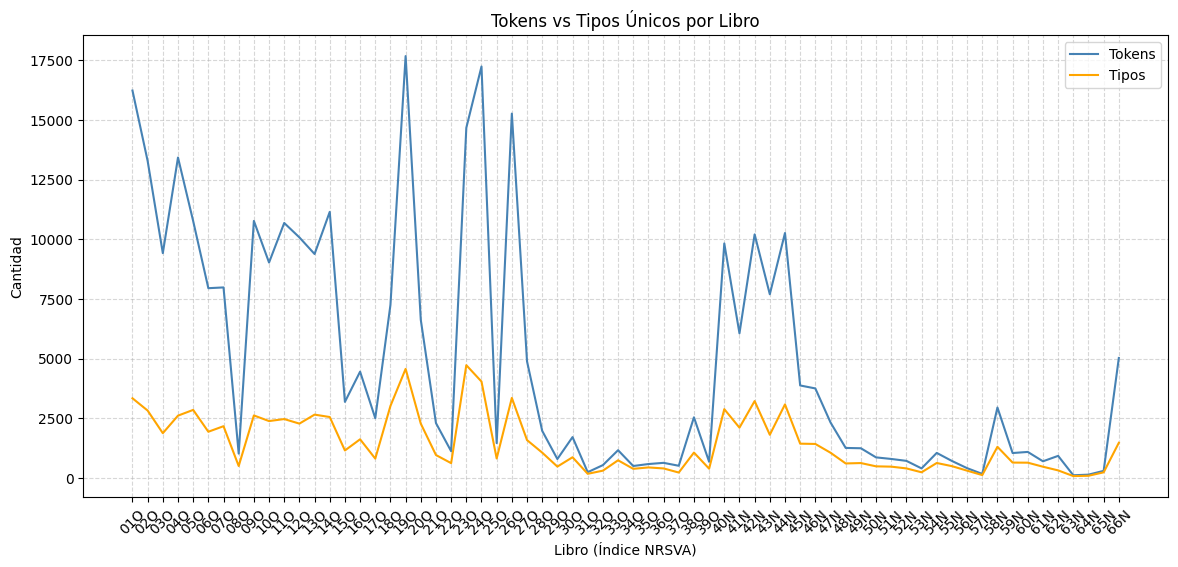

In [145]:
# =================================================================
# Gráfico: Tipos y tokens por libro
# =================================================================

plt.figure(figsize=(14, 6))
plt.plot(df_lexico_libro["Libro (NRSVA)"], df_lexico_libro["Tokens Totales"],
         label="Tokens", color="steelblue")
plt.plot(df_lexico_libro["Libro (NRSVA)"], df_lexico_libro["Tipos Únicos"],
         label="Tipos", color="orange")

plt.title("Tokens vs Tipos Únicos por Libro")
plt.xlabel("Libro (Índice NRSVA)")
plt.ylabel("Cantidad")

plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.show()


###Aplanar tokens y contar frecuencias

In [146]:
# =================================================================
# Aplanar tokens y calcular frecuencias
# =================================================================

from collections import Counter

tokens = [p for lista in df_norm['tokens_no_stop'] for p in lista]
frecuencias = Counter(tokens)

print(" Tokens totales:", len(tokens))
print(" Tipos únicos:", len(frecuencias))


 Tokens totales: 325768
 Tipos únicos: 24875


### Detectar palabras raras (freq ≤ 3)

In [147]:
# =================================================================
# Palabras raras: frecuencia ≤ 3
# =================================================================

palabras_raras = [pal for pal, freq in frecuencias.items() if freq <= 3]

print("🔹 Palabras raras (freq ≤ 3):", len(palabras_raras))
print("Ejemplos:", palabras_raras[:20])


🔹 Palabras raras (freq ≤ 3): 16328
Ejemplos: ['desordenada', 'movía', 'júntense', 'descúbrase', 'produzca', 'produjo', 'señorease', 'señorear', 'produzcan', 'cantidad', 'vuelen', 'produjeron', 'naturalezas', 'señoree', 'sojuzgadla', 'señoread', 'mueven', 'ánima', 'ornamento', 'orígenes']


###Detectar palabras comunes (percentil 95)

In [148]:
# =================================================================
# Palabras comunes: percentil 95
# =================================================================

import numpy as np

valores_frec = np.array(list(frecuencias.values()))
umbral_95 = np.percentile(valores_frec, 95)

palabras_comunes = [pal for pal, freq in frecuencias.items() if freq >= umbral_95]

print(" Palabras comunes (percentil 95):", len(palabras_comunes))
print("Umbral de frecuencia (p95):", umbral_95)
print("Ejemplos:", palabras_comunes[:20])


 Palabras comunes (percentil 95): 1260
Umbral de frecuencia (p95): 40.0
Ejemplos: ['principio', 'dios', 'cielos', 'tierra', 'tinieblas', 'faz', 'espíritu', 'aguas', 'dijo', 'luz', 'vio', 'buena', 'apartó', 'llamó', 'día', 'noche', 'tarde', 'mañana', 'medio', 'hizo']


###Resumen numérico

In [149]:
# =================================================================
# Resumen de palabras raras y comunes
# =================================================================

import pandas as pd

df_resumen = pd.DataFrame({
    "Categoría": ["Tokens totales", "Tipos únicos",
                  "Palabras raras (≤3)", "Palabras comunes (p95)"],
    "Valor": [len(tokens), len(frecuencias),
              len(palabras_raras), len(palabras_comunes)]
})

display(df_resumen)


Categoría   Valor
0          Tokens totales  325768
1            Tipos únicos   24875
2     Palabras raras (≤3)   16328
3  Palabras comunes (p95)    1260

###Gráfico: palabras raras vs comunes

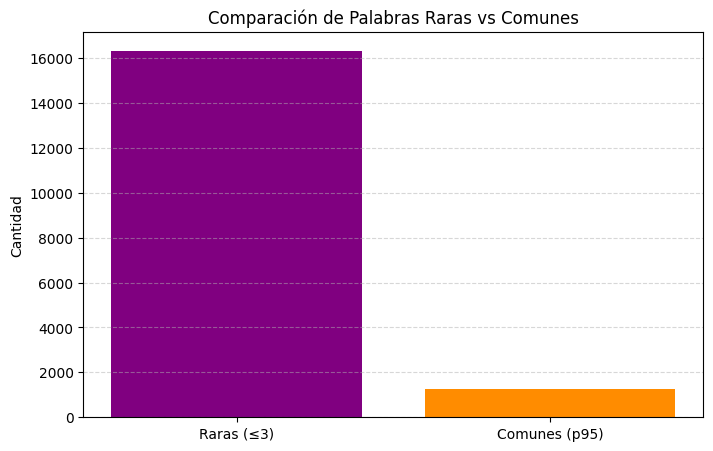

In [150]:
# =================================================================
# Gráfico comparativo
# =================================================================

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(["Raras (≤3)", "Comunes (p95)"],
        [len(palabras_raras), len(palabras_comunes)],
        color=["purple", "darkorange"])

plt.title("Comparación de Palabras Raras vs Comunes")
plt.ylabel("Cantidad")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


### Preparar tokens del corpus

In [151]:
# =================================================================
# Preparar tokens del corpus
# =================================================================

tokens = [p for lista in df_norm['tokens_no_stop'] for p in lista]

print(" Tokens cargados:", len(tokens))


 Tokens cargados: 325768


###Construir distribución de probabilidad

In [152]:
# =================================================================
# Frecuencias y probabilidades
# =================================================================

from collections import Counter
import numpy as np

frecuencias = Counter(tokens)
total_tokens = len(tokens)

# Probabilidades
probs = np.array([freq / total_tokens for freq in frecuencias.values()])


In [153]:
# =================================================================
# Entropía del texto
# =================================================================

entropia = -np.sum(probs * np.log2(probs))

print(f" Entropía total del texto (bits): {entropia:.4f}")


 Entropía total del texto (bits): 11.5069


In [154]:
# =================================================================
# Entropía por libro
# =================================================================

import pandas as pd

entropia_libro = []

for libro, grupo in df_norm.groupby("nrsva_book_index"):
    tokens_l = [p for lista in grupo["tokens_no_stop"] for p in lista]
    frecs_l = Counter(tokens_l)
    total_l = len(tokens_l)
    probs_l = np.array([f / total_l for f in frecs_l.values()])

    H_l = -np.sum(probs_l * np.log2(probs_l))
    entropia_libro.append([libro, H_l])

df_entropia = pd.DataFrame(entropia_libro, columns=["Libro (NRSVA)", "Entropía"])
display(df_entropia)


Libro (NRSVA)  Entropía
0            01O  9.899665
1            02O  9.784617
2            03O  9.357789
3            04O  9.654589
4            05O  9.879148
..           ...       ...
61           62N  7.453354
62           63N  6.234981
63           64N  6.411409
64           65N  7.738756
65           66N  9.498394

[66 rows x 2 columns]

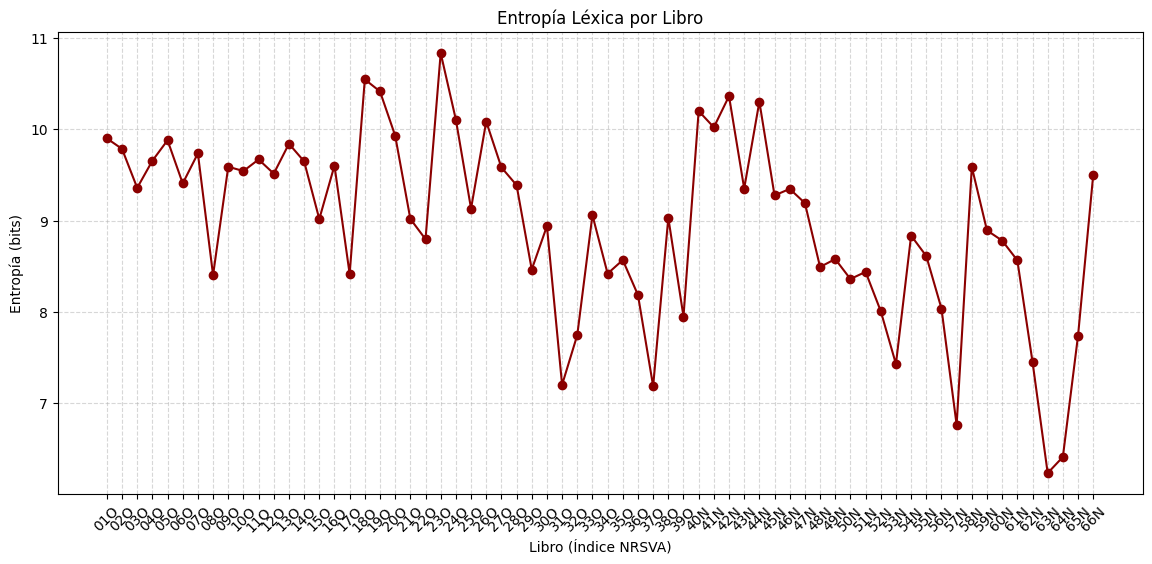

In [155]:
# =================================================================
# Gráfico: Entropía por libro
# =================================================================

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(df_entropia["Libro (NRSVA)"], df_entropia["Entropía"],
         marker="o", linestyle="-", color="darkred")

plt.title("Entropía Léxica por Libro")
plt.xlabel("Libro (Índice NRSVA)")
plt.ylabel("Entropía (bits)")

plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.show()


### Asegurar columna word_count (si no existe)

In [156]:
# =================================================================
# Crear word_count si aún no existe
# =================================================================

if 'word_count' not in df_norm.columns:
    df_norm['word_count'] = df_norm['tokens_no_stop'].apply(len)

print(" Columna word_count creada / verificada.")


 Columna word_count creada / verificada.


### Verificar / crear word_count

In [157]:
# =================================================================
# Crear word_count si aún no existe
# =================================================================

if 'word_count' not in df_norm.columns:
    df_norm['word_count'] = df_norm['tokens_no_stop'].apply(len)

print("✔ word_count creado/verificado.")
df_norm['word_count'].head()


✔ word_count creado/verificado.


0     5
1    11
2     4
3     8
4    10
Name: word_count, dtype: int64

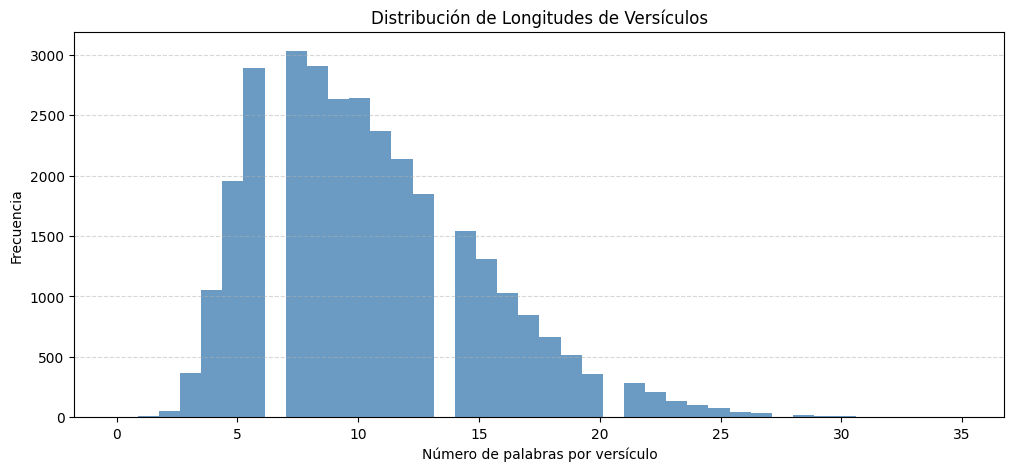

In [158]:
# =================================================================
# Histograma de longitudes de versículos (en palabras)
# =================================================================

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.hist(df_norm['word_count'], bins=40, color='steelblue', alpha=0.8)

plt.title("Distribución de Longitudes de Versículos")
plt.xlabel("Número de palabras por versículo")
plt.ylabel("Frecuencia")

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


In [159]:
# =================================================================
# Contar palabras más frecuentes
# =================================================================

from collections import Counter

# Aplanar todos los tokens
tokens = [p for lista in df_norm['tokens_no_stop'] for p in lista]

# Contar frecuencias
frecuencias = Counter(tokens)

# Seleccionar las N más frecuentes
N = 30
top_palabras = frecuencias.most_common(N)

top_palabras[:10]


[('señor', 8029),
 ('dios', 4473),
 ('dijo', 3388),
 ('tierra', 3021),
 ('hijos', 2844),
 ('israel', 2562),
 ('rey', 2506),
 ('mas', 2353),
 ('hijo', 2349),
 ('casa', 1987)]

In [160]:
# =================================================================
# Convertir top N palabras a DataFrame
# =================================================================

import pandas as pd

df_top = pd.DataFrame(top_palabras, columns=["Palabra", "Frecuencia"])
df_top


Palabra  Frecuencia
0      señor        8029
1       dios        4473
2       dijo        3388
3     tierra        3021
4      hijos        2844
5     israel        2562
6        rey        2506
7        mas        2353
8       hijo        2349
9       casa        1987
10    pueblo        1823
11   delante        1763
12        si        1735
13  entonces        1724
14       así        1691
15      aquí        1455
16       día        1352
17  diciendo        1303
18      mano        1288
19      pues        1273
20      toda        1202
21    hombre        1148
22     david        1127
23     todas        1114
24     padre        1101
25     jesús         966
26      hizo         909
27      días         901
28   corazón         885
29     ahora         879

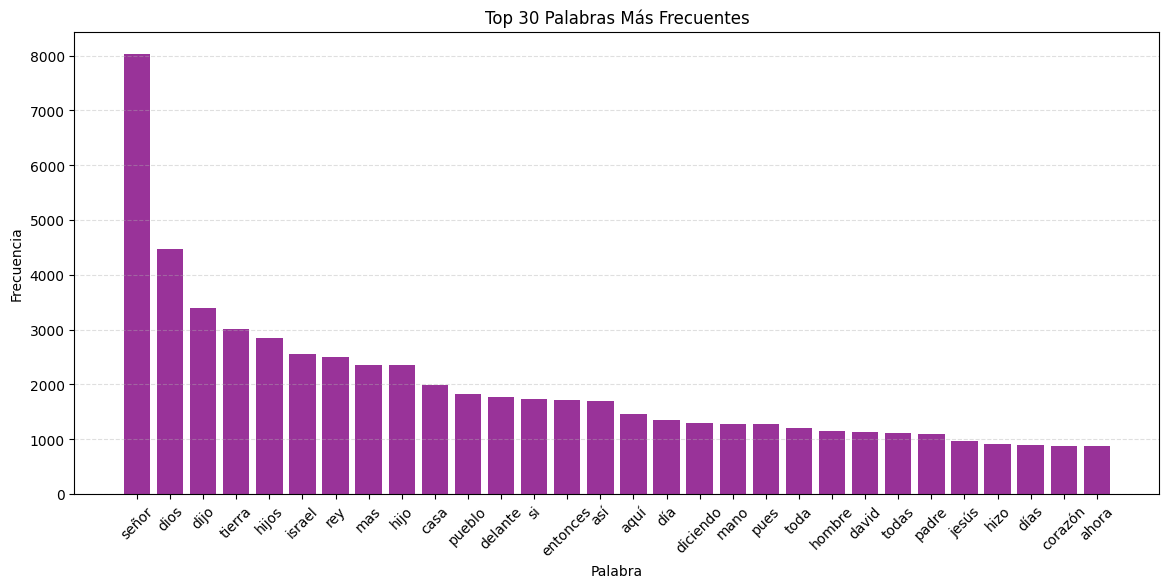

In [161]:
# =================================================================
# Gráfico de barras de las palabras más frecuentes
# =================================================================

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.bar(df_top["Palabra"], df_top["Frecuencia"], color="purple", alpha=0.8)

plt.title(f"Top {N} Palabras Más Frecuentes")
plt.xlabel("Palabra")
plt.ylabel("Frecuencia")

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()


In [162]:
# =================================================================
# Seleccionar top N palabras más frecuentes del corpus
# =================================================================

from collections import Counter

# Aplanar tokens
tokens = [p for lista in df_norm['tokens_no_stop'] for p in lista]

# Calcular frecuencias
frecuencias = Counter(tokens)

# Elegir top N palabras
N = 30
top_words = [pal for pal, freq in frecuencias.most_common(N)]

print("✔ Palabras seleccionadas:", top_words[:10], "...")


✔ Palabras seleccionadas: ['señor', 'dios', 'dijo', 'tierra', 'hijos', 'israel', 'rey', 'mas', 'hijo', 'casa'] ...


### Contar frecuencias por capítulo

In [163]:
# =================================================================
# Construir matriz libro-capítulo vs palabra
# =================================================================

import pandas as pd

# Crear DataFrame vacío
df_heat = pd.DataFrame(columns=["Libro", "Capítulo"] + top_words)

# Agrupar por libro y capítulo
grupos = df_norm.groupby(["nrsva_book_index", "nrsva_chapter"])

rows = []

for (libro, cap), grupo in grupos:
    tokens_cap = [p for lista in grupo['tokens_no_stop'] for p in lista]
    frecs_cap = Counter(tokens_cap)

    fila = {"Libro": libro, "Capítulo": cap}
    fila.update({w: frecs_cap.get(w, 0) for w in top_words})

    rows.append(fila)

df_heat = pd.DataFrame(rows)

print("✔ Matriz creada con forma:", df_heat.shape)
df_heat.head()


✔ Matriz creada con forma: (1189, 32)


Libro  Capítulo  señor  dios  dijo  tierra  hijos  israel  rey  mas  ...  \
0   01O         1      0    32    10      21      0       0    0    0  ...   
1   01O         2     11    14     2      14      0       0    0    2  ...   
2   01O         3      9    11    12       3      1       0    0    2  ...   
3   01O         4     10     1     7       9      0       0    0    1  ...   
4   01O         5      1     5     0       1      9       0    0    0  ...   

   toda  hombre  david  todas  padre  jesús  hizo  días  corazón  ahora  
0     7       2      0      3      0      0     3     1        0      0  
1    10      11      0      0      1      0     3     0        0      0  
2     0       8      0      1      0      0     1     2        0      1  
3     1       0      0      0      2      0     0     0        0      1  
4     0       1      0      0      0      0     1    10        0      0  

[5 rows x 32 columns]

In [164]:
# =================================================================
# Crear índice capítulo absoluto (libro.capítulo)
# =================================================================

df_heat["LibroCap"] = df_heat["Libro"].astype(str) + "." + df_heat["Capítulo"].astype(str)
df_heat = df_heat.sort_values(["Libro", "Capítulo"]).reset_index(drop=True)

df_heat.index = df_heat["LibroCap"]
df_heat_num = df_heat[top_words]

print("✔ Índice LibroCap generado.")
df_heat_num.head()


✔ Índice LibroCap generado.


señor  dios  dijo  tierra  hijos  israel  rey  mas  hijo  casa  ...  \
LibroCap                                                                  ...   
01O.1         0    32    10      21      0       0    0    0     0     0  ...   
01O.2        11    14     2      14      0       0    0    2     0     0  ...   
01O.3         9    11    12       3      1       0    0    2     0     0  ...   
01O.4        10     1     7       9      0       0    0    1     3     0  ...   
01O.5         1     5     0       1      9       0    0    0     2     0  ...   

          toda  hombre  david  todas  padre  jesús  hizo  días  corazón  ahora  
LibroCap                                                                        
01O.1        7       2      0      3      0      0     3     1        0      0  
01O.2       10      11      0      0      1      0     3     0        0      0  
01O.3        0       8      0      1      0      0     1     2        0      1  
01O.4        1       0      0      0      2      0     0     0        0      1  
01O.5        0       1      0      0      0      0     1    10        0      0  

[5 rows x 30 columns]

In [165]:
# =================================================================
# Instalar librería WordCloud
# =================================================================

!pip install wordcloud


In [166]:
# =================================================================
# Construir texto para WordCloud
# =================================================================

# Aplanar todos los tokens limpios
tokens = [p for lista in df_norm['tokens_no_stop'] for p in lista]

# Unir todo como texto
texto_wordcloud = " ".join(tokens)

print("✔ Texto para WordCloud construido.")


✔ Texto para WordCloud construido.


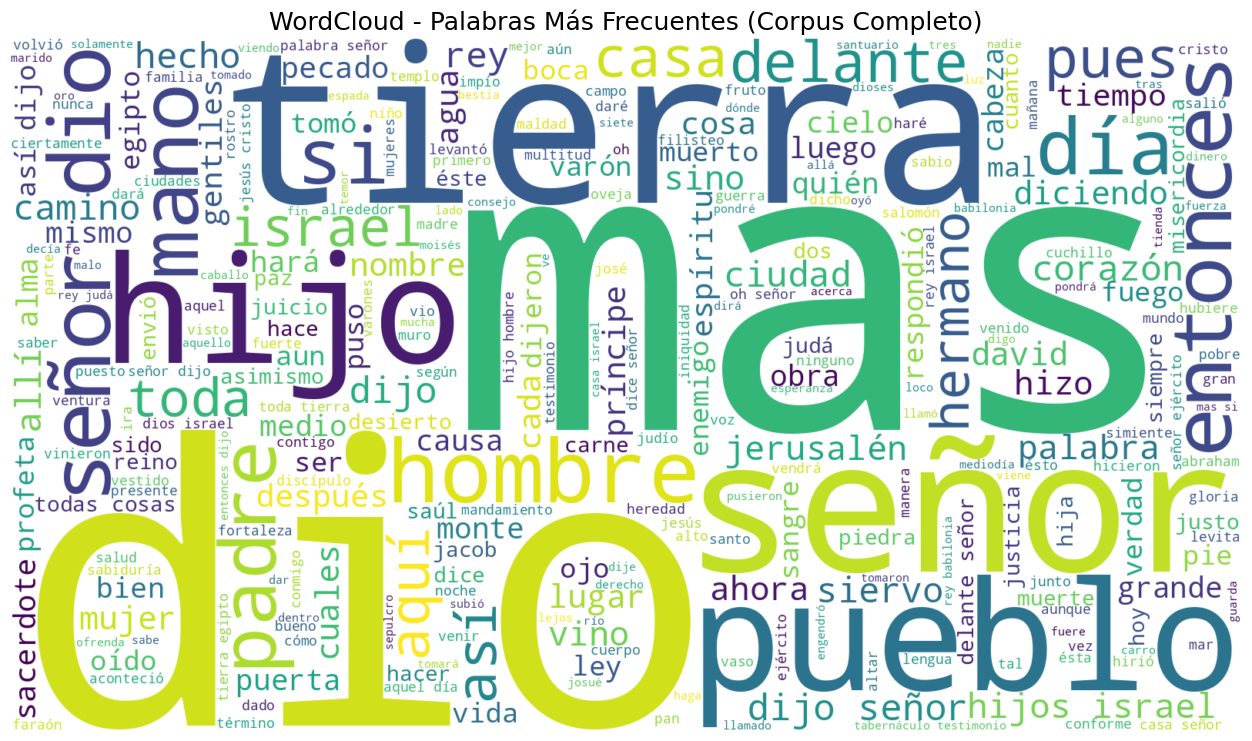

In [167]:
# =================================================================
# Generar WordCloud
# =================================================================

from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(
    width=1600,
    height=900,
    background_color="white",
    max_words=300,
    colormap="viridis"
).generate(texto_wordcloud)

plt.figure(figsize=(16, 9))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud - Palabras Más Frecuentes (Corpus Completo)", fontsize=18)
plt.show()


In [168]:
# =================================================================
# WordCloud por libro (versión corregida y robusta)
# =================================================================

def wordcloud_por_libro(libro_id):
    # Filtrar el libro
    grupo = df_norm[df_norm["nrsva_book_index"] == libro_id]

    # Validar si existe ese libro
    if grupo.empty:
        print(f" No existe ningún libro con índice {libro_id}.")
        print(" Usa df_norm['nrsva_book_index'].unique() para ver los índices disponibles.")
        return

    # Extraer tokens
    tokens_libro = [p for lista in grupo['tokens_no_stop'] for p in lista]

    # Validar si el libro tiene palabras
    if len(tokens_libro) == 0:
        print(f"⚠ El libro con índice {libro_id} no tiene palabras procesables.")
        return

    # Crear texto
    texto = " ".join(tokens_libro)

    # Generar WordCloud
    from wordcloud import WordCloud
    import matplotlib.pyplot as plt

    wc = WordCloud(
        width=1600,
        height=900,
        background_color="white",
        colormap="plasma",
        max_words=200
    ).generate(texto)

    plt.figure(figsize=(16, 9))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"WordCloud - Libro {libro_id}", fontsize=18)
    plt.show()


In [169]:
# =================================================================
# Ver los índices reales de libros
# =================================================================

df_norm['nrsva_book_index'].unique()


array(['01O', '02O', '03O', '04O', '05O', '06O', '07O', '08O', '09O',
       '10O', '11O', '12O', '13O', '14O', '15O', '16O', '17O', '18O',
       '19O', '20O', '21O', '22O', '23O', '24O', '25O', '26O', '27O',
       '28O', '29O', '30O', '31O', '32O', '33O', '34O', '35O', '36O',
       '37O', '38O', '39O', '40N', '41N', '42N', '43N', '44N', '45N',
       '46N', '47N', '48N', '49N', '50N', '51N', '52N', '53N', '54N',
       '55N', '56N', '57N', '58N', '59N', '60N', '61N', '62N', '63N',
       '64N', '65N', '66N'], dtype=object)

In [170]:
# =================================================================
# Construir y contar bigramas a partir de tokens_no_stop
# =================================================================

from collections import Counter

def generar_bigramas(lista_tokens):
    """
    Recibe una lista de tokens y devuelve una lista de bigramas como tuplas (w1, w2)
    """
    return list(zip(lista_tokens[:-1], lista_tokens[1:]))

# Aplanar todos los tokens del corpus
tokens = [p for lista in df_norm['tokens_no_stop'] for p in lista]

# Generar todos los bigramas
bigrams = generar_bigramas(tokens)

# Contar frecuencias de bigramas
bigram_freq = Counter(bigrams)

print(" Total de bigramas distintos:", len(bigram_freq))
list(bigram_freq.items())[:10]


 Total de bigramas distintos: 218069


[(('principio', 'creó'), 1),
 (('creó', 'dios'), 6),
 (('dios', 'cielos'), 20),
 (('cielos', 'tierra'), 35),
 (('tierra', 'tierra'), 24),
 (('tierra', 'desordenada'), 1),
 (('desordenada', 'vacía'), 1),
 (('vacía', 'tinieblas'), 1),
 (('tinieblas', 'faz'), 1),
 (('faz', 'abismo'), 2)]

In [171]:
# =================================================================
# Seleccionar TOP K bigramas más frecuentes
# =================================================================

K = 50  # puedes ajustar este valor

top_bigrams = bigram_freq.most_common(K)

print(f" Seleccionados los {K} bigramas más frecuentes:")
for par, freq in top_bigrams[:10]:
    print(f"{par} -> {freq}")


 Seleccionados los 50 bigramas más frecuentes:
('señor', 'dios') -> 1268
('dijo', 'señor') -> 799
('hijos', 'israel') -> 660
('así', 'dijo') -> 363
('todas', 'cosas') -> 329
('delante', 'señor') -> 295
('palabra', 'señor') -> 276
('oh', 'señor') -> 271
('casa', 'señor') -> 265
('señor', 'ejércitos') -> 245


In [172]:
# =================================================================
# Construir grafo de co-ocurrencia de bigramas
# =================================================================

!pip install networkx

import networkx as nx

G = nx.Graph()

# Añadir nodos y aristas con peso
for (w1, w2), freq in top_bigrams:
    G.add_node(w1)
    G.add_node(w2)
    G.add_edge(w1, w2, weight=freq)

print(" Nodos en el grafo:", G.number_of_nodes())
print(" Aristas en el grafo:", G.number_of_edges())


 Nodos en el grafo: 54
 Aristas en el grafo: 49


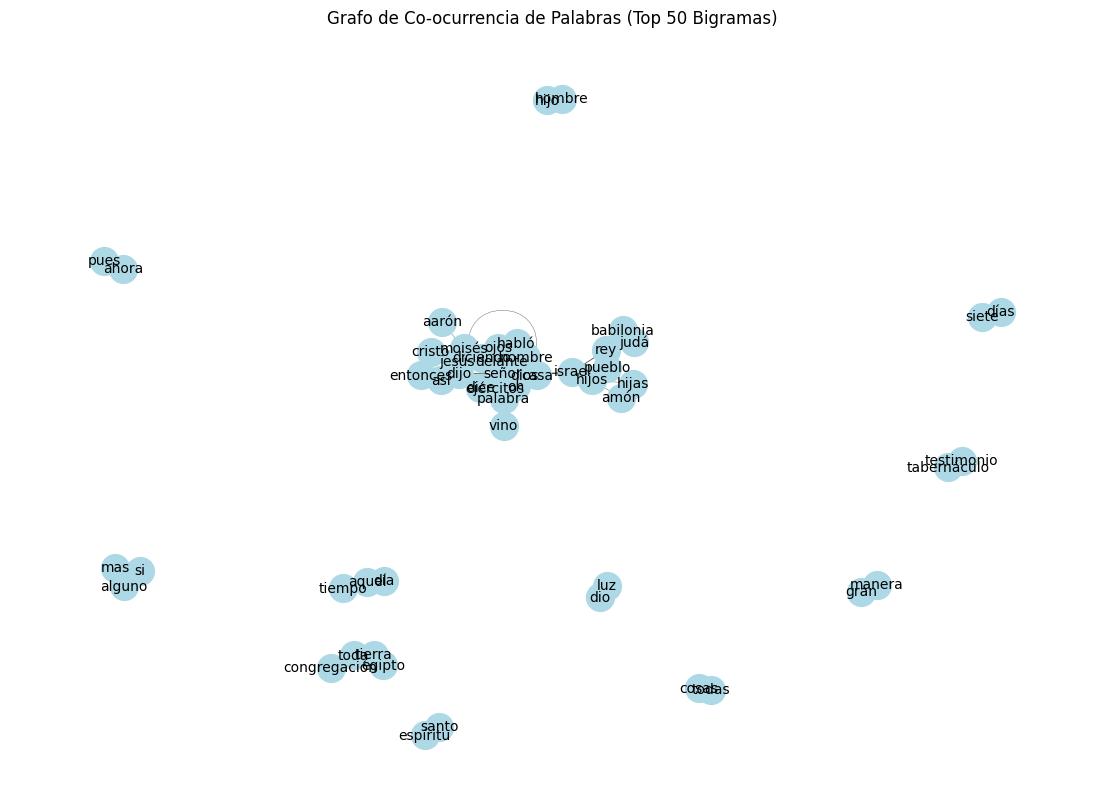

In [173]:
# =================================================================
# Graficar el grafo de bigramas
# =================================================================

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))

# Posiciones de los nodos
pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)

# Pesos de las aristas (para grosor)
weights = [G[u][v]['weight'] for u, v in G.edges()]

# Dibujar nodos
nx.draw_networkx_nodes(G, pos, node_size=400, node_color='lightblue')

# Dibujar aristas (más grosor = más frecuencia)
nx.draw_networkx_edges(
    G, pos,
    width=[w / max(weights) * 5 for w in weights],  # normalizar grosor
    alpha=0.6
)

# Etiquetas de los nodos (palabras)
nx.draw_networkx_labels(G, pos, font_size=10)

plt.title(f"Grafo de Co-ocurrencia de Palabras (Top {K} Bigramas)")
plt.axis("off")
plt.show()


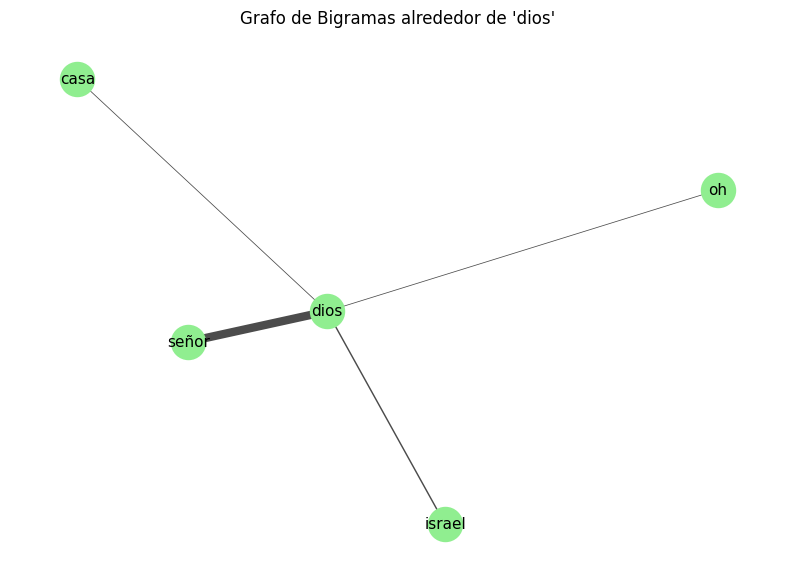

In [174]:
# =================================================================
# Grafo de bigramas filtrado por una palabra clave
# =================================================================

palabra_clave = "dios"

# Filtrar solo bigramas donde aparece la palabra clave
top_bigrams_filtrados = [
    ((w1, w2), freq)
    for (w1, w2), freq in top_bigrams
    if w1 == palabra_clave or w2 == palabra_clave
]

G_key = nx.Graph()

for (w1, w2), freq in top_bigrams_filtrados:
    G_key.add_node(w1)
    G_key.add_node(w2)
    G_key.add_edge(w1, w2, weight=freq)

plt.figure(figsize=(10, 7))

pos = nx.spring_layout(G_key, k=0.7, iterations=50, seed=42)
weights = [G_key[u][v]['weight'] for u, v in G_key.edges()]

nx.draw_networkx_nodes(G_key, pos, node_size=600, node_color='lightgreen')
nx.draw_networkx_edges(
    G_key, pos,
    width=[w / max(weights) * 6 for w in weights],
    alpha=0.7
)
nx.draw_networkx_labels(G_key, pos, font_size=11)

plt.title(f"Grafo de Bigramas alrededor de '{palabra_clave}'")
plt.axis("off")
plt.show()


In [175]:
# =================================================================
# Frecuencia de una palabra a lo largo del texto (por capítulo)
# =================================================================

import pandas as pd

def tendencia_palabra(palabra):
    palabra = palabra.lower()

    frecuencias = []
    for (libro, cap), grupo in df_norm.groupby(["nrsva_book_index", "nrsva_chapter"]):
        tokens = [p.lower() for lista in grupo["tokens_no_stop"] for p in lista]
        freq = tokens.count(palabra)
        frecuencias.append([f"{libro}.{cap}", freq])

    df_tend = pd.DataFrame(frecuencias, columns=["LibroCap", "Frecuencia"])
    return df_tend


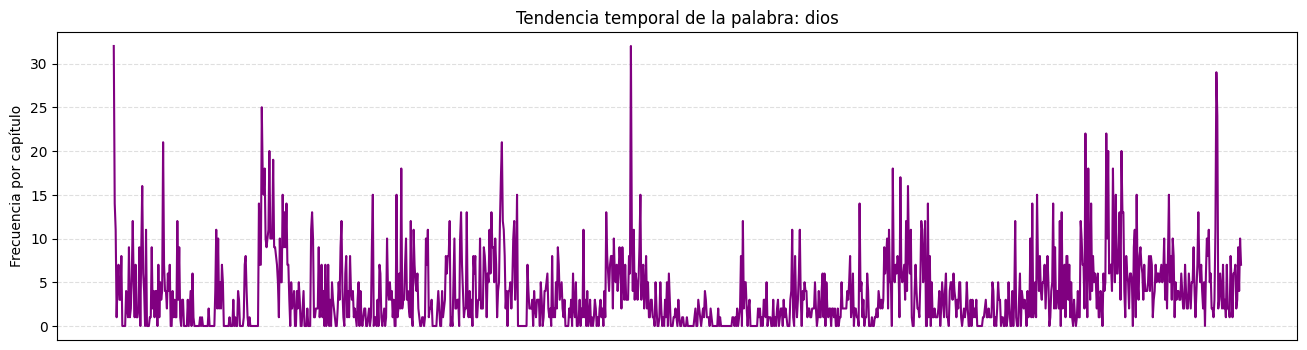

In [176]:
# =================================================================
# Graficar tendencia de una palabra
# =================================================================

import matplotlib.pyplot as plt

palabra = "dios"
df_tend = tendencia_palabra(palabra)

plt.figure(figsize=(16,4))
plt.plot(df_tend["LibroCap"], df_tend["Frecuencia"], color="purple")

plt.title(f"Tendencia temporal de la palabra: {palabra}")
plt.xticks([], [])  # demasiados capítulos para mostrar etiquetas
plt.ylabel("Frecuencia por capítulo")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()


In [177]:
# =================================================================
# Correlación entre palabras frecuentes
# =================================================================

from collections import Counter
import numpy as np

# Top 50 palabras para análisis
top_words = [w for w, _ in Counter(tokens).most_common(50)]

# Matriz capítulos vs palabras
data = []

for (libro, cap), grupo in df_norm.groupby(["nrsva_book_index", "nrsva_chapter"]):
    tokens_c = [p for lista in grupo['tokens_no_stop'] for p in lista]
    frecs = Counter(tokens_c)
    data.append([frecs.get(w, 0) for w in top_words])

import pandas as pd
df_mat = pd.DataFrame(data, columns=top_words)

corr = df_mat.corr()


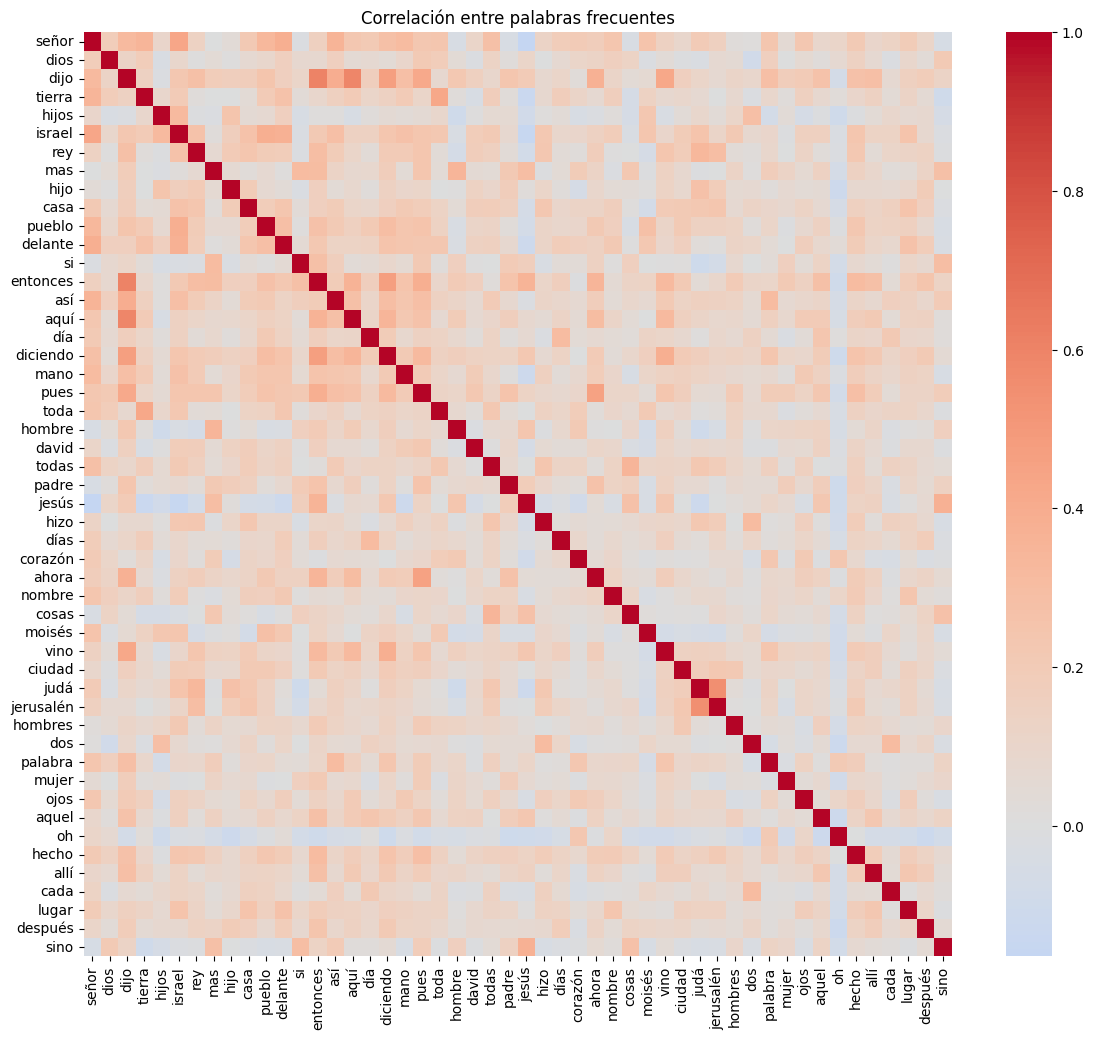

In [178]:
# =================================================================
# Heatmap de correlación entre palabras
# =================================================================

import seaborn as sns
plt.figure(figsize=(14,12))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlación entre palabras frecuentes")
plt.show()


In [179]:
# =================================================================
# Longitud promedio del versículo por libro
# =================================================================

df_style = df_norm.groupby("nrsva_book_index")["word_count"].mean().reset_index()
df_style.columns = ["Libro", "LongitudMedia"]

plt.figure(figsize=(12,5))
plt.plot(df_style["Libro"], df_style["LongitudMedia"], marker="o")
plt.title("Complejidad narrativa por libro")
plt.ylabel("Palabras por versículo")
plt.grid(True)
plt.show()


In [180]:
# =================================================================
# Frecuencias de palabras cuando aparece un personaje
# =================================================================

def contexto_personaje(nombre, top=20):
    nombre = nombre.lower()
    mask = df_norm['tokens_no_stop'].apply(lambda toks: nombre in [p.lower() for p in toks])
    tokens_p = [p for lista in df_norm[mask]['tokens_no_stop'] for p in lista]
    frecs = Counter(tokens_p).most_common(top)
    return frecs


In [181]:
# =================================================================
# Frecuencias por libro para un set de palabras
# =================================================================

from collections import Counter
import pandas as pd

# Palabras a comparar (puedes cambiarlas)
palabras = ["dios", "hombre", "tierra", "día", "rey"]

# Construir tabla Libro × Palabras
rows = []

for libro, grupo in df_norm.groupby("nrsva_book_index"):
    tokens = [p.lower() for lista in grupo["tokens_no_stop"] for p in lista]
    frec = Counter(tokens)
    rows.append([libro] + [frec.get(w, 0) for w in palabras])

df_radar = pd.DataFrame(rows, columns=["Libro"] + palabras)

# Escoger algunos libros para comparar (ejemplo: primeros 5)
df_radar_sel = df_radar.head(5)
df_radar_sel


Libro  dios  hombre  tierra  día  rey
0   01O   232      49     348   53   34
1   02O   119      16     147   67   14
2   03O    52      19     104   60    0
3   04O    34      11     127   72   16
4   05O   348      32     247   32   21

In [182]:
# =================================================================
# Función: Gráfico RADAR
# =================================================================

import numpy as np
import matplotlib.pyplot as plt

def plot_radar(df, fila, etiquetas, titulo="Radar Chart"):
    valores = df.loc[fila, etiquetas].values
    categorias = etiquetas
    N = len(categorias)

    # Cerrar el círculo
    valores = np.concatenate((valores, [valores[0]]))
    angulos = np.linspace(0, 2*np.pi, N, endpoint=False)
    angulos = np.concatenate((angulos, [angulos[0]]))

    plt.figure(figsize=(8, 8))
    plt.polar(angulos, valores, marker='o')

    plt.fill(angulos, valores, alpha=0.25)
    plt.xticks(angulos[:-1], categorias)
    plt.title(titulo, size=14)
    plt.show()


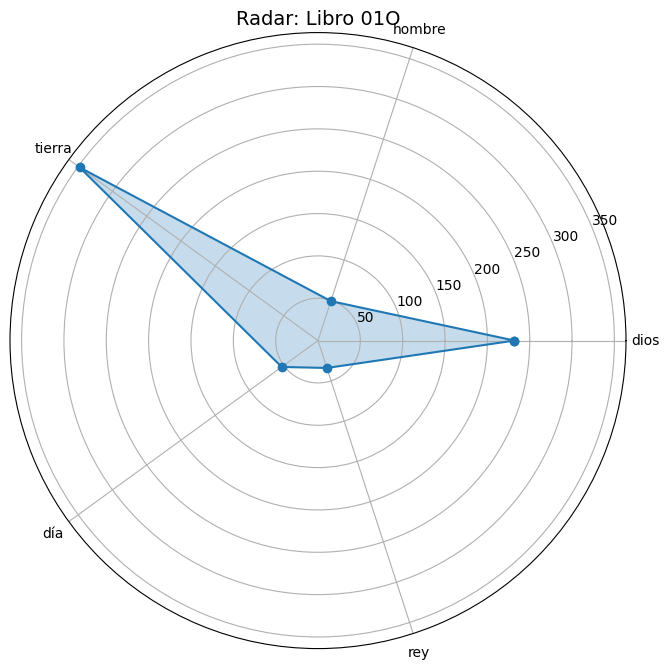

In [183]:
# =================================================================
# Graficar radar para un libro específico
# =================================================================

libro_id = df_radar_sel.iloc[0]["Libro"]  # primer libro de la tabla
fila = df_radar_sel[df_radar_sel["Libro"] == libro_id]

plot_radar(df=fila,
           fila=fila.index[0],
           etiquetas=palabras,
           titulo=f"Radar: Libro {libro_id}")


In [184]:
# =================================================================
# Métricas lingüísticas por libro
# =================================================================

import numpy as np
from collections import Counter

datos = []

for libro, grupo in df_norm.groupby("nrsva_book_index"):

    # Tokens del libro
    tokens = [p for lista in grupo["tokens_no_stop"] for p in lista]

    # TTR
    tipos = set(tokens)
    ttr = len(tipos) / len(tokens)

    # Entropía
    frec = Counter(tokens)
    probs = np.array([v / len(tokens) for v in frec.values()])
    H = -np.sum(probs * np.log2(probs))

    # Longitud promedio de versículo
    prom_long = grupo['word_count'].mean()

    datos.append([libro, ttr, H, prom_long])

df_metricas = pd.DataFrame(datos, columns=["Libro", "TTR", "Entropía", "Longitud"])
df_metricas.head()


Libro       TTR  Entropía   Longitud
0   01O  0.206053  9.899665  10.583170
1   02O  0.213016  9.784617  10.944765
2   03O  0.199830  9.357789  10.963912
3   04O  0.194918  9.654589  10.420031
4   05O  0.265378  9.879148  11.222106

In [185]:
# =================================================================
# Ley de Zipf: construir tabla rango vs frecuencia
# =================================================================

from collections import Counter
import pandas as pd

# Aplanar todos los tokens limpios
tokens = [p for lista in df_norm['tokens_no_stop'] for p in lista]

# Contar frecuencias
frecuencias = Counter(tokens)

# Ordenar por frecuencia (descendente)
palabras_ordenadas = frecuencias.most_common()

# Construir DataFrame: rango, palabra, frecuencia
zipf_data = pd.DataFrame(
    [(rango + 1, palabra, freq) for rango, (palabra, freq) in enumerate(palabras_ordenadas)],
    columns=["Rango", "Palabra", "Frecuencia"]
)

display(zipf_data.head(20))
print("✔ Tabla Zipf construida. Total de palabras distintas:", len(zipf_data))


Rango   Palabra  Frecuencia
0       1     señor        8029
1       2      dios        4473
2       3      dijo        3388
3       4    tierra        3021
4       5     hijos        2844
5       6    israel        2562
6       7       rey        2506
7       8       mas        2353
8       9      hijo        2349
9      10      casa        1987
10     11    pueblo        1823
11     12   delante        1763
12     13        si        1735
13     14  entonces        1724
14     15       así        1691
15     16      aquí        1455
16     17       día        1352
17     18  diciendo        1303
18     19      mano        1288
19     20      pues        1273

✔ Tabla Zipf construida. Total de palabras distintas: 24875


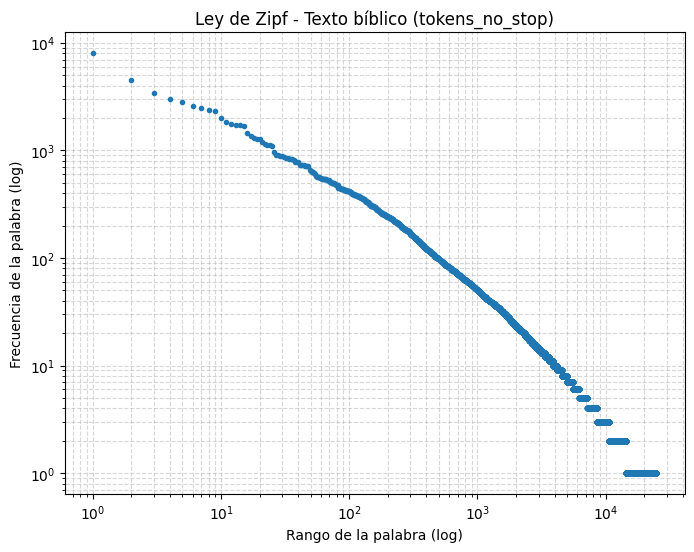

In [186]:
# =================================================================
# Gráfico Ley de Zipf (log-log)
# =================================================================

import matplotlib.pyplot as plt
import numpy as np

ranks = zipf_data["Rango"].values
freqs = zipf_data["Frecuencia"].values

plt.figure(figsize=(8, 6))
plt.loglog(ranks, freqs, marker='.', linestyle='none')

plt.title("Ley de Zipf - Texto bíblico (tokens_no_stop)")
plt.xlabel("Rango de la palabra (log)")
plt.ylabel("Frecuencia de la palabra (log)")
plt.grid(True, which="both", linestyle='--', alpha=0.5)
plt.show()


Recta ajustada en log10: log10(freq) ≈ -0.763 + 4.105 * log10(rango)


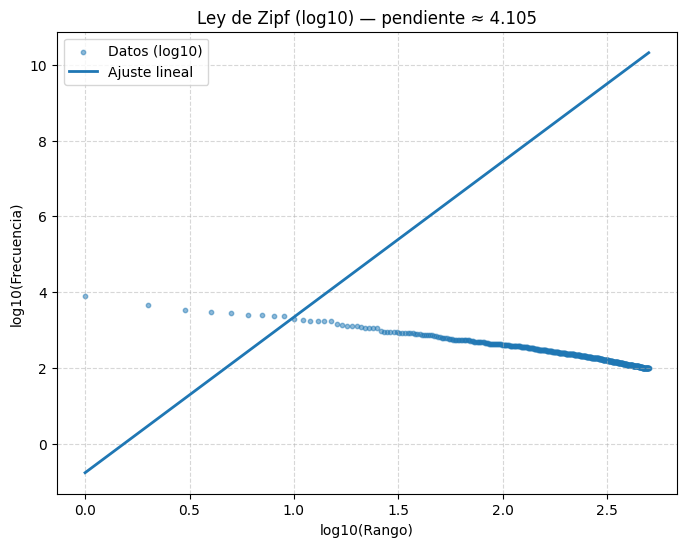

In [187]:
# =================================================================
# Ajuste lineal en escala log-log (opcional)
# =================================================================

# Usamos solo las primeras N palabras (las más frecuentes)
N = 500  # puedes ajustar este valor
ranks_N = ranks[:N]
freqs_N = freqs[:N]

# Pasar a log10
log_r = np.log10(ranks_N)
log_f = np.log10(freqs_N)

# Ajuste lineal: log_f ≈ a + b * log_r
coef = np.polyfit(log_r, log_f, 1)
a, b = coef

print(f"Recta ajustada en log10: log10(freq) ≈ {a:.3f} + {b:.3f} * log10(rango)")

# Graficar puntos + recta
plt.figure(figsize=(8, 6))
plt.scatter(log_r, log_f, s=10, alpha=0.5, label="Datos (log10)")
plt.plot(log_r, a + b * log_r, linewidth=2, label="Ajuste lineal")

plt.title(f"Ley de Zipf (log10) — pendiente ≈ {b:.3f}")
plt.xlabel("log10(Rango)")
plt.ylabel("log10(Frecuencia)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()
